In [2]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
#from ipynb.fs.full.Plot_PCA_functions import

In [3]:
## ANOTATION DATA
anotation = pd.read_csv('/branchinecta/jbazanwilliamson/SGDP_anotation.csv', sep=',', encoding='latin-1',  index_col=0)
telomeres = pd.read_table('/branchinecta/jbazanwilliamson/telomere_hg38')
centromeres = pd.read_table('/branchinecta/jbazanwilliamson/centromeres_hg38')
hm3_cnv_data = pd.read_table('/branchinecta/jbazanwilliamson/hm3_cnv_submission.txt')
header_list = ['SAMPLE_NAME','TYPE', 'POSITION', 'LENGHT', 'RD', 'T-TEST-EVAL', 'GAUSSIAN-EVAL', 'T-TEST-EVAL(MIDDLE)','GAUSSIAN-EVAL(MIDDLE)', 'FRAQ-READ-QUALITY' ]
cnvnator_data = pd.read_table('/branchinecta/jbazanwilliamson/CNVnator/CNVnator_results.txt', names=header_list)
telomeres['chrom'] = telomeres['chrom'].str.replace('chr', '')

anotation_cnvnator = pd.read_csv('/branchinecta/jbazanwilliamson/SGDP_anotation.csv', sep=',', encoding='latin-1',  index_col=1)

centromeres['chrom'] = centromeres['chrom'].str.replace('chr', '')

black_header = ['chr','start', 'end']
blacklist = pd.read_table('/branchinecta/jbazanwilliamson/bin_anotation/ENCFF356LFX.bed', names=black_header)
blacklist['chr'] = blacklist['chr'].str.replace('chr', '')
black_header = ['chr','start', 'end', 'type', 'score', 'none']
blacklist_2 = pd.read_table('/branchinecta/jbazanwilliamson/bin_anotation/ENCFF220FIN.bed', names=black_header)
blacklist_2['chr'] = blacklist_2['chr'].str.replace('chr', '')
#Table browser is 0-based coordinates, changed to 1-based for compability with CNV data
telomeres['chromStart'] = telomeres['chromStart'] + 1

centromeres['chromStart'] = centromeres['chromStart'] + 1

hm3_cnv_data['chr'] = hm3_cnv_data['chr'].astype(str)

anotation['10-Region'].value_counts()

#CNVNATOR DATA

anotation_cnvnator = anotation_cnvnator.drop(columns=['4-reich_id', '5-ena_ftp_bam_ptr', '6-Sequencing_Panel', '7-Gender', '8-Population_ID', '9-Contributor', '10-Region', '11-Country', '12-Town', '13-Latitude', '14-Longitude', '15-DNA_Source', '16-BioSamples Accession', '17-Embargo'])

features_cnvnator  = anotation_cnvnator.merge(cnvnator_data , left_index=True, right_index=True)

### WiseconderX data
header_list_wisecondor = ['SAMPLE_NAME', 'CHR', 'START', 'END', 'RATIO', 'ZSCORE',' TYPE']
wisecondor_data = pd.read_table('/branchinecta/jbazanwilliamson/wisecondor/results/results.txt', names=header_list_wisecondor)

cnvnator_data

SAMPLE_NAME         TYPE                  POSITION   LENGHT  \
0        LP6005441-DNA_A01     deletion                 1:1-10000  10000.0   
1        LP6005441-DNA_A01  duplication             1:11601-18400   6800.0   
2        LP6005441-DNA_A01     deletion             1:39901-48200   8300.0   
3        LP6005441-DNA_A01     deletion             1:49001-49700    700.0   
4        LP6005441-DNA_A01     deletion             1:51201-64200  13000.0   
...                    ...          ...                       ...      ...   
2652100          SS6004480  duplication  hs37d5:35449101-35452500   3400.0   
2652101          SS6004480  duplication  hs37d5:35453501-35458700   5200.0   
2652102          SS6004480     deletion  hs37d5:35459001-35460200   1200.0   
2652103          SS6004480     deletion  hs37d5:35463501-35464600   1100.0   
2652104          SS6004480     deletion  hs37d5:35466601-35478000  11400.0   

               RD   T-TEST-EVAL  GAUSSIAN-EVAL  T-TEST-EVAL(MIDDLE)  \
0        0.000000  1.593730e-11   0.000000e+00         1.992160e-11   
1        1.885520  0.000000e+00   2.870330e+09         1.644770e-04   
2        0.491248  1.920150e-11   1.170970e+04         2.529720e-11   
3        0.440000  1.171230e+02   1.951650e-05         1.000000e+00   
4        0.269762  1.225940e-11   7.811940e+03         1.448840e-11   
...           ...           ...            ...                  ...   
2652100  6.142330  1.571380e-02   8.098350e-02         2.307510e+01   
2652101  5.218620  6.135840e-08   1.654080e+09         1.479150e-03   
2652102  0.370035  2.871320e-01   3.368600e-05         1.000000e+00   
2652103  0.507767  8.729140e-01   4.879000e-04         1.000000e+00   
2652104  0.000490  1.398000e-11   0.000000e+00         1.695450e-11   

         GAUSSIAN-EVAL(MIDDLE)  FRAQ-READ-QUALITY  
0                 0.000000e+00                 -1  
1                 2.870520e+09                  1  
2                 2.329250e+05                  1  
3                 1.000000e+00                  1  
4                 5.609900e+04                  1  
...                        ...                ...  
2652100           1.300360e+05                  1  
2652101           2.411220e-98                  1  
2652102           1.000000e+00                  1  
2652103           1.000000e+00                  1  
2652104           0.000000e+00                  1  

[2652105 rows x 10 columns]

In [4]:
def read_vcf_files(vcf_files):
    """
    Read the path of vcf files to a dataframe.

    :param str vcf_file: Path to a vcf files.
    :return: dict of lists of vcf records
    :rtype: dict
    """
    files = glob.glob(vcf_files+'*.vcf')
    vcf_list = []
    for file in files:
        #return pd.DataFrame(read_vcf(file))
        vcf_list.append(read_vcf(file))
    
    return (vcf_list)
    

def read_vcf(vcf_file):
    """
    Read a vcf file to a dict of lists.

    :param str vcf_file: Path to a vcf file.
    :return: dict of lists of vcf records
    :rtype: dict
    """
    vcf_dict = []
    #df = pd.DataFrame()
    with open(vcf_file, 'r') as invcf:
        for line in invcf:
            if line.startswith('#'):
                continue
            line = line.strip().split()
            name = str(vcf_file.split('/')[4])
            name_2 = str(name.split('.')[0])
            CHR = line[0]
            START = line[1]
            INFO = str(line[7].split(';'))
            INFO = INFO.split('=')
            #INFO = INFO.split(',')
            END = INFO
            
        
            #vcf_dict.append((name_2,line[0], line[1], END))
            
            
            vcf_dict.append([name_2,line[0], line[1], line[7], line[9]])
            
    return vcf_dict

In [5]:
df = read_vcf_files('/branchinecta/jbazanwilliamson/QDNASEQ_5K/')
df

Output = []
  
# Using iteration
for temp in df:
    for elem in temp:
        Output.append(elem)

pd.DataFrame(Output)

0  1          2  \
0      SAMEA3302854  2   34470001   
1      SAMEA3302854  3   75665001   
2      SAMEA3302854  3  198095001   
3      SAMEA3302854  4    9010001   
4      SAMEA3302854  4   68815001   
...             ... ..        ...   
21492  SAMEA3302800  X  154555001   
21493  SAMEA3302800  X  155335001   
21494  SAMEA3302800  X  155455001   
21495  SAMEA3302800  Y    2780001   
21496  SAMEA3302800  Y   26640001   

                                                       3    4  
0      SVTYPE=DEL;END=34505000;SVLEN=35000;BINS=6;SCO...  1/1  
1      SVTYPE=DUP;END=75710000;SVLEN=45000;BINS=7;SCO...  0/1  
2      SVTYPE=DEL;END=198170000;SVLEN=75000;BINS=6;SC...  1/1  
3      SVTYPE=DUP;END=9505000;SVLEN=495000;BINS=20;SC...  0/1  
4      SVTYPE=DUP;END=68855000;SVLEN=40000;BINS=8;SCO...  0/1  
...                                                  ...  ...  
21492  SVTYPE=DEL;END=154650000;SVLEN=95000;BINS=19;S...  1/1  
21493  SVTYPE=DEL;END=155385000;SVLEN=50000;BINS=10;S...  1/1  
21494  SVTYPE=DEL;END=155505000;SVLEN=50000;BINS=10;S...  1/1  
21495  SVTYPE=DEL;END=26640000;SVLEN=23860000;BINS=44...  1/1  
21496  SVTYPE=DEL;END=26675000;SVLEN=35000;BINS=7;SCO...  0/1  

[21497 rows x 5 columns]

In [6]:
df = pd.DataFrame(Output)
info = df[3].str.split(';', expand=True)


end = info[1].str.split('=', expand=True)
end = end[1]


size = info[2].str.split('=', expand=True)
size = size[1]

score = info[4].str.split('=', expand=True)
score = score[1]

log2 = info[5].str.split('=', expand=True)
log2 = log2[1]

In [7]:
qdnaseq_df = pd.DataFrame()
qdnaseq_df['SAMPLE'] = df[0]
qdnaseq_df['CHR'] = df[1]
qdnaseq_df['START'] = df[2].astype(int)
qdnaseq_df['END'] = end.astype(int)
qdnaseq_df['SIZE'] = size.astype(int)
qdnaseq_df['SCORE'] = score
qdnaseq_df['LOG2'] = log2.astype(float)


#CHANGING to HAPMAP format


qdnaseq_df['SCORE'].replace('-2', 'DELETION', inplace=True)
qdnaseq_df['SCORE'].replace('-1', 'DELETION', inplace=True)
qdnaseq_df['SCORE'].replace('1', 'DUPLICATION', inplace=True)
qdnaseq_df['SCORE'].replace('2', 'DUPLICATION', inplace=True)
qdnaseq_df['SCORE'].replace('3', 'DUPLICATION', inplace=True)

qdnaseq_df['TYPE'] = score
qdnaseq_df['TYPE'].replace('-2', 0, inplace=True)
qdnaseq_df['TYPE'].replace('-1', 1, inplace=True)
qdnaseq_df['TYPE'].replace('1', 3, inplace=True)
qdnaseq_df['TYPE'].replace('2', 4, inplace=True)
qdnaseq_df['TYPE'].replace('3', 5, inplace=True)


qdnaseq_df



SAMPLE CHR      START        END      SIZE        SCORE   LOG2  \
0      SAMEA3302854   2   34470001   34505000     35000     DELETION  -1.01   
1      SAMEA3302854   3   75665001   75710000     45000  DUPLICATION   0.90   
2      SAMEA3302854   3  198095001  198170000     75000     DELETION  -0.25   
3      SAMEA3302854   4    9010001    9505000    495000  DUPLICATION   0.59   
4      SAMEA3302854   4   68815001   68855000     40000  DUPLICATION   0.45   
...             ...  ..        ...        ...       ...          ...    ...   
21492  SAMEA3302800   X  154555001  154650000     95000     DELETION  -2.54   
21493  SAMEA3302800   X  155335001  155385000     50000     DELETION  -6.19   
21494  SAMEA3302800   X  155455001  155505000     50000     DELETION  -6.15   
21495  SAMEA3302800   Y    2780001   26640000  23860000     DELETION -20.51   
21496  SAMEA3302800   Y   26640001   26675000     35000     DELETION  -5.80   

       TYPE  
0         0  
1         3  
2         0  
3         3  
4         3  
...     ...  
21492     0  
21493     0  
21494     0  
21495     0  
21496     1  

[21497 rows x 8 columns]

<h2> Filtration

In [8]:
#Filter by CNV size
#qdnaseq_df = qdnaseq_df.loc[((qdnaseq_df['SIZE'] > 1000000) & (qdnaseq_df['SIZE'] < 5000000)),:]
qdnaseq_df = qdnaseq_df.loc[(qdnaseq_df['SIZE'] < 1000000),:]


#DROP Y AND X CHRs

#FILTERR BY LOG SIGNIFICATION
qdnaseq_df_low = qdnaseq_df[qdnaseq_df.LOG2 < -0.3]
qdnaseq_df_high = qdnaseq_df[qdnaseq_df.LOG2 > 0.3]
qdnaseq_df = pd.concat([qdnaseq_df_high,qdnaseq_df_low])

#Filter by CNV size
#qdnaseq_df = qdnaseq_df.loc[((qdnaseq_df['SIZE'] > 1000000) & (qdnaseq_df['SIZE'] < 5000000)),:]

###########
#FILTER OUT SAMPLES WITH HIGH NUMBER OF CNVS 
qdnaseq_df = qdnaseq_df[qdnaseq_df.groupby("SAMPLE")["SAMPLE"].transform('size') < 100]


samples_with_aberrations = ['SAMEA3302841', 'SAMEA3302787','SAMEA3302646', 'SAMEA3302785']

qdnaseq_df = qdnaseq_df[~qdnaseq_df.SAMPLE.isin(samples_with_aberrations)]

## Filter by chromosomes
qdnaseq_df_x = qdnaseq_df[qdnaseq_df.CHR == 'X']
qdnaseq_df_no_sex_chr = qdnaseq_df[qdnaseq_df.CHR != 'Y']
qdnaseq_df_no_sex_chr = qdnaseq_df_no_sex_chr[qdnaseq_df_no_sex_chr.CHR != 'X']


qdnaseq_df

SAMPLE CHR      START        END    SIZE        SCORE  LOG2  TYPE
1      SAMEA3302854   3   75665001   75710000   45000  DUPLICATION  0.90     3
3      SAMEA3302854   4    9010001    9505000  495000  DUPLICATION  0.59     3
4      SAMEA3302854   4   68815001   68855000   40000  DUPLICATION  0.45     3
9      SAMEA3302854   7    2230001    2315000   85000  DUPLICATION  0.58     3
11     SAMEA3302854   7   65795001   65815000   20000  DUPLICATION  0.94     3
...             ...  ..        ...        ...     ...          ...   ...   ...
21491  SAMEA3302800   X  154145001  154295000  150000     DELETION -6.55     0
21492  SAMEA3302800   X  154555001  154650000   95000     DELETION -2.54     0
21493  SAMEA3302800   X  155335001  155385000   50000     DELETION -6.19     0
21494  SAMEA3302800   X  155455001  155505000   50000     DELETION -6.15     0
21496  SAMEA3302800   Y   26640001   26675000   35000     DELETION -5.80     1

[12460 rows x 8 columns]

In [9]:
qdnaseq_df[qdnaseq_df.SAMPLE.isin(samples_with_aberrations)]

Empty DataFrame
Columns: [SAMPLE, CHR, START, END, SIZE, SCORE, LOG2, TYPE]
Index: []

In [10]:
# To array for loop purposes 

np_data_style = qdnaseq_df.to_numpy()

telomere = telomeres.to_numpy()
centromere = centromeres.to_numpy()

np_hm3 = hm3_cnv_data.to_numpy()

In [11]:
qdnaseq_df['SAMPLE'].value_counts()

SAMEA3302668    98
SAMEA3302890    89
SAMEA3302666    89
SAMEA3302663    88
SAMEA3302877    88
                ..
SAMEA3302725    18
SAMEA3302818    17
SAMEA3302672    16
SAMEA3302911    15
SAMEA3302795    14
Name: SAMPLE, Length: 245, dtype: int64

array([[<AxesSubplot:title={'center':'START'}>,
        <AxesSubplot:title={'center':'END'}>],
       [<AxesSubplot:title={'center':'SIZE'}>,
        <AxesSubplot:title={'center':'LOG2'}>],
       [<AxesSubplot:title={'center':'TYPE'}>, <AxesSubplot:>]],
      dtype=object)

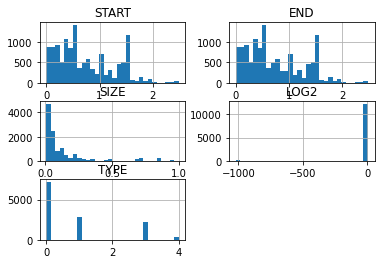

In [12]:
qdnaseq_df.hist(bins=30)

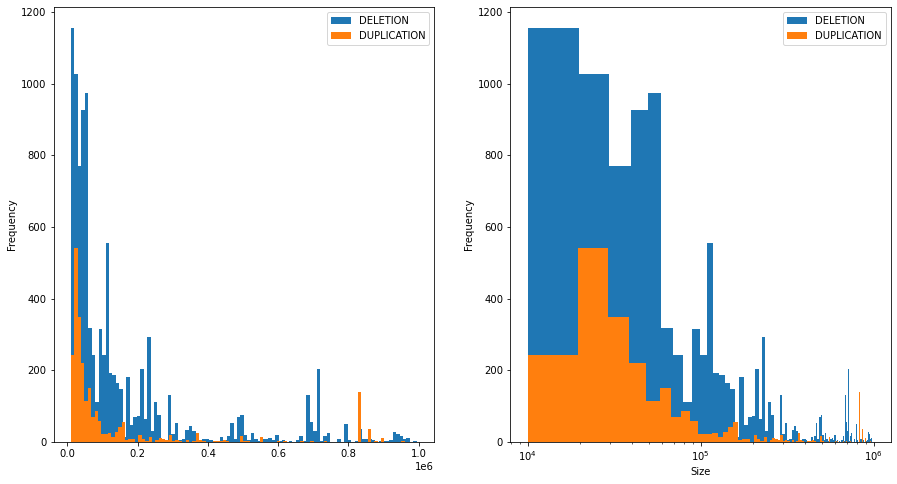

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
plt.xlabel('Size')

df = qdnaseq_df.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100,legend=True, ax=axs[0]) # alpha for transparency
#plt.xlabel('Size')
plt.xscale('log')

df = qdnaseq_df.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency
#plt.xlabel('Size')
plt.show()

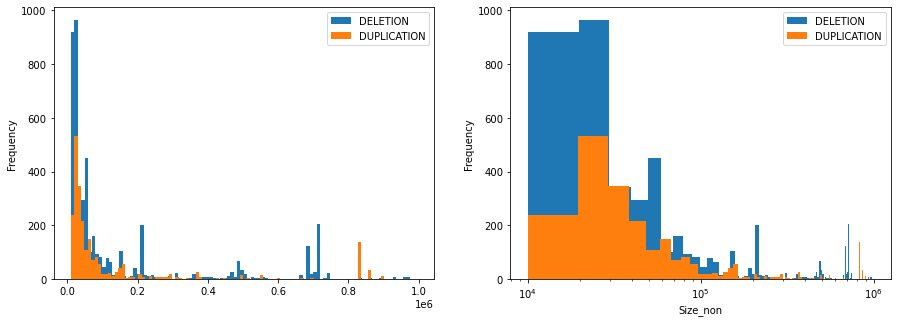

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

df = qdnaseq_df_no_sex_chr.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100,legend=True, ax=axs[0]) # alpha for transparency
plt.xscale('log')
plt.xlabel('Size')
#plt.show()

df = qdnaseq_df_no_sex_chr.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency
plt.xlabel('Size_non')
plt.show()



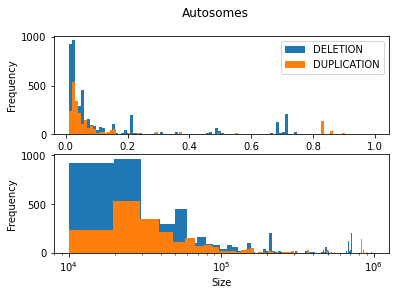

In [15]:
fig, axs = plt.subplots(2)
fig.suptitle('Autosomes')

#fig, axs = plt.subplots(1, 2, figsize=(15, 5))


#plt.show()

df = qdnaseq_df_no_sex_chr.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, ax=axs[1]) # alpha for transparency
plt.xlabel('Size_non')


df = qdnaseq_df_no_sex_chr.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100,legend=True, ax=axs[0]) # alpha for transparency
plt.xscale('log')
plt.xlabel('Size')


plt.show()



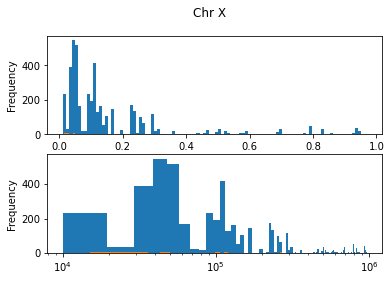

In [16]:
fig, axs = plt.subplots(2)
fig.suptitle('Chr X')

df = qdnaseq_df_x.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df = qdnaseq_df_x.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, ax=axs[1]) # alpha for transparency

plt.show()

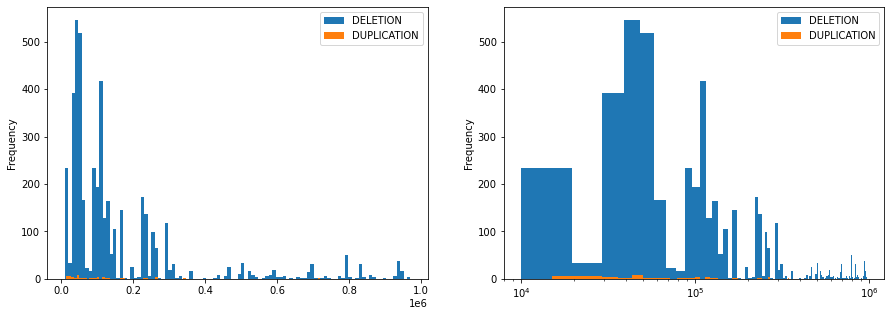

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

df = qdnaseq_df_x.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df = qdnaseq_df_x.groupby(['SCORE'])['SIZE']

df.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

In [18]:

#CHANGED TO RD VALUE
#qdnaseq_df['LOG2'] =np.exp(qdnaseq_df['LOG2'])

In [19]:
qdnaseq_df

SAMPLE CHR      START        END    SIZE        SCORE  LOG2  TYPE
1      SAMEA3302854   3   75665001   75710000   45000  DUPLICATION  0.90     3
3      SAMEA3302854   4    9010001    9505000  495000  DUPLICATION  0.59     3
4      SAMEA3302854   4   68815001   68855000   40000  DUPLICATION  0.45     3
9      SAMEA3302854   7    2230001    2315000   85000  DUPLICATION  0.58     3
11     SAMEA3302854   7   65795001   65815000   20000  DUPLICATION  0.94     3
...             ...  ..        ...        ...     ...          ...   ...   ...
21491  SAMEA3302800   X  154145001  154295000  150000     DELETION -6.55     0
21492  SAMEA3302800   X  154555001  154650000   95000     DELETION -2.54     0
21493  SAMEA3302800   X  155335001  155385000   50000     DELETION -6.19     0
21494  SAMEA3302800   X  155455001  155505000   50000     DELETION -6.15     0
21496  SAMEA3302800   Y   26640001   26675000   35000     DELETION -5.80     1

[12460 rows x 8 columns]

In [20]:
#qdnaseq_df = qdnaseq_df_no_sex_chr
deletions = qdnaseq_df[qdnaseq_df['TYPE'] < 2] 
duplications= qdnaseq_df[qdnaseq_df['TYPE'] > 2] 



In [21]:
qdnaseq_pvt = deletions.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='TYPE').reset_index()

qdnaseq_pvt

SAMPLE CHR     START       END  SAMEA3302610  SAMEA3302611  SAMEA3302612  \
0        1   1445001   1500000           NaN           NaN           NaN   
1        1   1470001   1510000           NaN           NaN           NaN   
2        1   1675001   1735000           NaN           NaN           NaN   
3        1   6555001   6575000           NaN           NaN           NaN   
4        1  12785001  13245000           NaN           NaN           NaN   
...     ..       ...       ...           ...           ...           ...   
1603     Y  25070001  25195000           NaN           NaN           NaN   
1604     Y  26310001  26675000           NaN           NaN           NaN   
1605     Y  26525001  26645000           NaN           NaN           NaN   
1606     Y  26630001  26675000           NaN           NaN           NaN   
1607     Y  26640001  26675000           NaN           NaN           NaN   

SAMPLE  SAMEA3302613  SAMEA3302614  SAMEA3302615  SAMEA3302616  ...  \
0                NaN           NaN           NaN           NaN  ...   
1                NaN           NaN           NaN           NaN  ...   
2                NaN           NaN           NaN           NaN  ...   
3                NaN           NaN           NaN           NaN  ...   
4                NaN           NaN           NaN           NaN  ...   
...              ...           ...           ...           ...  ...   
1603             NaN           NaN           NaN           NaN  ...   
1604             NaN           NaN           NaN           NaN  ...   
1605             NaN           NaN           NaN           NaN  ...   
1606             NaN           NaN           NaN           NaN  ...   
1607             NaN           NaN           NaN           NaN  ...   

SAMPLE  SAMEA3302893  SAMEA3302894  SAMEA3302896  SAMEA3302900  SAMEA3302903  \
0                NaN           NaN           NaN           NaN           NaN   
1                NaN           NaN           NaN           NaN           NaN   
2                NaN           NaN           NaN           NaN           NaN   
3                NaN           NaN           NaN           NaN           NaN   
4                NaN           NaN           NaN           NaN           NaN   
...              ...           ...           ...           ...           ...   
1603             NaN           NaN           NaN           NaN           NaN   
1604             NaN           NaN           NaN           NaN           NaN   
1605             NaN           NaN           NaN           NaN           NaN   
1606             NaN           NaN           NaN           NaN           NaN   
1607             NaN           NaN           1.0           NaN           1.0   

SAMPLE  SAMEA3302904  SAMEA3302906  SAMEA3302908  SAMEA3302911  SAMEA3449877  
0                NaN           NaN           NaN           NaN           NaN  
1                NaN           NaN           NaN           NaN           NaN  
2                NaN           NaN           NaN           NaN           NaN  
3                NaN           NaN           NaN           NaN           NaN  
4                NaN           NaN           NaN           NaN           NaN  
...              ...           ...           ...           ...           ...  
1603             NaN           NaN           NaN           NaN           NaN  
1604             NaN           NaN           NaN           NaN           NaN  
1605             NaN           NaN           NaN           NaN           NaN  
1606             1.0           NaN           NaN           NaN           NaN  
1607             NaN           1.0           NaN           NaN           NaN  

[1608 rows x 248 columns]

In [22]:
### HIGH FREQ CNVS 
freq = qdnaseq_pvt.iloc[:,3:284]
freq_input = freq.rename(columns=anotation['10-Region'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df = df.T

africa = df[df['Africa'] > 0.50]
america = df[df['America'] > 0.5]
siberia = df[df['CentralAsiaSiberia'] > 0.5]
eastasia = df[df['EastAsia'] > 0.5]
oceania = df[df['Oceania'] > 0.5]
southasia = df[df['SouthAsia'] > 0.5]
euro = df[df['WestEurasia'] > 0.5]

list_high_freq_index = pd.concat([africa, america, siberia, eastasia,oceania, southasia,euro])


ind_list = list(list_high_freq_index.index)
high_freq_african = qdnaseq_pvt.iloc[ind_list]
high_freq_african

SAMPLE CHR     START       END  SAMEA3302610  SAMEA3302611  SAMEA3302612  \
222     13  18175001  18855000           NaN           0.0           NaN   
242     13  57180001  57200000           NaN           0.0           NaN   
439     17  36190001  36215000           NaN           0.0           0.0   
449     17  45570001  46280000           NaN           0.0           0.0   
741      3  46755001  46810000           NaN           NaN           NaN   
...     ..       ...       ...           ...           ...           ...   
439     17  36190001  36215000           NaN           0.0           0.0   
449     17  45570001  46280000           NaN           0.0           0.0   
538      2  34470001  34505000           NaN           NaN           0.0   
1160     8  39375001  39525000           NaN           NaN           NaN   
1260     X     10001    240000           1.0           NaN           0.0   

SAMPLE  SAMEA3302613  SAMEA3302614  SAMEA3302615  SAMEA3302616  ...  \
222              1.0           NaN           NaN           0.0  ...   
242              NaN           NaN           0.0           NaN  ...   
439              NaN           0.0           0.0           0.0  ...   
449              1.0           0.0           0.0           0.0  ...   
741              NaN           NaN           NaN           NaN  ...   
...              ...           ...           ...           ...  ...   
439              NaN           0.0           0.0           0.0  ...   
449              1.0           0.0           0.0           0.0  ...   
538              NaN           NaN           NaN           NaN  ...   
1160             NaN           NaN           NaN           0.0  ...   
1260             NaN           NaN           0.0           NaN  ...   

SAMPLE  SAMEA3302893  SAMEA3302894  SAMEA3302896  SAMEA3302900  SAMEA3302903  \
222              NaN           NaN           NaN           0.0           NaN   
242              NaN           NaN           NaN           0.0           NaN   
439              1.0           1.0           1.0           0.0           1.0   
449              NaN           1.0           NaN           0.0           NaN   
741              NaN           NaN           NaN           NaN           NaN   
...              ...           ...           ...           ...           ...   
439              1.0           1.0           1.0           0.0           1.0   
449              NaN           1.0           NaN           0.0           NaN   
538              NaN           NaN           NaN           NaN           NaN   
1160             NaN           NaN           1.0           NaN           NaN   
1260             NaN           1.0           NaN           0.0           NaN   

SAMPLE  SAMEA3302904  SAMEA3302906  SAMEA3302908  SAMEA3302911  SAMEA3449877  
222              NaN           1.0           NaN           NaN           0.0  
242              NaN           NaN           NaN           NaN           NaN  
439              1.0           NaN           NaN           0.0           0.0  
449              1.0           0.0           NaN           0.0           0.0  
741              NaN           NaN           NaN           NaN           NaN  
...              ...           ...           ...           ...           ...  
439              1.0           NaN           NaN           0.0           0.0  
449              1.0           0.0           NaN           0.0           0.0  
538              1.0           NaN           NaN           NaN           NaN  
1160             NaN           1.0           NaN           NaN           NaN  
1260             1.0           0.0           0.0           NaN           NaN  

[94 rows x 248 columns]

In [23]:
counts = high_freq_african.iloc[:,3:283]

counts = counts.fillna(2)

hist = (np.array(counts).flatten())
#seaborn.histplot(hist)
counts 





SAMPLE  SAMEA3302610  SAMEA3302611  SAMEA3302612  SAMEA3302613  SAMEA3302614  \
222              2.0           0.0           2.0           1.0           2.0   
242              2.0           0.0           2.0           2.0           2.0   
439              2.0           0.0           0.0           2.0           0.0   
449              2.0           0.0           0.0           1.0           0.0   
741              2.0           2.0           2.0           2.0           2.0   
...              ...           ...           ...           ...           ...   
439              2.0           0.0           0.0           2.0           0.0   
449              2.0           0.0           0.0           1.0           0.0   
538              2.0           2.0           0.0           2.0           2.0   
1160             2.0           2.0           2.0           2.0           2.0   
1260             1.0           2.0           0.0           2.0           2.0   

SAMPLE  SAMEA3302615  SAMEA3302616  SAMEA3302618  SAMEA3302619  SAMEA3302620  \
222              2.0           0.0           0.0           0.0           0.0   
242              0.0           2.0           2.0           2.0           2.0   
439              0.0           0.0           0.0           0.0           2.0   
449              0.0           0.0           0.0           0.0           0.0   
741              2.0           2.0           2.0           2.0           2.0   
...              ...           ...           ...           ...           ...   
439              0.0           0.0           0.0           0.0           2.0   
449              0.0           0.0           0.0           0.0           0.0   
538              2.0           2.0           2.0           2.0           2.0   
1160             2.0           0.0           0.0           0.0           2.0   
1260             0.0           2.0           0.0           2.0           2.0   

SAMPLE  ...  SAMEA3302893  SAMEA3302894  SAMEA3302896  SAMEA3302900  \
222     ...           2.0           2.0           2.0           0.0   
242     ...           2.0           2.0           2.0           0.0   
439     ...           1.0           1.0           1.0           0.0   
449     ...           2.0           1.0           2.0           0.0   
741     ...           2.0           2.0           2.0           2.0   
...     ...           ...           ...           ...           ...   
439     ...           1.0           1.0           1.0           0.0   
449     ...           2.0           1.0           2.0           0.0   
538     ...           2.0           2.0           2.0           2.0   
1160    ...           2.0           2.0           1.0           2.0   
1260    ...           2.0           1.0           2.0           0.0   

SAMPLE  SAMEA3302903  SAMEA3302904  SAMEA3302906  SAMEA3302908  SAMEA3302911  \
222              2.0           2.0           1.0           2.0           2.0   
242              2.0           2.0           2.0           2.0           2.0   
439              1.0           1.0           2.0           2.0           0.0   
449              2.0           1.0           0.0           2.0           0.0   
741              2.0           2.0           2.0           2.0           2.0   
...              ...           ...           ...           ...           ...   
439              1.0           1.0           2.0           2.0           0.0   
449              2.0           1.0           0.0           2.0           0.0   
538              2.0           1.0           2.0           2.0           2.0   
1160             2.0           2.0           1.0           2.0           2.0   
1260             2.0           1.0           0.0           0.0           2.0   

SAMPLE  SAMEA3449877  
222              0.0  
242              2.0  
439              0.0  
449              0.0  
741              2.0  
...              ...  
439              0.0  
449              0.0  
538              2.0  
1160             2.0  
1260       

/opt/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

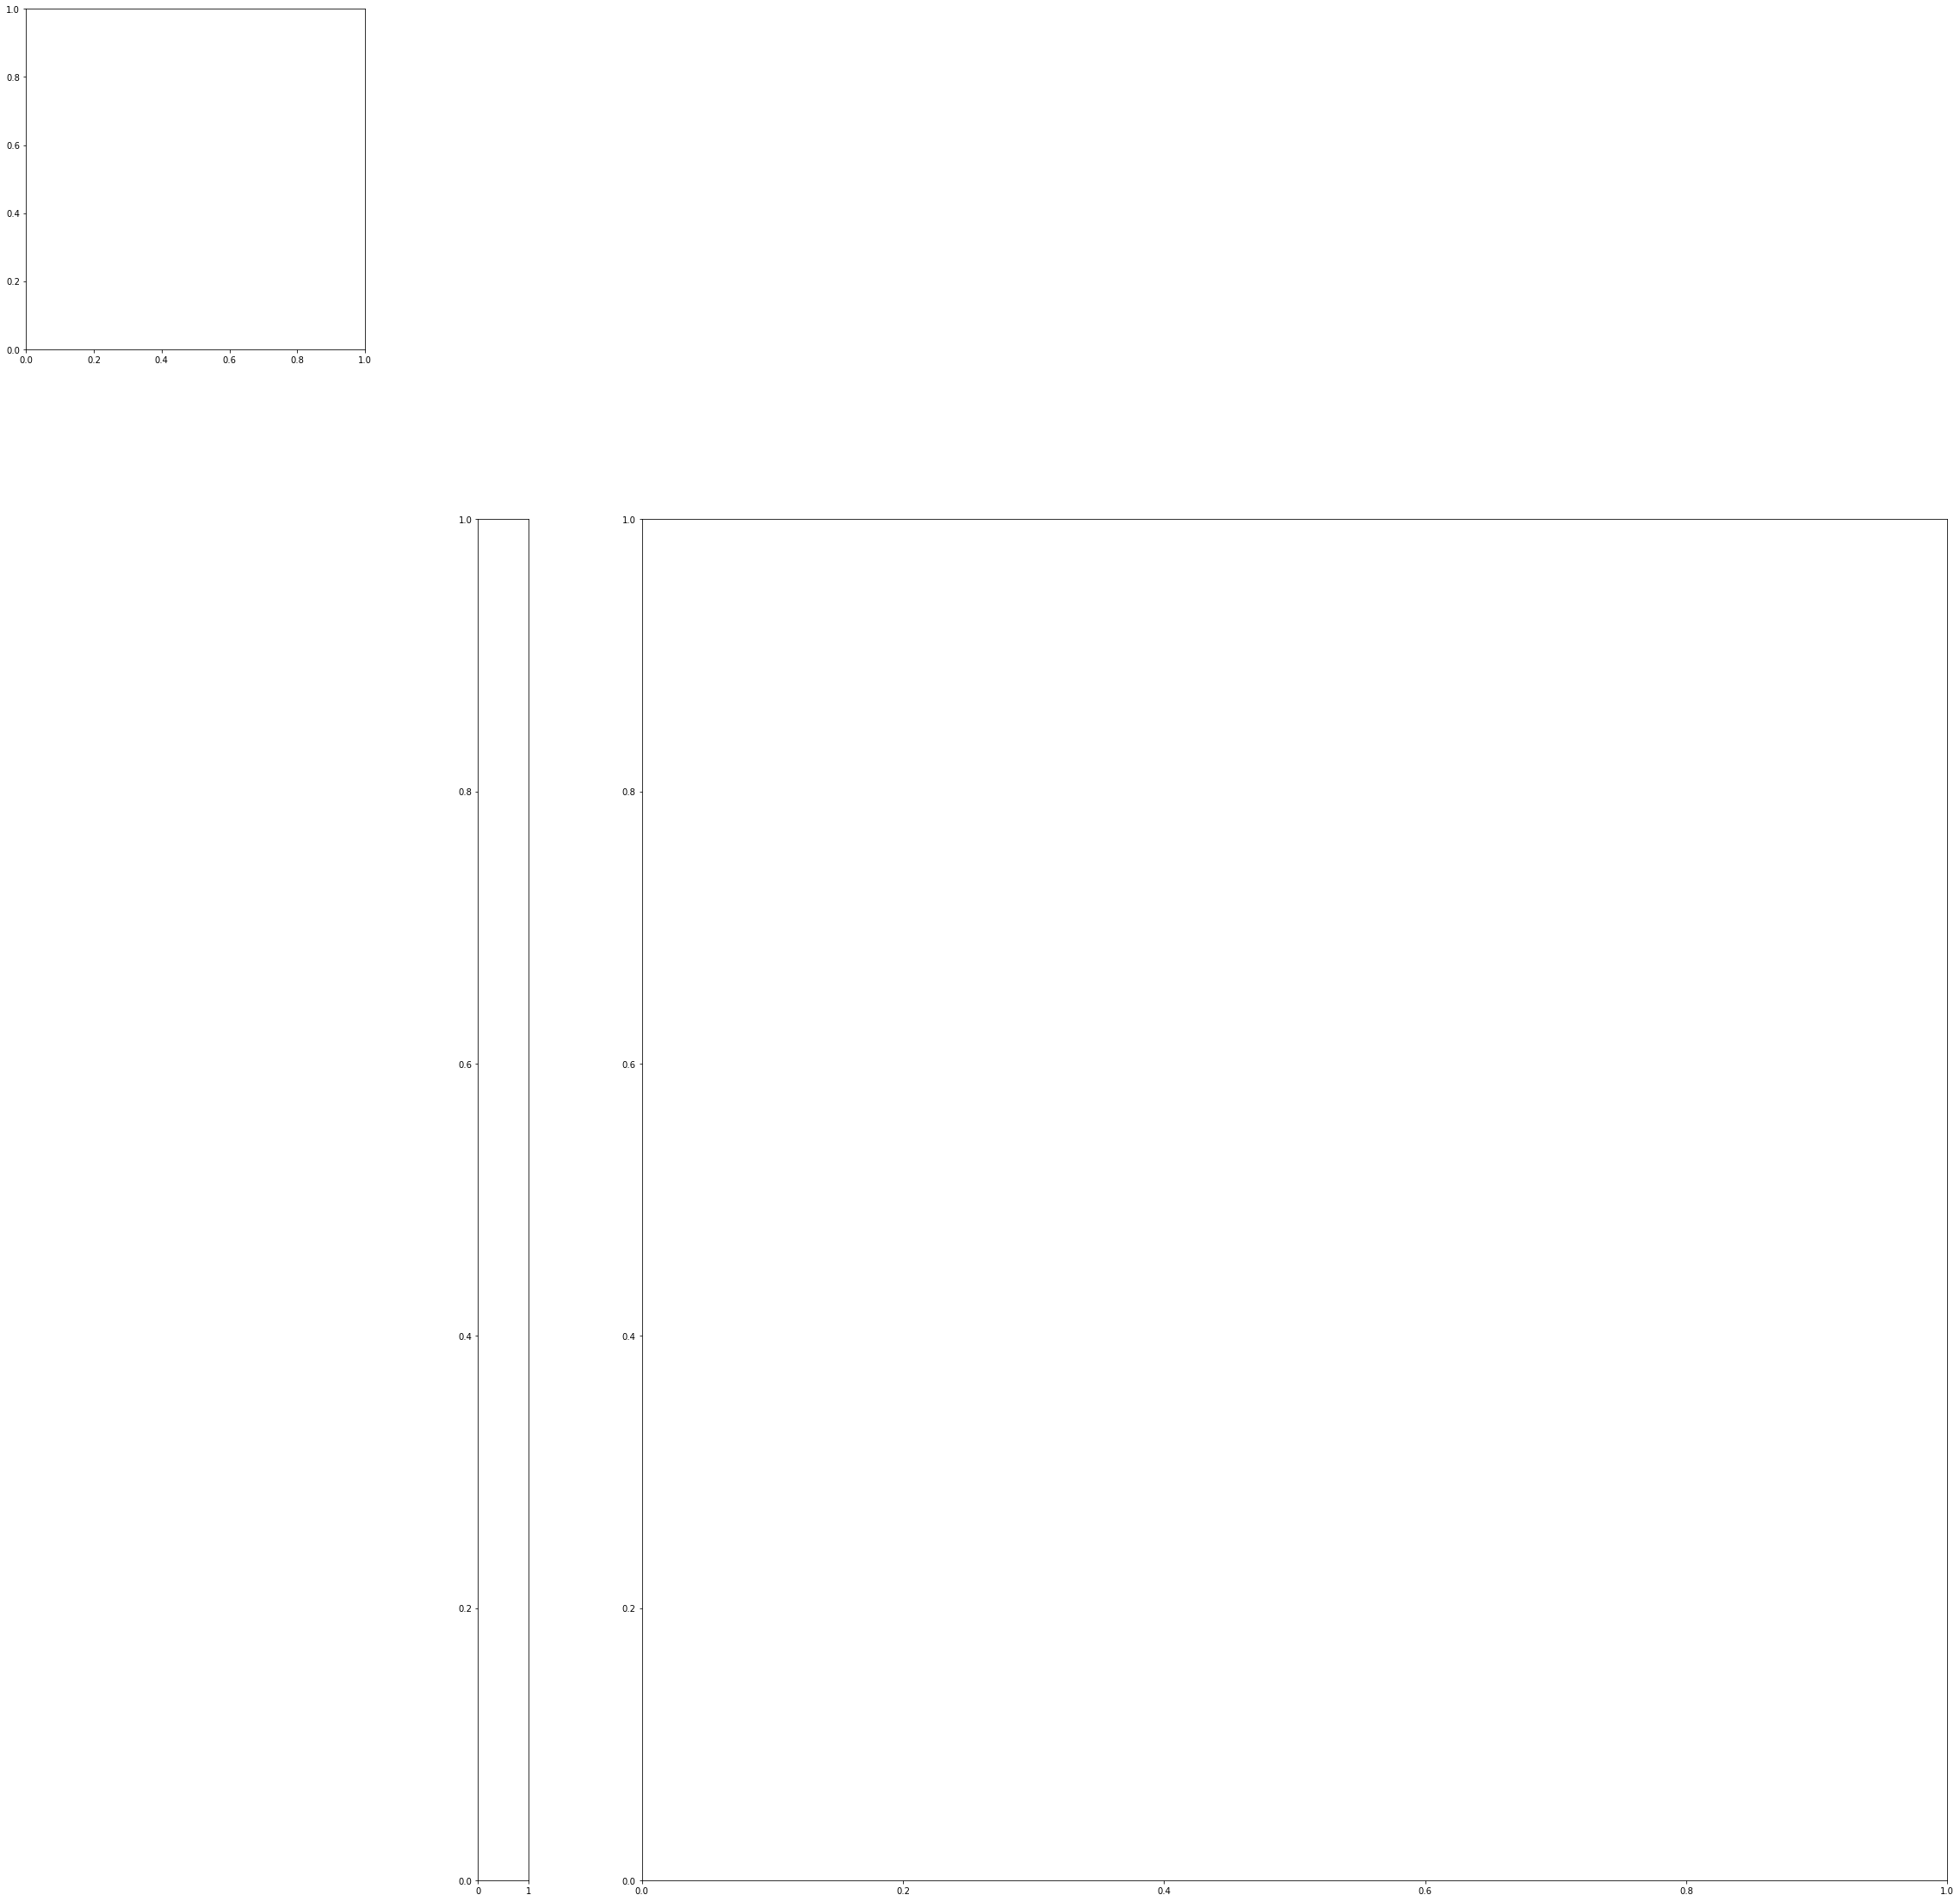

In [24]:
#f, ax = plt.subplots(figsize=(20, 20))

input_matrix = counts.rename(columns=anotation['10-Region'])
corrmatrix = input_matrix.corr(method='spearman', min_periods=10)
#corrmatrix = np.corrcoef(input_matrix)

import seaborn as sns#; sns.set_theme(color_codes=True)
lut = dict(zip(corrmatrix.columns.unique(), "rbgymck"))
lut

row_colors = corrmatrix.columns.map(lut)
seaborn.clustermap(corrmatrix,row_colors=row_colors, row_cluster=True, figsize=(40,40))
#plt.show()

In [ ]:
freq = qdnaseq_pvt.iloc[:,3:283]
freq_input = freq.rename(columns=anotation['10-Region'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df = df.T

df

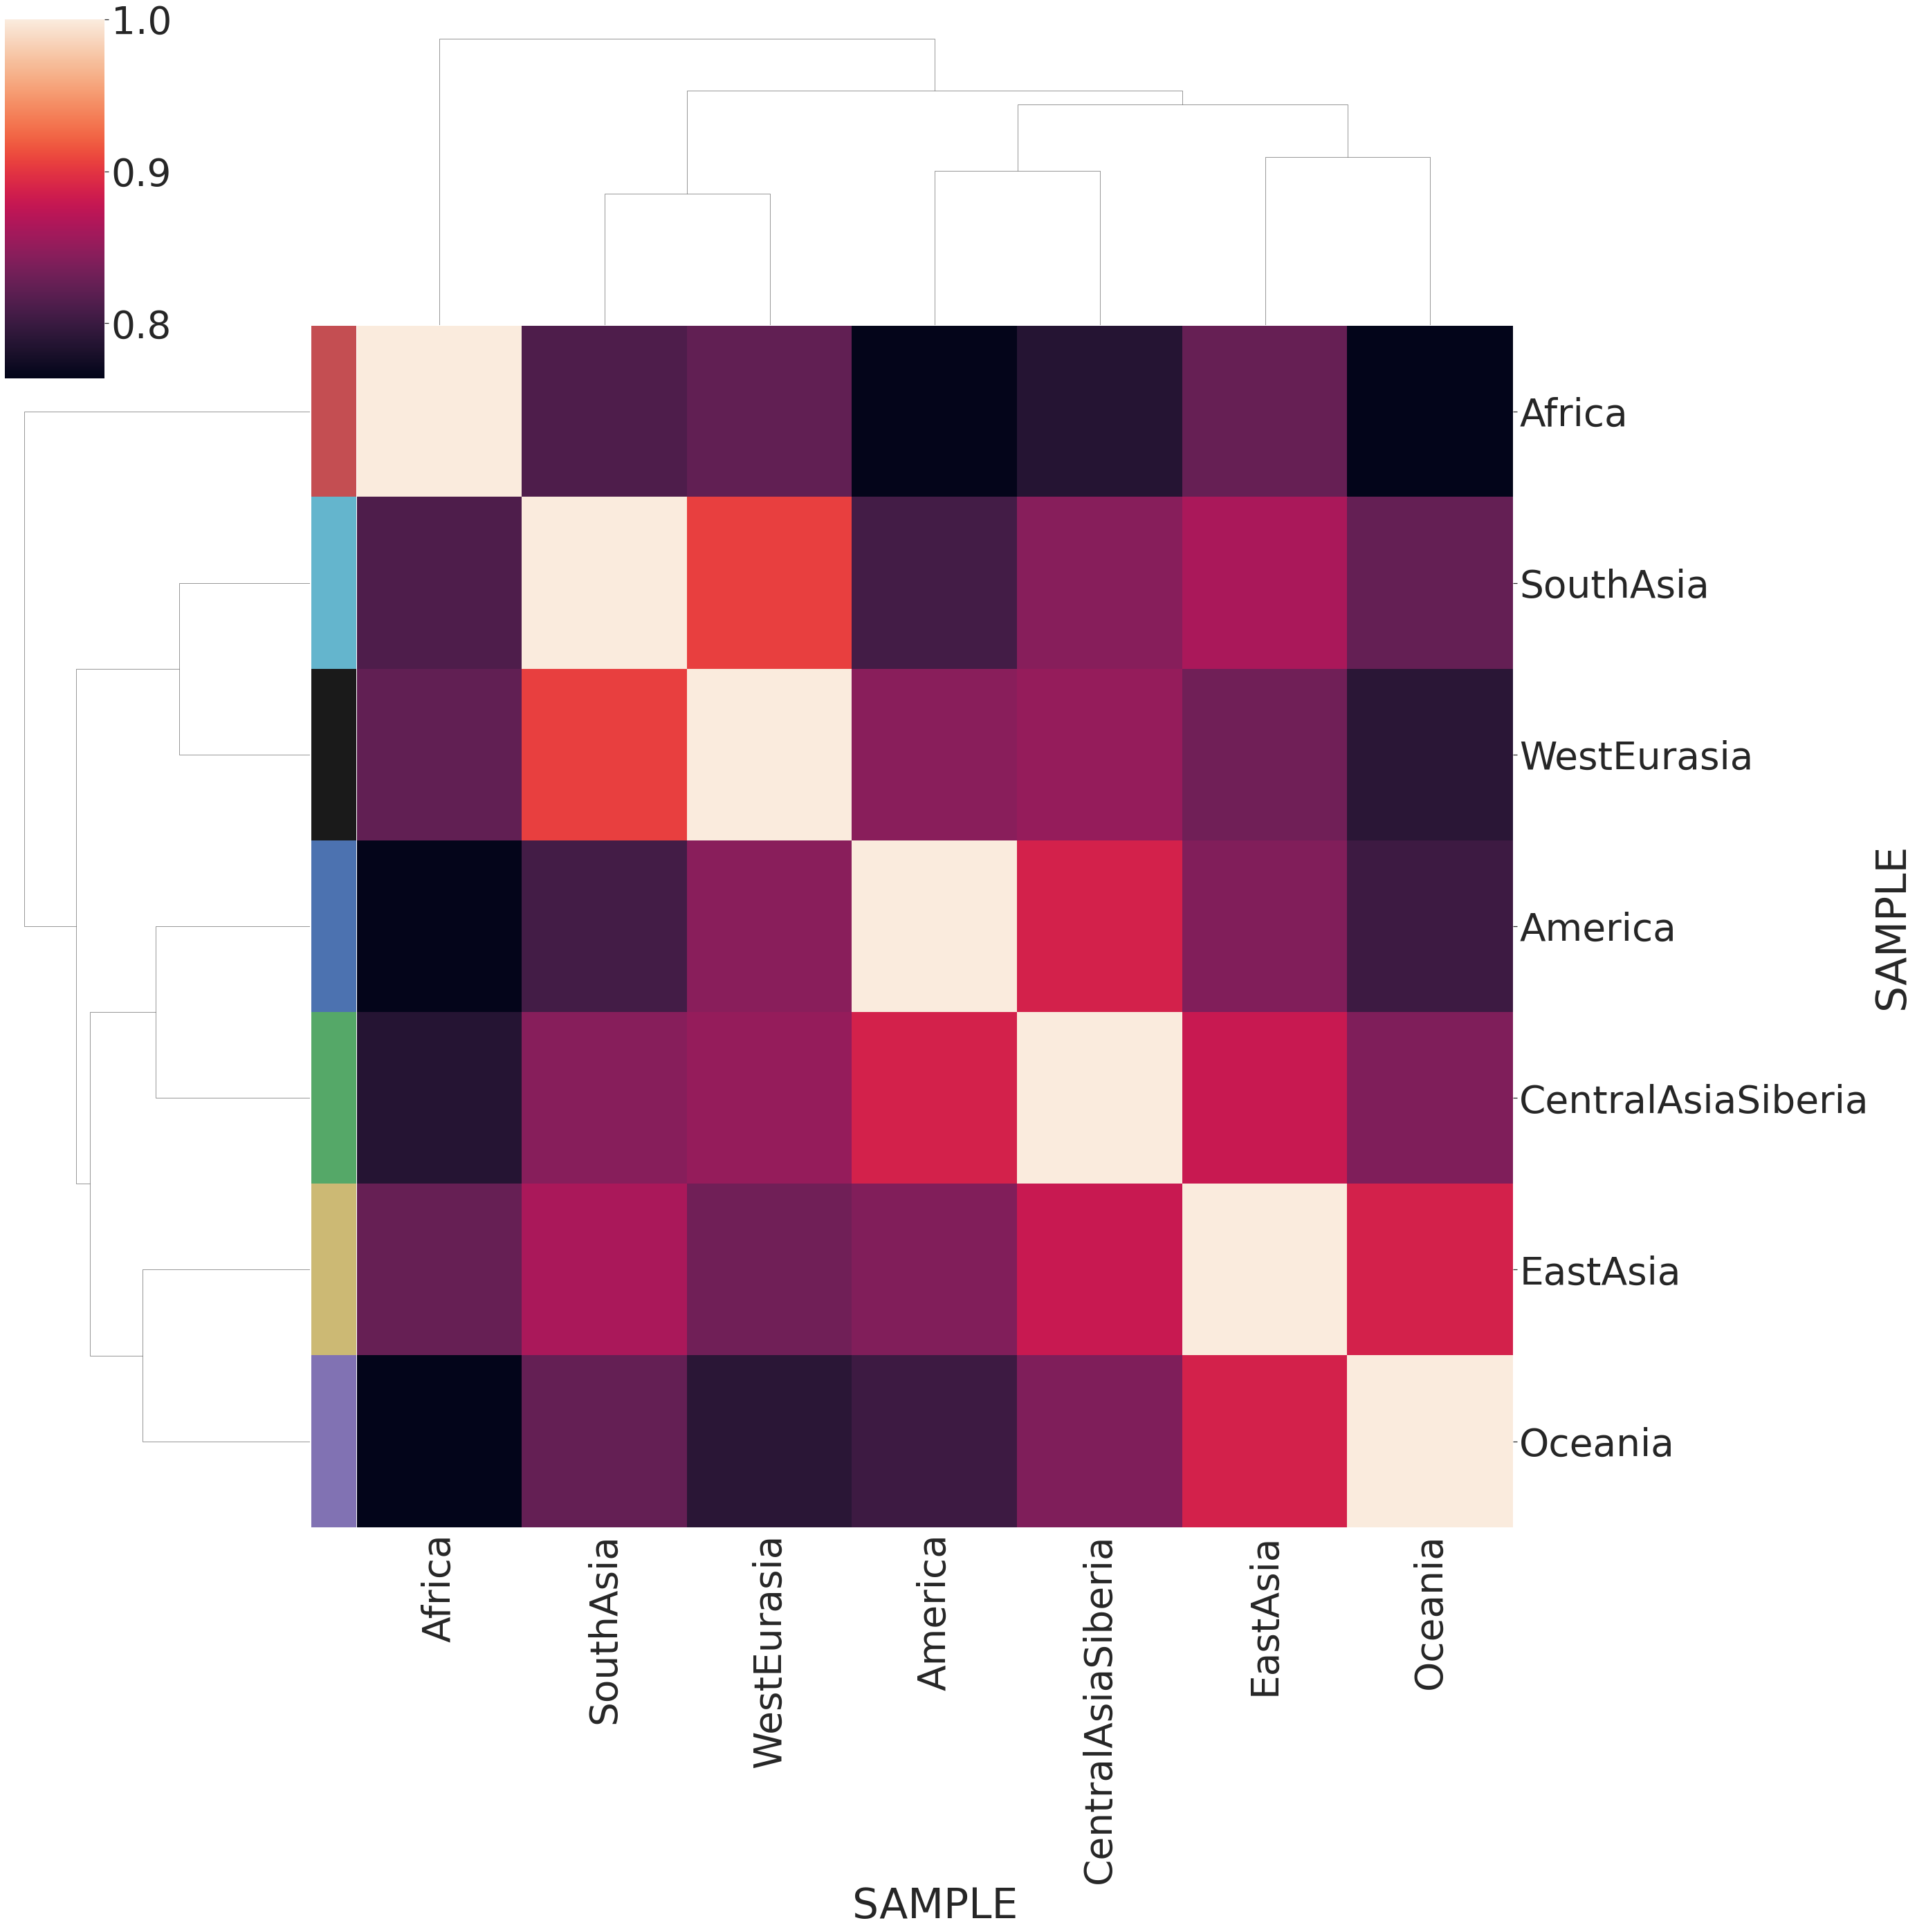

In [25]:
lut = dict(zip(df.columns.unique(), "rbgymck"))
lut

seaborn.set(font_scale=5)
corrmatrix = df.corr(method='pearson')
row_colors = df.columns.map(lut)
seaborn.clustermap(corrmatrix, row_colors=row_colors, row_cluster=True, figsize=(40,40))

In [92]:
freq = qdnaseq_pvt.iloc[:,3:283]
freq_input = freq.rename(columns=anotation['11-Country'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df

0     1     2     3     4     5     6     7     \
SAMPLE                                                                     
Abkhazia                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Algeria                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Argentina                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Armenia                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Australia                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
Turkey                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
USA                        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Vietnam                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Western Sahara (Morocco)   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Yemen                      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                          8     9     ...  1598  1599  1600  1601  1602  1603  \
SAMPLE                                ...                                       
Abkhazia                   0.0   0.0  ...   1.0   0.0   1.0   0.0   0.0   0.0   
Algeria                    0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
Argentina                  0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
Armenia                    0.0   0.0  ...   0.5   0.0   0.5   0.0   0.0   0.0   
Australia                  0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
...                        ...   ...  ...   ...   ...   ...   ...   ...   ...   
Turkey                     0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
USA                        0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
Vietnam                    0.0   0.0  ...   0.5   0.0   0.5   0.0   0.0   0.0   
Western Sahara (Morocco)   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
Yemen                      0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   

                          1604  1605  1606  1607  
SAMPLE                                            
Abkhazia                   0.0   0.0   0.0   0.0  
Algeria                    0.0   0.0   0.5   0.0  
Argentina                  0.0   0.0   0.0   0.0  
Armenia                    0.0   0.0   0.0   0.0  
Australia                  0.0   0.0   0.0   0.0  
...                        ...   ...   ...   ...  
Turkey                     0.0   0.0   0.5   0.0  
USA                        0.0   0.0   0.0   0.0  
Vietnam                    0.0   0.0   0.0   0.0  
Western Sahara (Morocco)   0.0   0.0   0.0   0.0  
Yemen                      0.0   0.0   0.0   0.0  

[65 rows x 1608 columns]

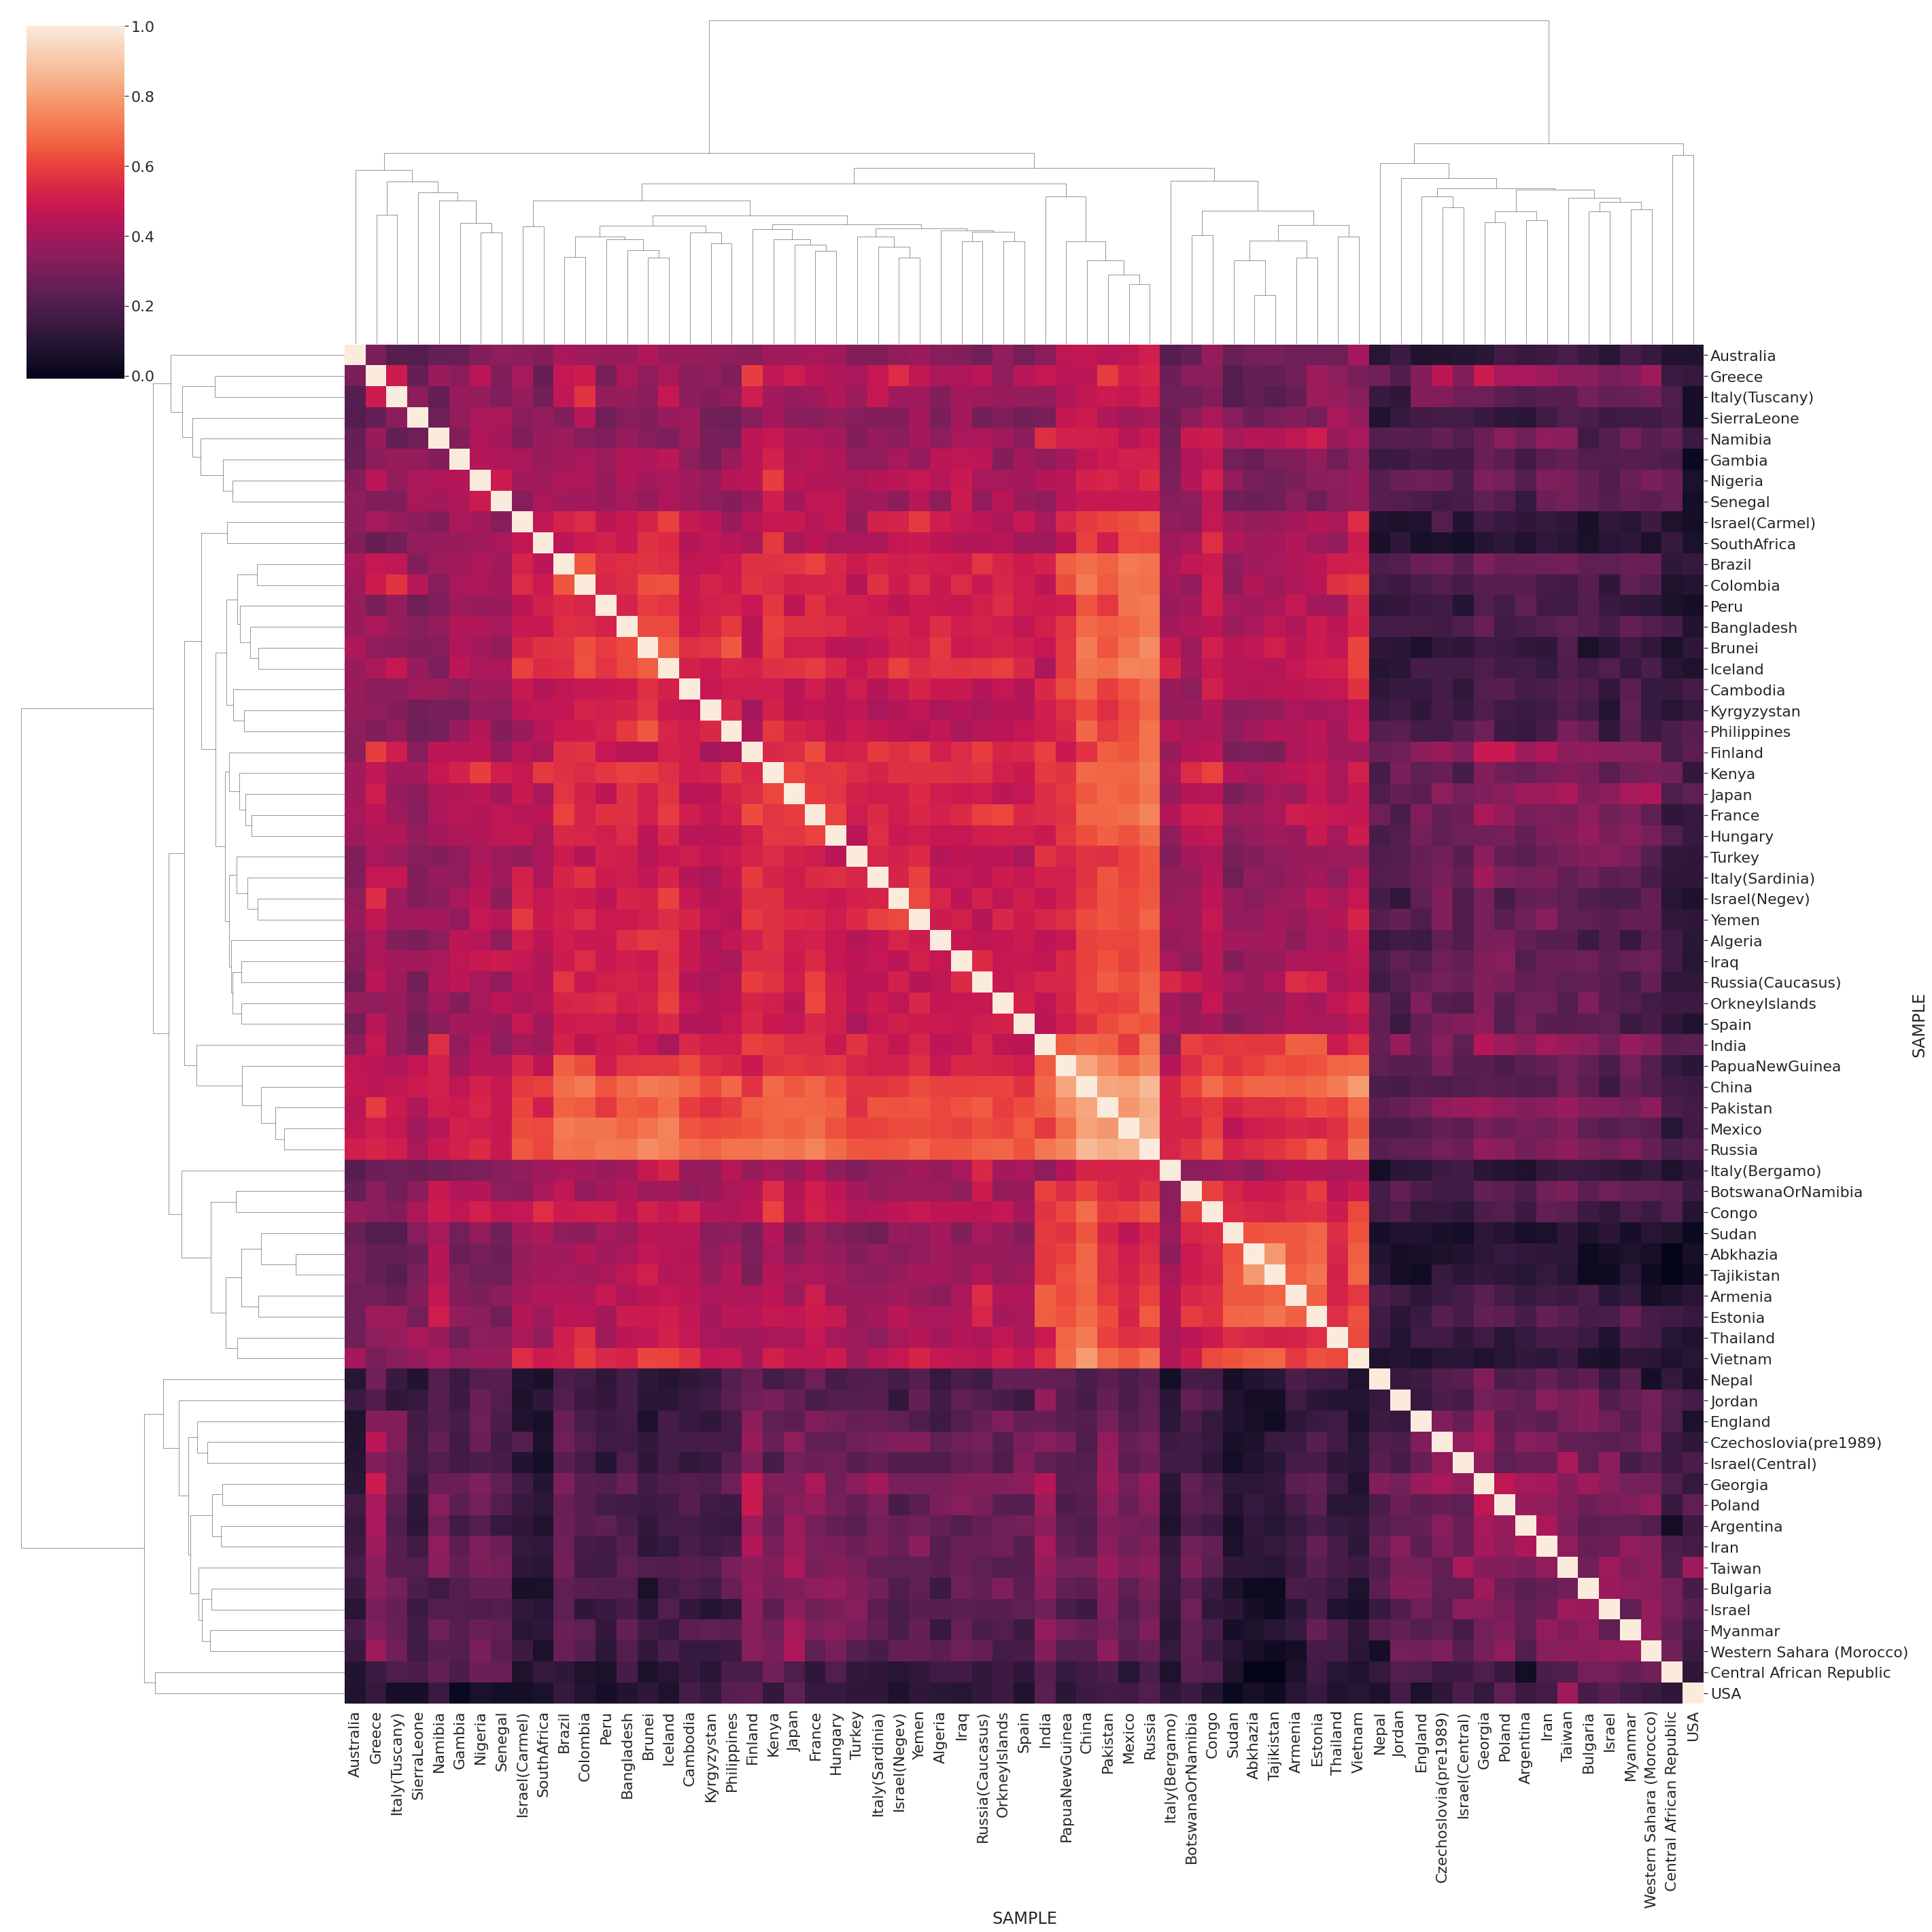

In [93]:
seaborn.set(font_scale=2)
corrmatrix = df.T.corr(method='pearson')
seaborn.clustermap(corrmatrix, figsize=(40,40))#, row_colors=row_colors, row_cluster=True, figsize=(40,40))


In [26]:


from scipy import stats
#final_cnv = final_cnv.iloc[new]
final = qdnaseq_pvt.iloc[:,4:284]
counts = final
counts = counts.fillna(2)

#counts = counts[counts.columns.intersection(counts_a.columns)]

#counts = counts.drop(columns=['LP6005592-DNA_G03',
#                     'LP6005443-DNA_E10',
#                     'LP6005442-DNA_E04'])

counts = counts.T
counts = counts.sort_index()
counts

0     1     2     3     4     5     6     7     8     9     ...  \
SAMPLE                                                                    ...   
SAMEA3302611   2.0   2.0   2.0   2.0   2.0   2.0   2.0   0.0   2.0   2.0  ...   
SAMEA3302612   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3302613   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3302614   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3302615   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
SAMEA3302904   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3302906   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3302908   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3302911   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
SAMEA3449877   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   

              1598  1599  1600  1601  1602  1603  1604  1605  1606  1607  
SAMPLE                                                                    
SAMEA3302611   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
SAMEA3302612   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
SAMEA3302613   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
SAMEA3302614   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
SAMEA3302615   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
SAMEA3302904   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   1.0   2.0  
SAMEA3302906   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   1.0  
SAMEA3302908   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
SAMEA3302911   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  
SAMEA3449877   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  

[244 rows x 1608 columns]

In [27]:
#IMPUTATION

features = anotation.merge(counts, left_index=True, right_index=True)
features = features.loc[:,["7-Gender","10-Region", "11-Country",]]
features = features.sort_index()
features 

7-Gender    10-Region 11-Country
SAMEA3302611        F     EastAsia      China
SAMEA3302612        M  WestEurasia       Iran
SAMEA3302613        F     EastAsia    Vietnam
SAMEA3302614        F     EastAsia      China
SAMEA3302615        M     EastAsia      China
...               ...          ...        ...
SAMEA3302904        F      America     Mexico
SAMEA3302906        F     EastAsia      Japan
SAMEA3302908        M      Oceania        USA
SAMEA3302911        M    SouthAsia      Nepal
SAMEA3449877        M    SouthAsia   Pakistan

[244 rows x 3 columns]

<h2> PCA

In [28]:
#imputation and normalization 
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#X = imp.fit_transform(counts.T)
X = StandardScaler().fit_transform(counts)


#PCA
#pca = PCA(.95)
pca = PCA(n_components=10)
pca_results = pca.fit_transform(X)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3','component_4','component_5', 'component_6', 'component_7','component_8', 'component_9','component_10'],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca 

7-Gender    10-Region 11-Country  component_1  component_2  \
SAMEA3302611        F     EastAsia      China    -0.376193    -6.529474   
SAMEA3302612        M  WestEurasia       Iran    -4.687483     2.283493   
SAMEA3302613        F     EastAsia    Vietnam     3.368838    -5.913963   
SAMEA3302614        F     EastAsia      China    -0.844653    -3.956796   
SAMEA3302615        M     EastAsia      China    -4.490333     2.747055   
...               ...          ...        ...          ...          ...   
SAMEA3302904        F      America     Mexico    -0.188785    -2.383837   
SAMEA3302906        F     EastAsia      Japan     3.073486    -5.351326   
SAMEA3302908        M      Oceania        USA    -4.631543     2.355224   
SAMEA3302911        M    SouthAsia      Nepal    -3.824811     2.204866   
SAMEA3449877        M    SouthAsia   Pakistan    -5.249286     2.047873   

              component_3  component_4  component_5  component_6  component_7  \
SAMEA3302611    -1.122016    -4.119407     3.610367     0.079812    -1.813193   
SAMEA3302612    -1.222639    -0.221983    -0.755816    -0.378645    -0.300699   
SAMEA3302613    -0.993306    -0.828532    -1.147581     0.842847    -0.822131   
SAMEA3302614    -0.276932    -3.320229     1.136062    -0.943285    -1.550319   
SAMEA3302615    -0.632554    -0.063552    -0.672736    -0.675209     0.003474   
...                   ...          ...          ...          ...          ...   
SAMEA3302904    -1.084652     1.318005    -2.375124     0.295744    -0.180813   
SAMEA3302906    -1.067801     0.363996    -1.486045     0.719046    -0.438581   
SAMEA3302908    -1.471094     0.333295    -1.287727    -1.355498    -0.587563   
SAMEA3302911    -0.738895     0.177816    -0.876165    -0.022717     0.146824   
SAMEA3449877    -1.408486    -1.083172    -0.824343    -0.654640    -0.102349   

              component_8  component_9  component_10  
SAMEA3302611     0.666031    -4.323236     -2.036031  
SAMEA3302612    -0.568918     0.095913      0.238725  
SAMEA3302613     0.527710    -0.959477     -0.211773  
SAMEA3302614    -0.741951    -3.362839     -1.509480  
SAMEA3302615    -0.364283     0.324408      0.659161  
...                   ...          ...           ...  
SAMEA3302904    -0.029506    -0.109296      0.182757  
SAMEA3302906     0.174205    -0.562010      0.182163  
SAMEA3302908    -1.136893    -0.541082      0.111537  
SAMEA3302911    -0.193285     0.157069      0.031789  
SAMEA3449877    -0.089758    -1.731677      0.813747  

[244 rows x 13 columns]

In [29]:
pca.explained_variance_ratio_


array([0.02617864, 0.01629948, 0.0126108 , 0.01110483, 0.01084337,
       0.0103586 , 0.01007336, 0.00974608, 0.00934609, 0.00916034])

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
WestEurasia        M       Iran    -4.687483     2.283493    -1.222639   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
EastAsia           M      China    -4.490333     2.747055    -0.632554   
...              ...        ...          ...          ...          ...   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   
Oceania            M        USA    -4.631543     2.355224    -1.471094   
SouthAsia          M      Nepal    -3.824811     2.204866    -0.738895   
SouthAsia          M   Pakistan    -5.249286     2.047873    -1.408486   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
WestEurasia        M       Iran    -4.687483     2.283493    -1.222639   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
EastAsia           M      China    -4.490333     2.747055    -0.632554   
...              ...        ...          ...          ...          ...   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   
Oceania            M        USA    -4.631543     2.355224    -1.471094   
SouthAsia          M      Nepal    -3.824811     2.204866    -0.738895   
SouthAsia          M   Pakistan    -5.249286     2.047873    -1.408486   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
WestEurasia        M       Iran    -4.687483     2.283493    -1.222639   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
EastAsia           M      China    -4.490333     2.747055    -0.632554   
...              ...        ...          ...          ...          ...   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   
Oceania            M        USA    -4.631543     2.355224    -1.471094   
SouthAsia          M      Nepal    -3.824811     2.204866    -0.738895   
SouthAsia          M   Pakistan    -5.249286     2.047873    -1.408486   

             component_4  component_5

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
WestEurasia        M       Iran    -4.687483     2.283493    -1.222639   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
EastAsia           M      China    -4.490333     2.747055    -0.632554   
...              ...        ...          ...          ...          ...   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   
Oceania            M        USA    -4.631543     2.355224    -1.471094   
SouthAsia          M      Nepal    -3.824811     2.204866    -0.738895   
SouthAsia          M   Pakistan    -5.249286     2.047873    -1.408486   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
WestEurasia        M       Iran    -4.687483     2.283493    -1.222639   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
EastAsia           M      China    -4.490333     2.747055    -0.632554   
...              ...        ...          ...          ...          ...   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   
Oceania            M        USA    -4.631543     2.355224    -1.471094   
SouthAsia          M      Nepal    -3.824811     2.204866    -0.738895   
SouthAsia          M   Pakistan    -5.249286     2.047873    -1.408486   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
WestEurasia        M       Iran    -4.687483     2.283493    -1.222639   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
EastAsia           M      China    -4.490333     2.747055    -0.632554   
...              ...        ...          ...          ...          ...   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   
Oceania            M        USA    -4.631543     2.355224    -1.471094   
SouthAsia          M      Nepal    -3.824811     2.204866    -0.738895   
SouthAsia          M   Pakistan    -5.249286     2.047873    -1.408486   

             component_4  component_5

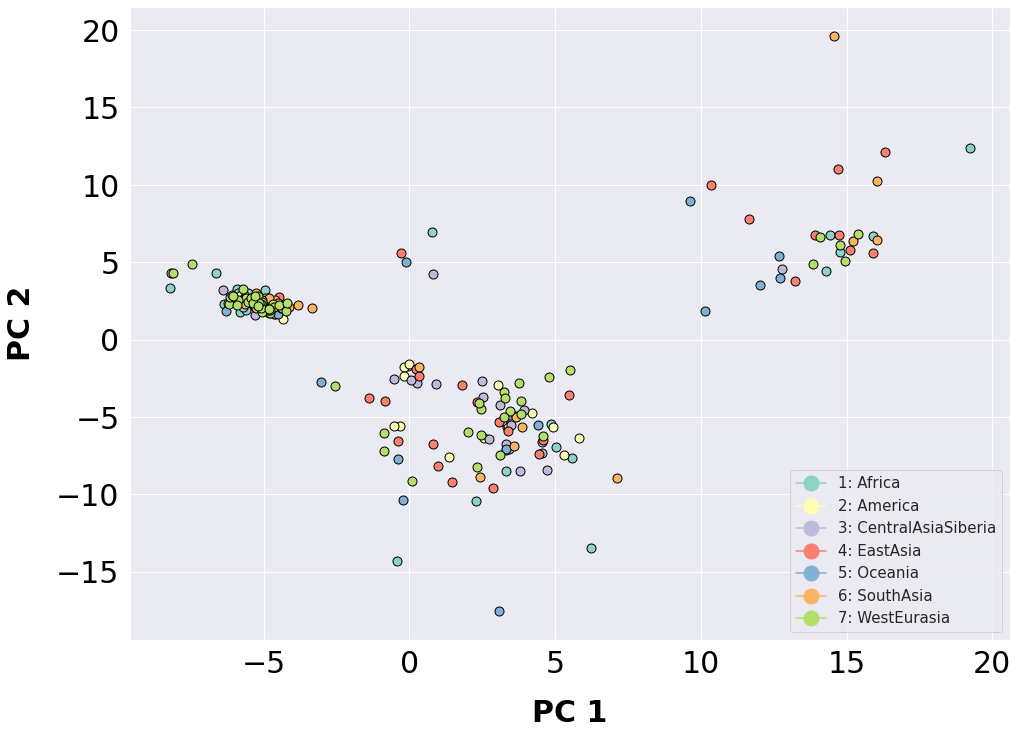

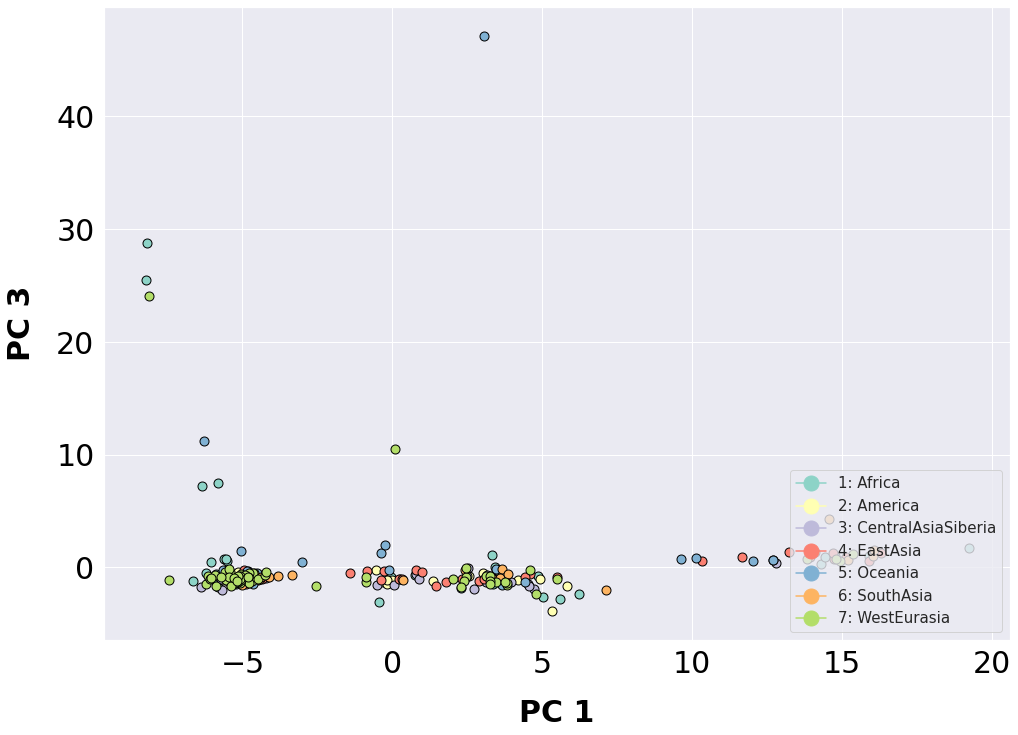

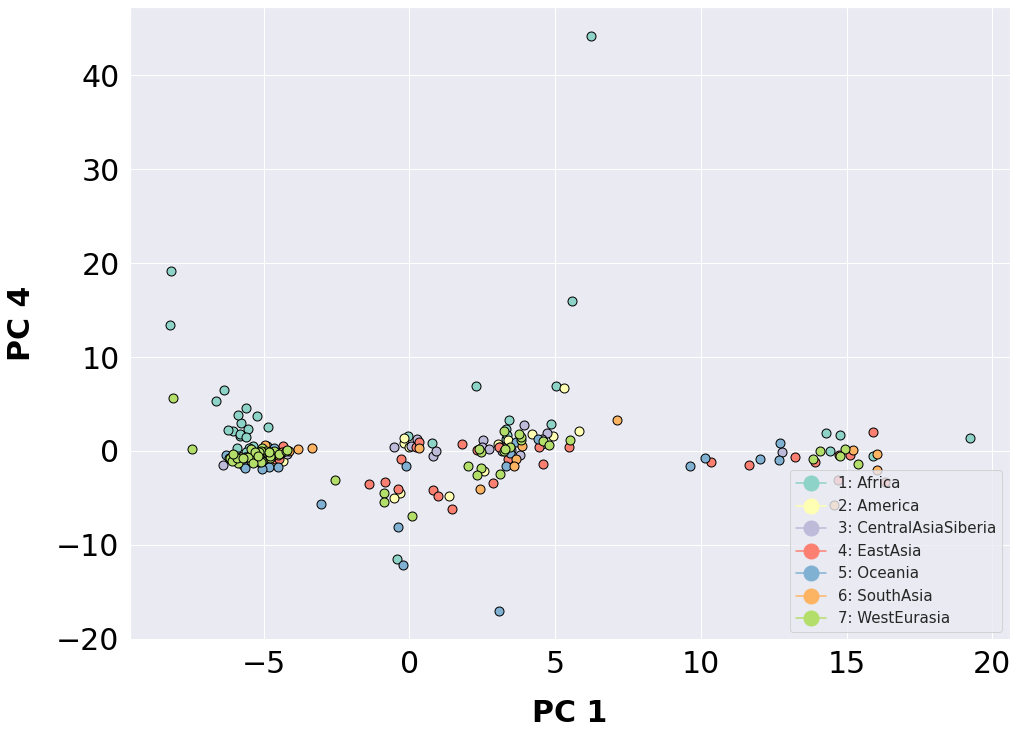

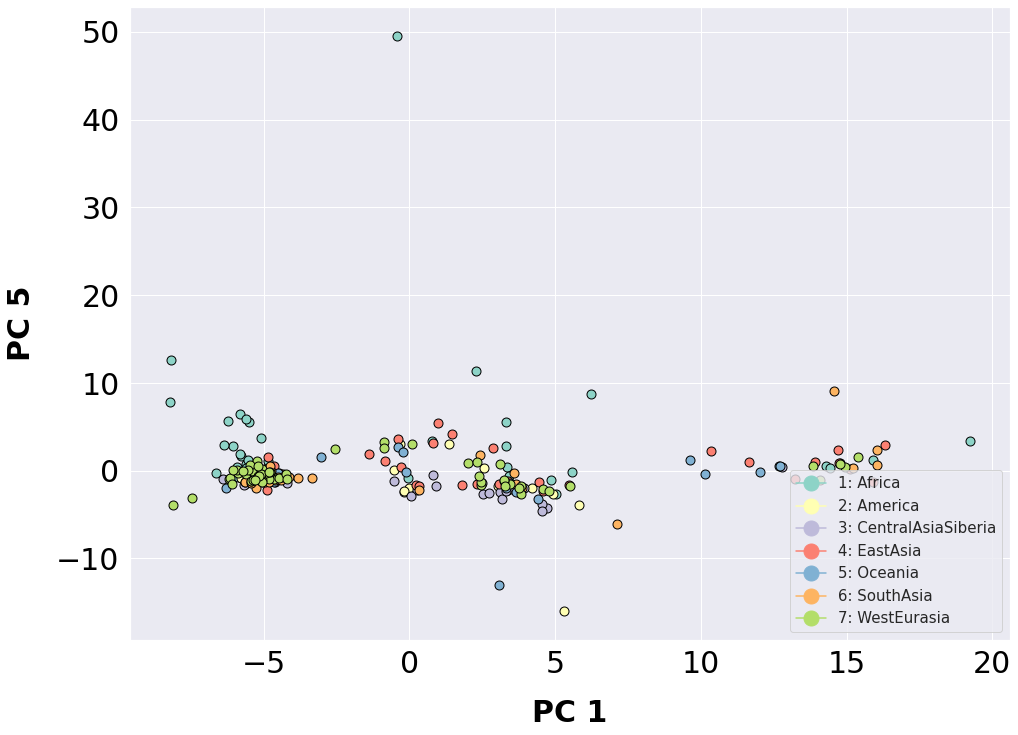

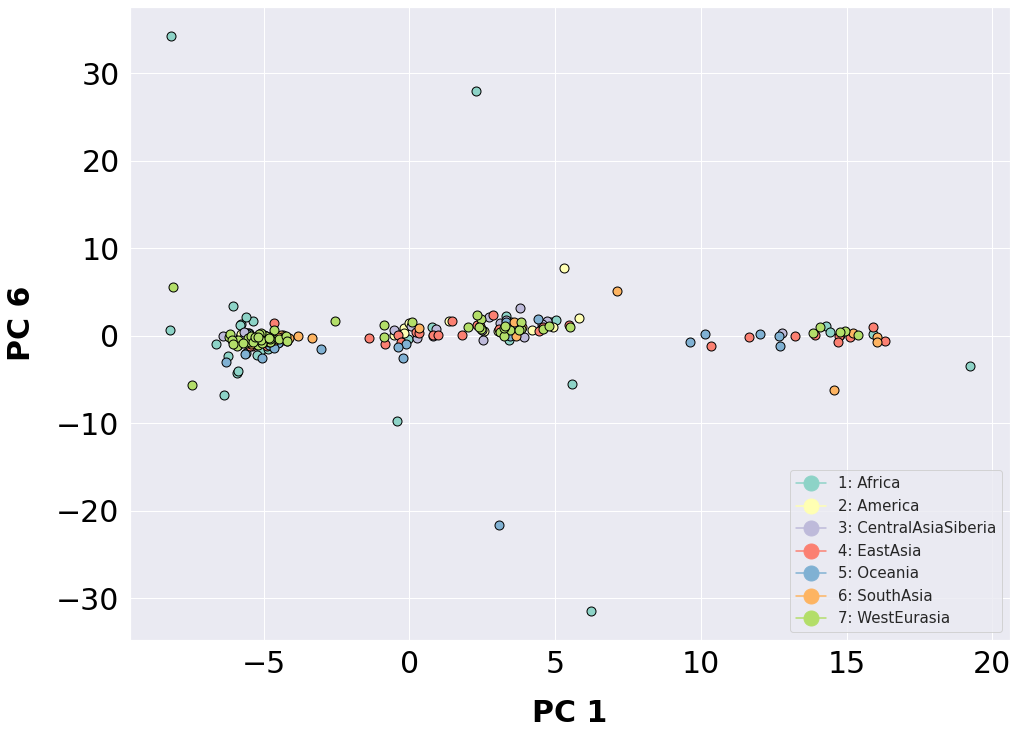

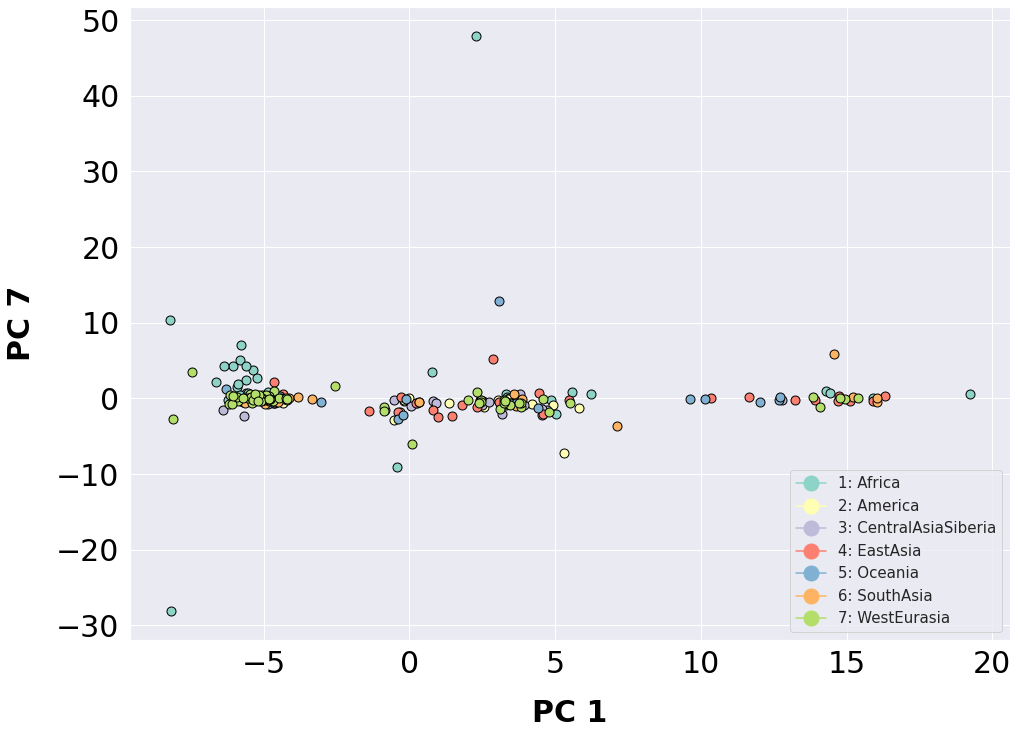

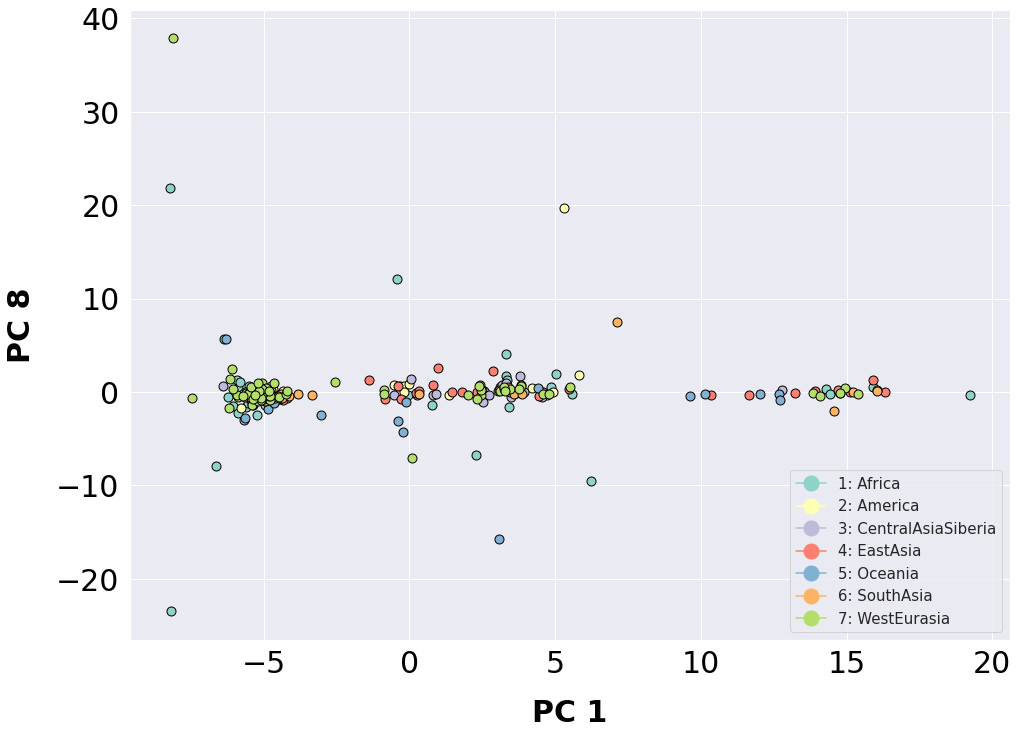

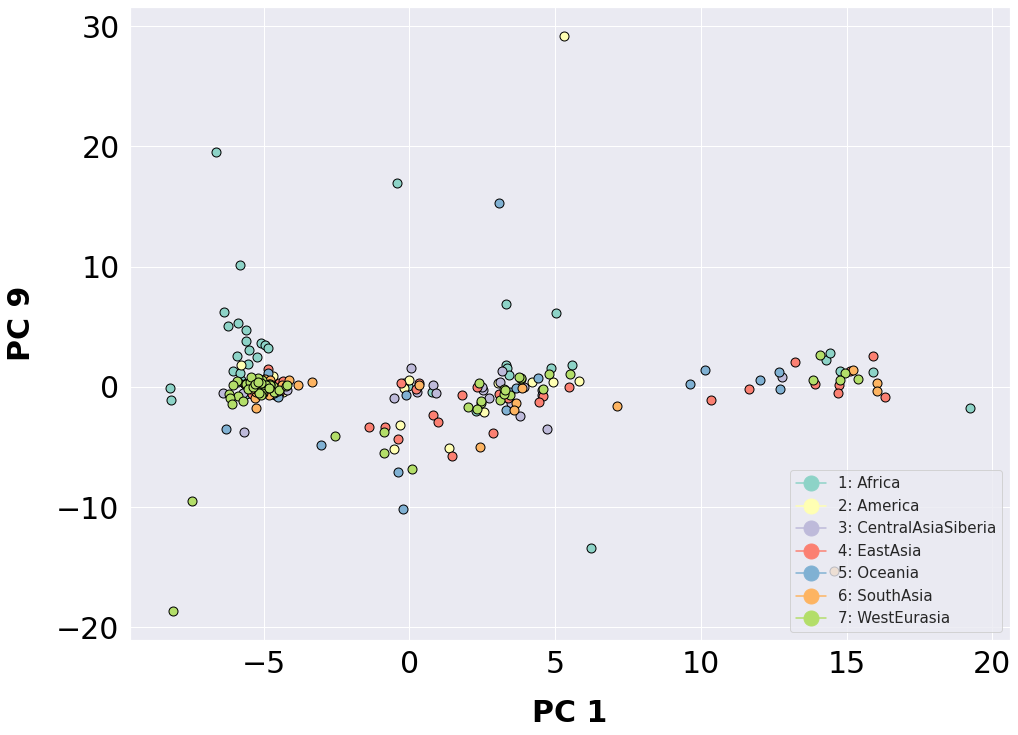

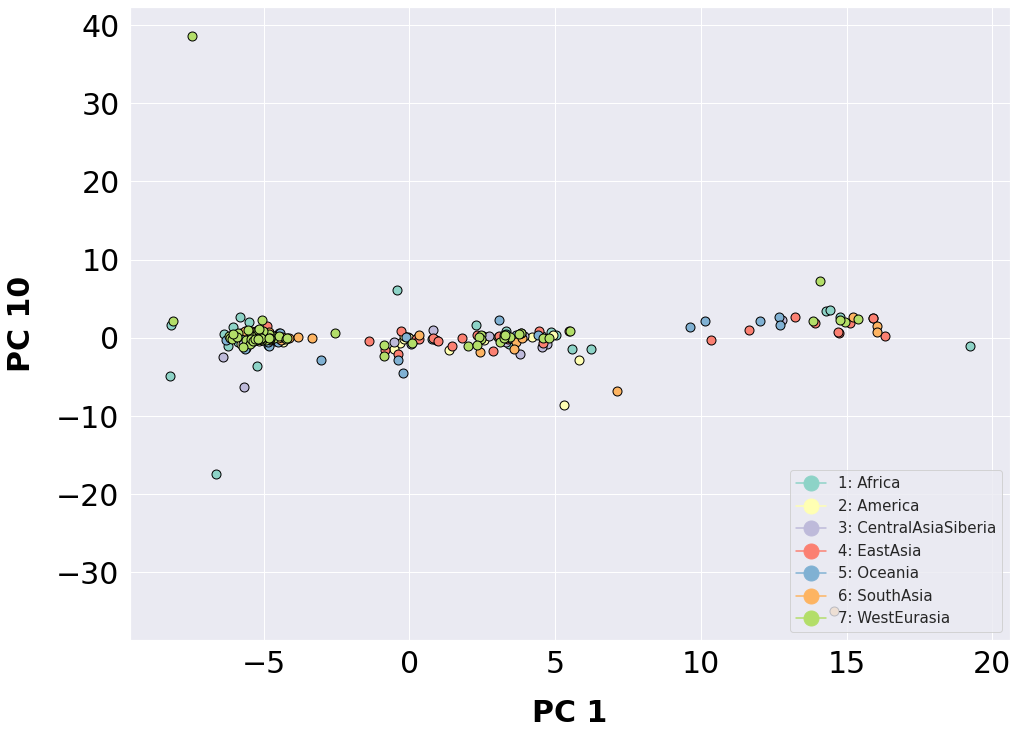

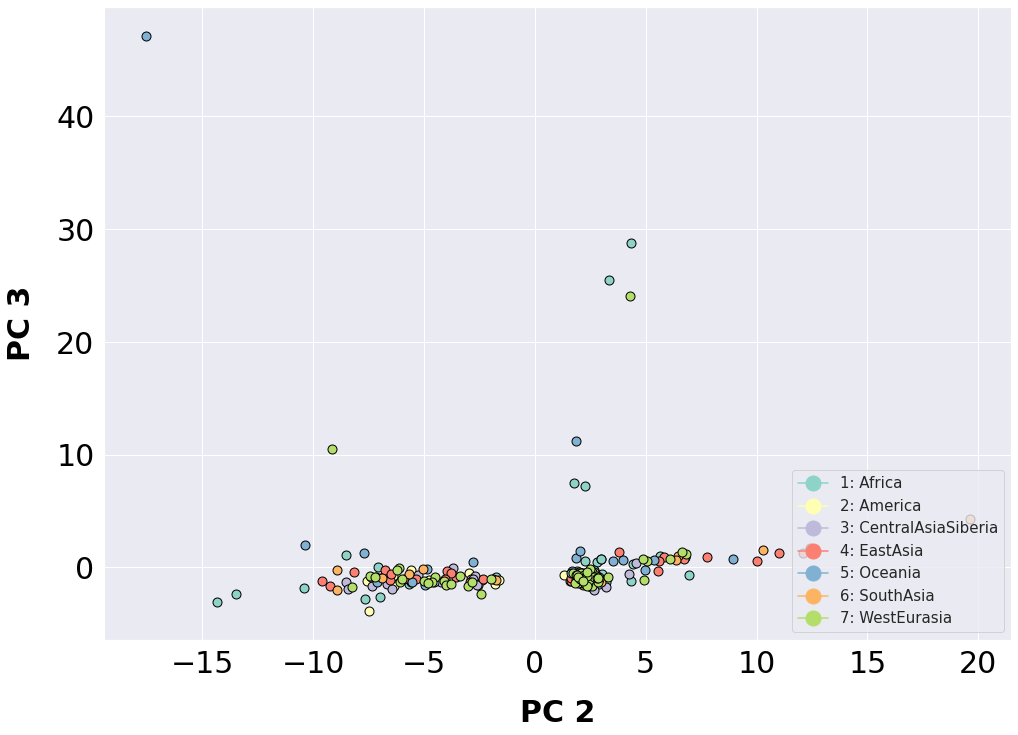

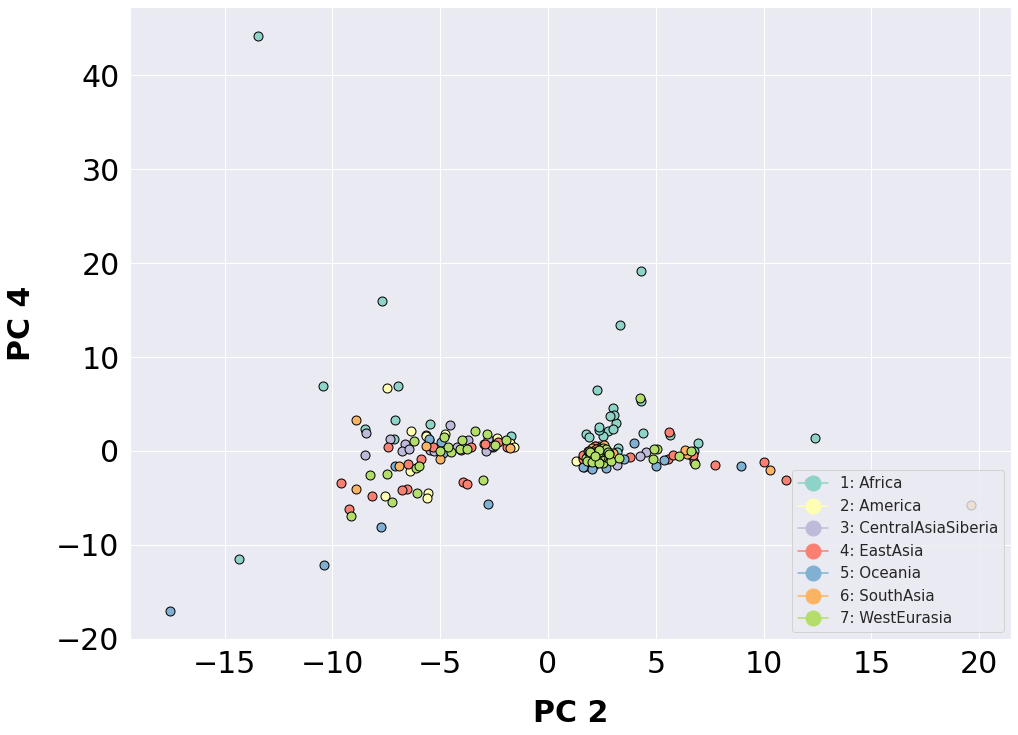

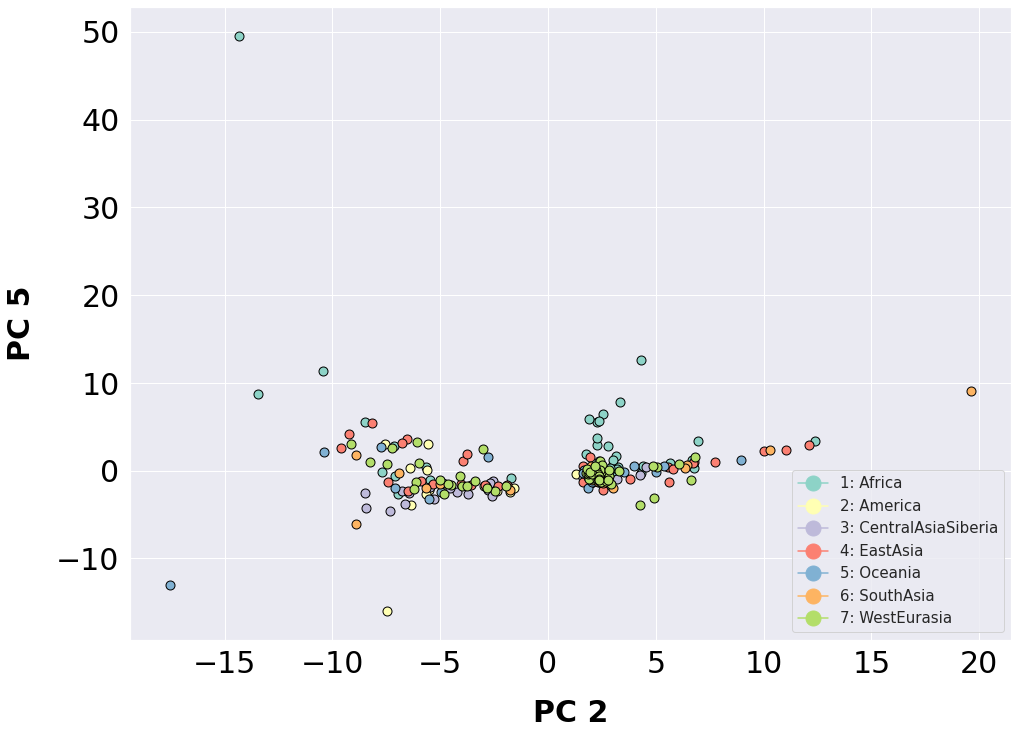

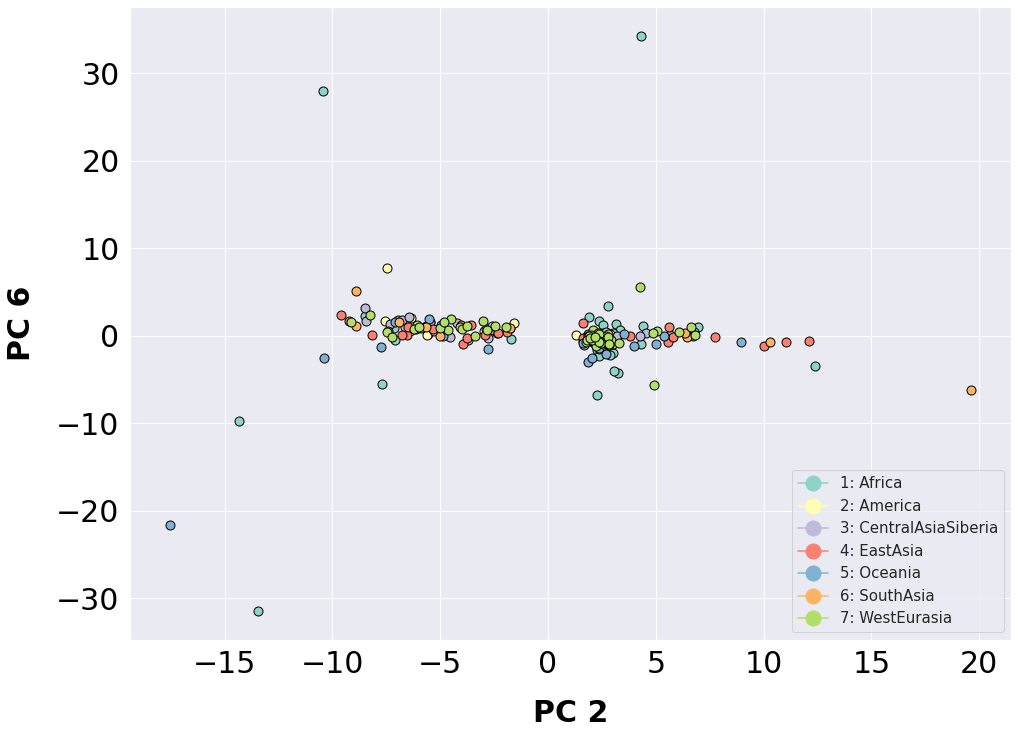

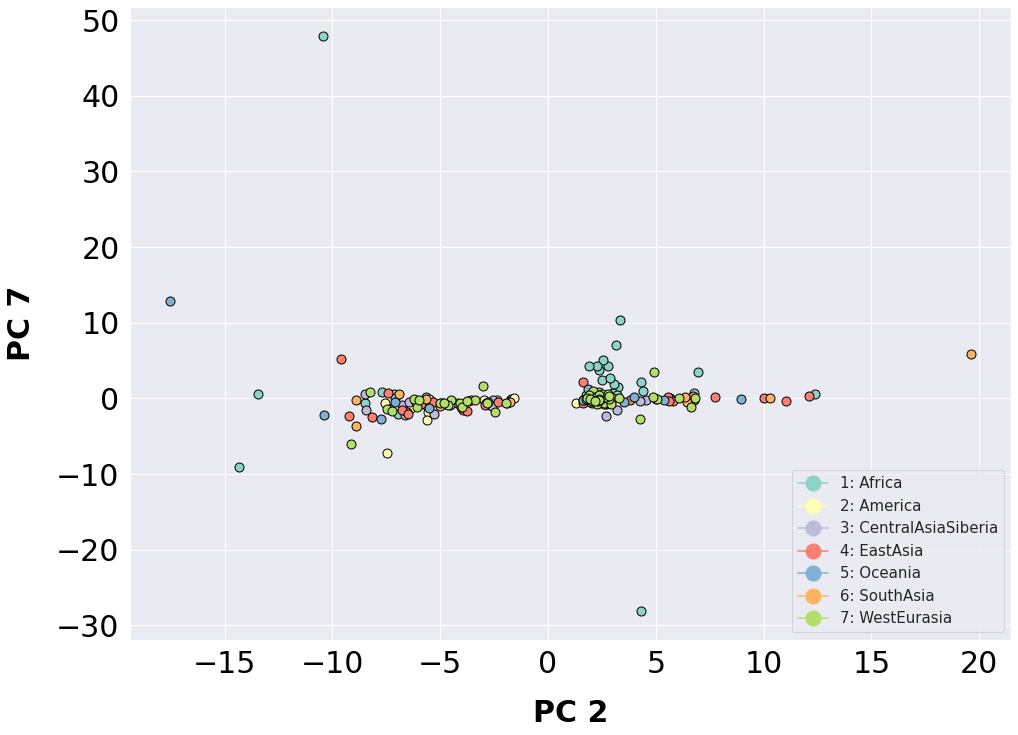

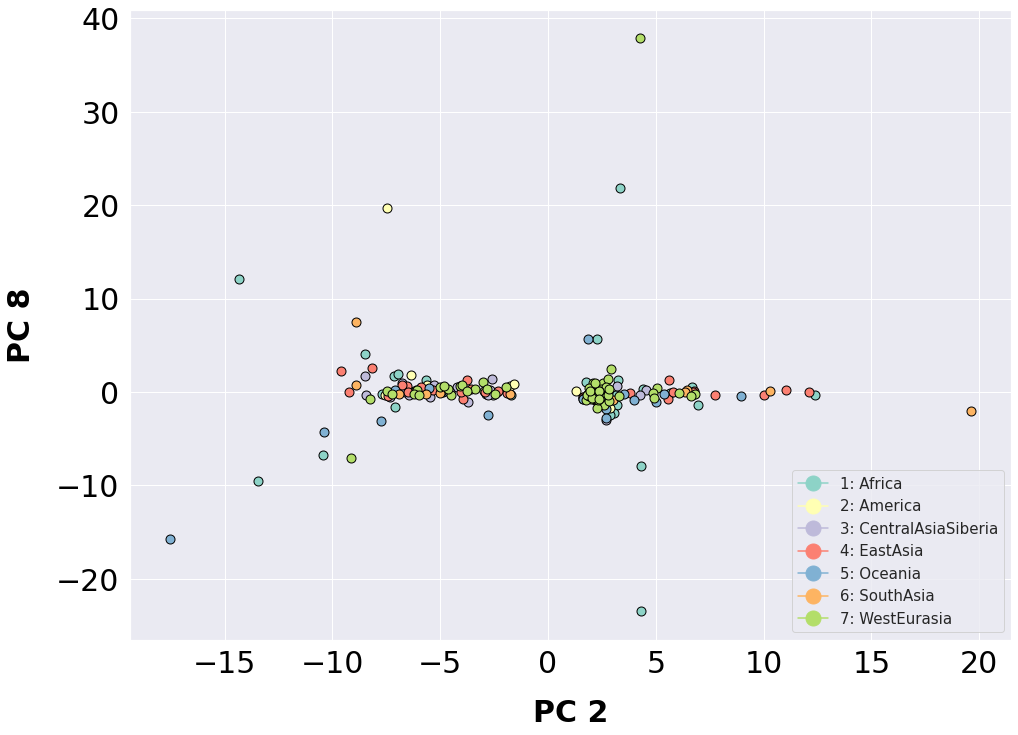

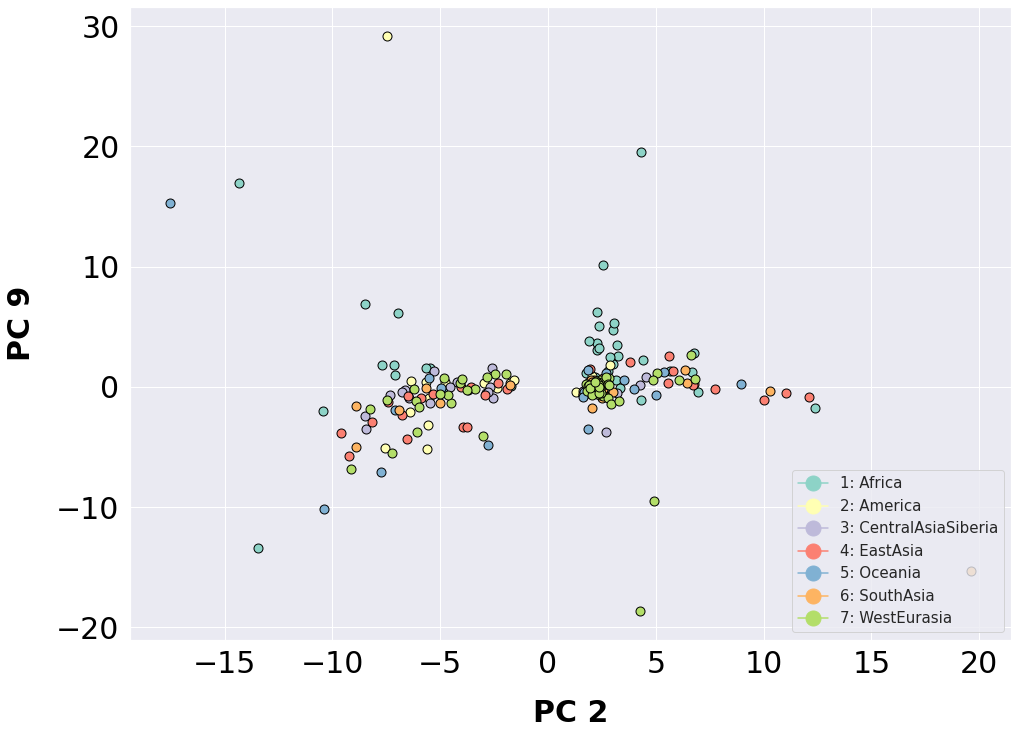

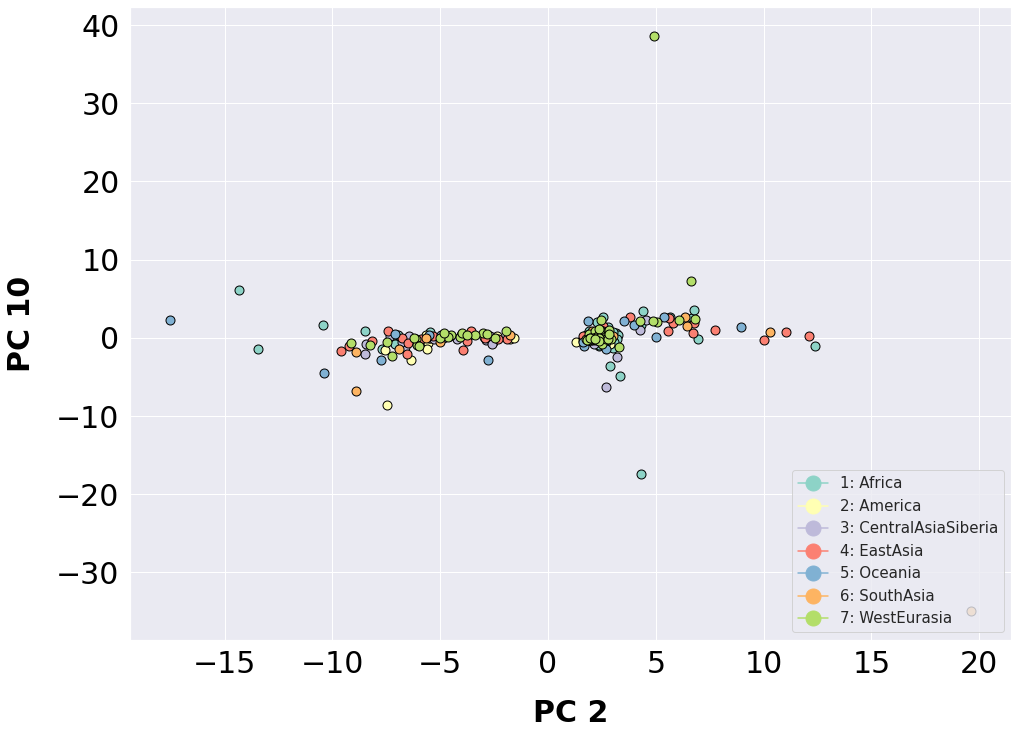

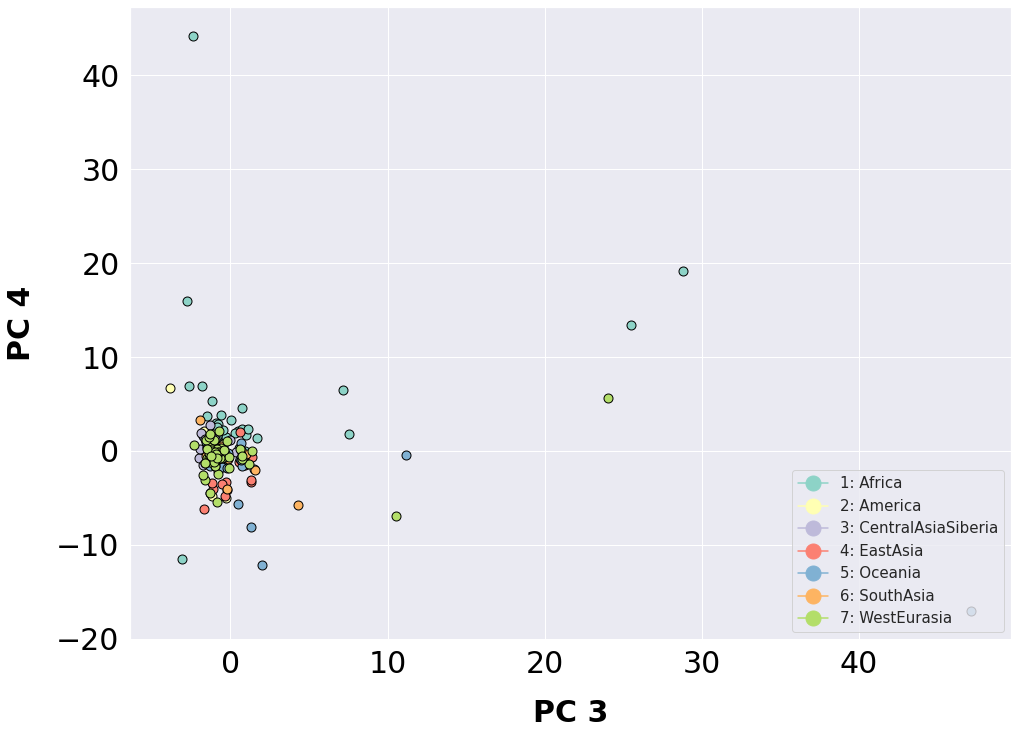

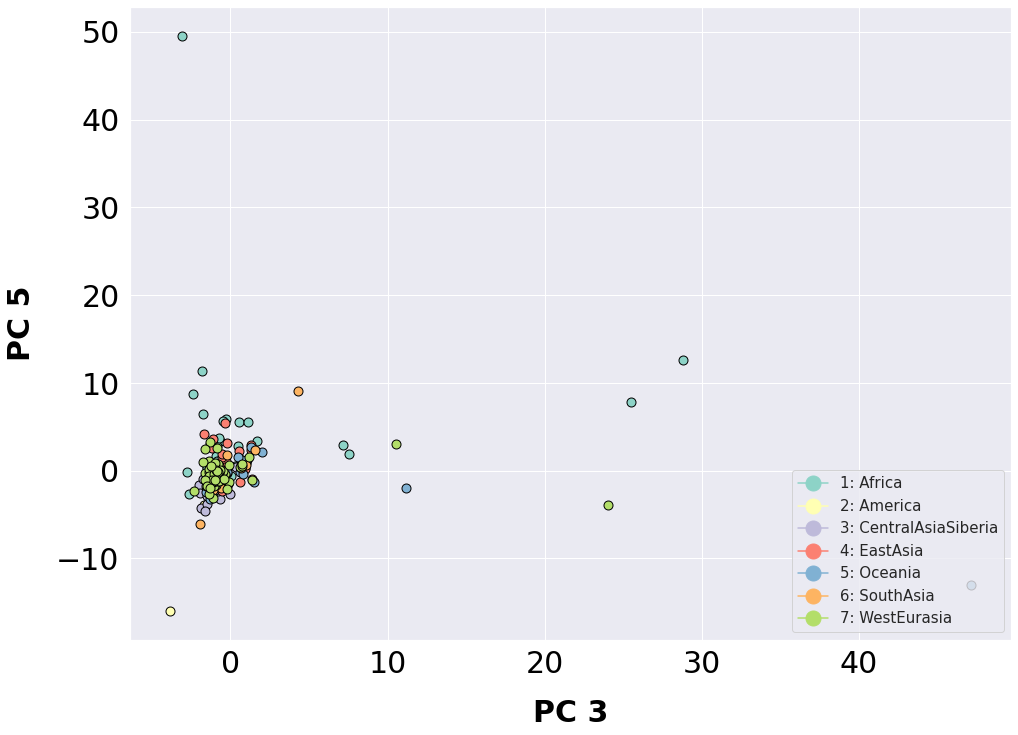

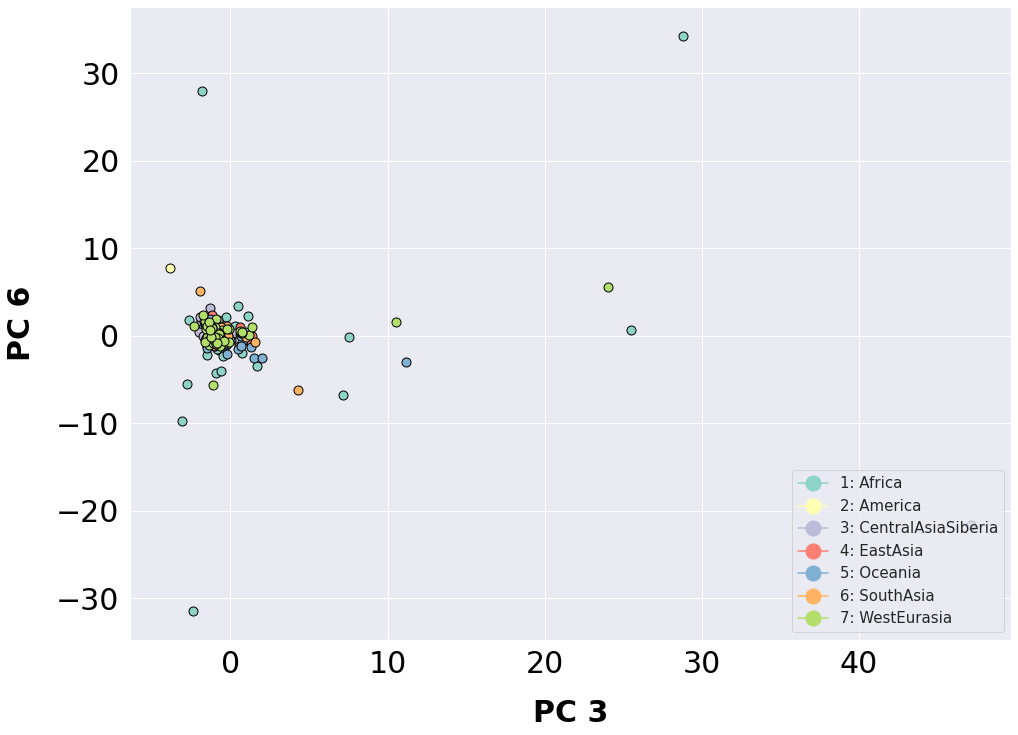

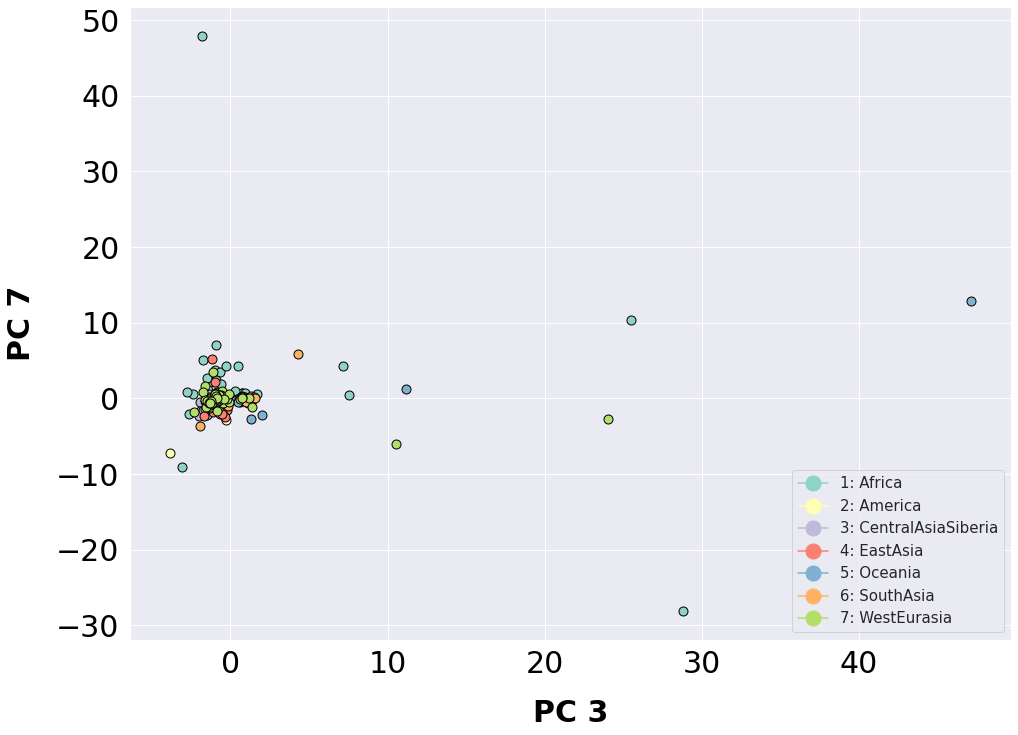

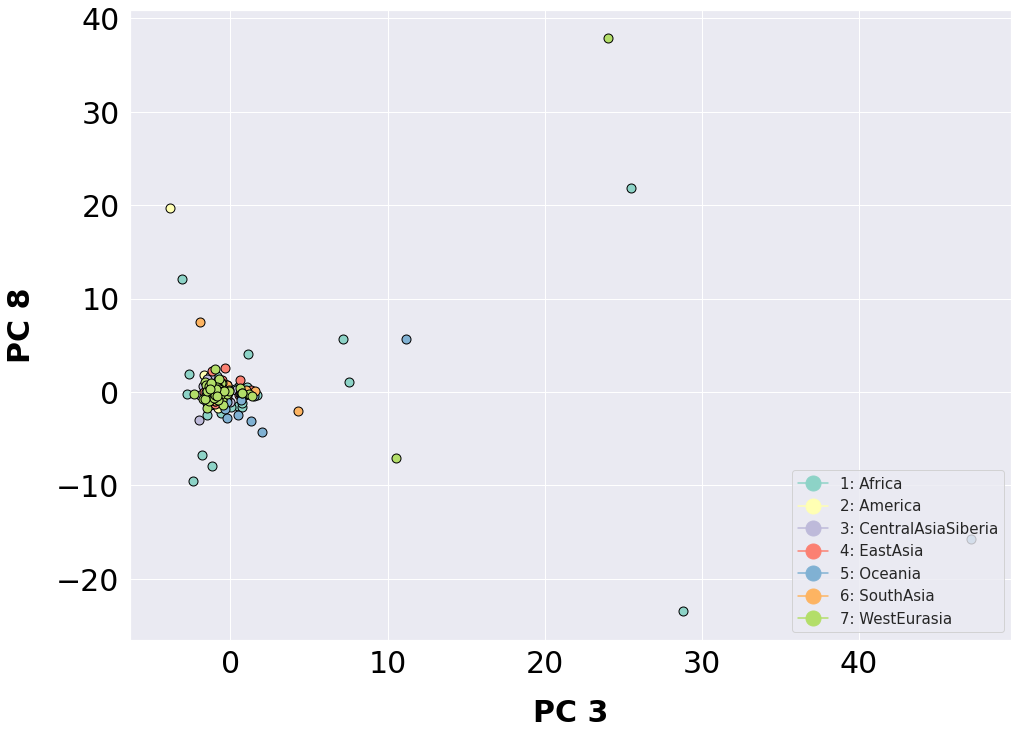

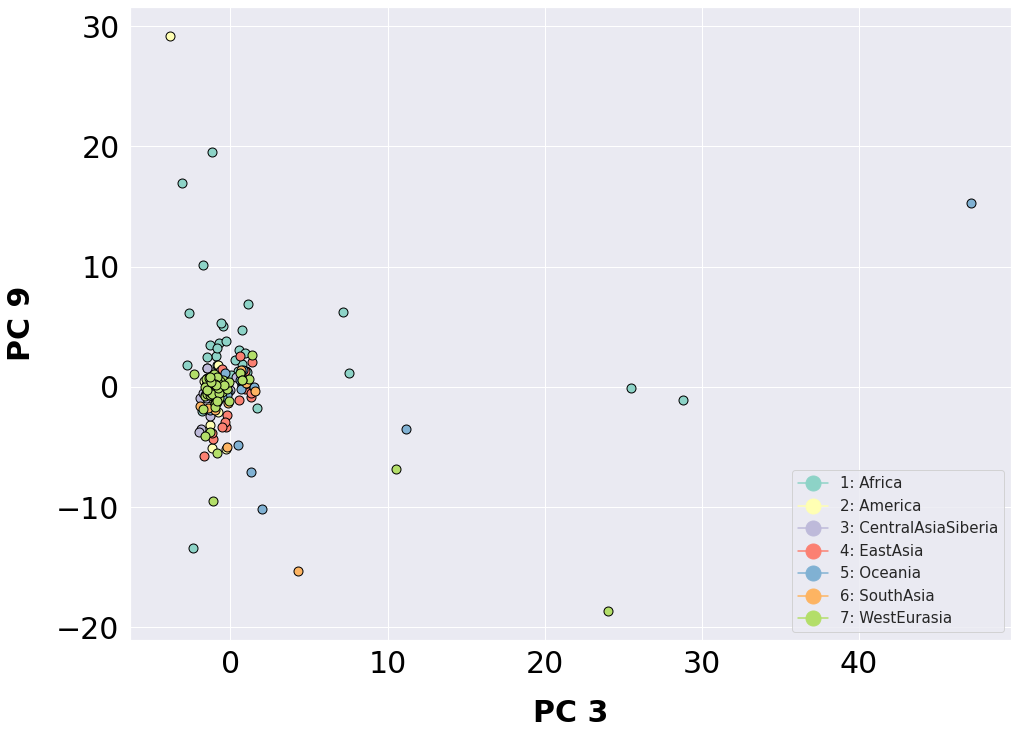

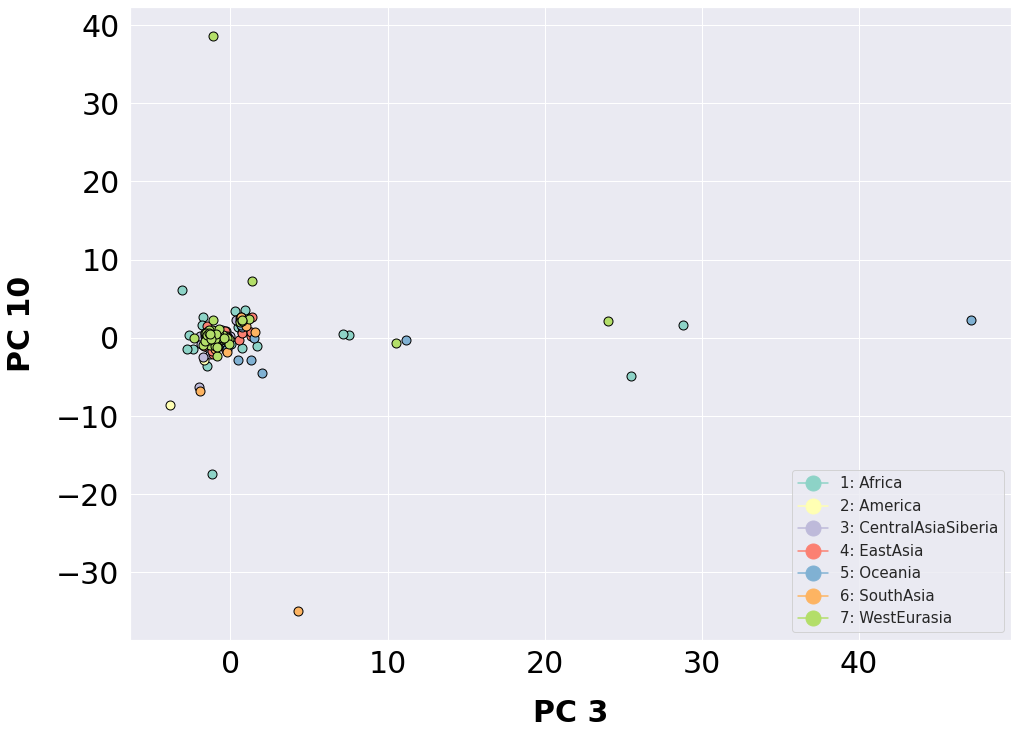

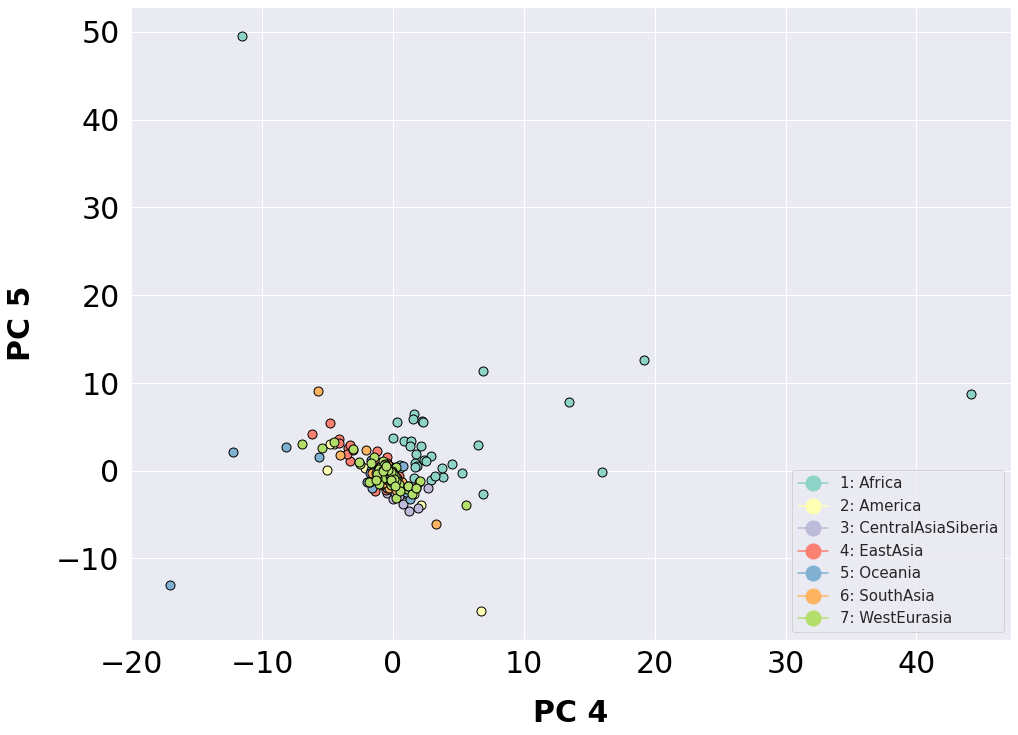

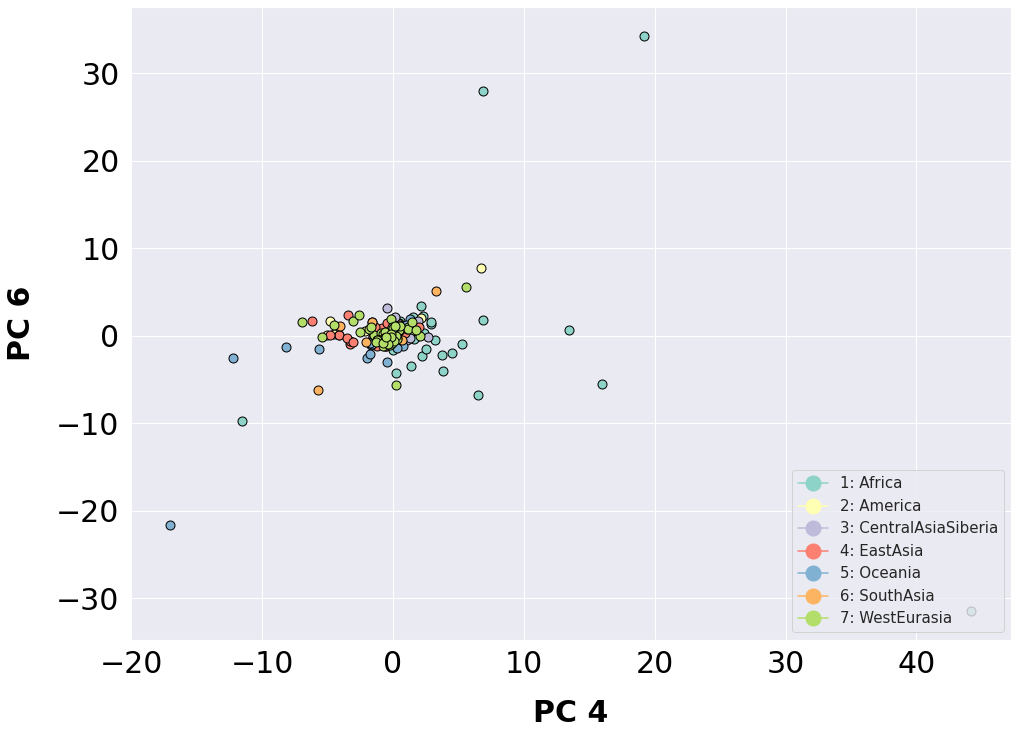

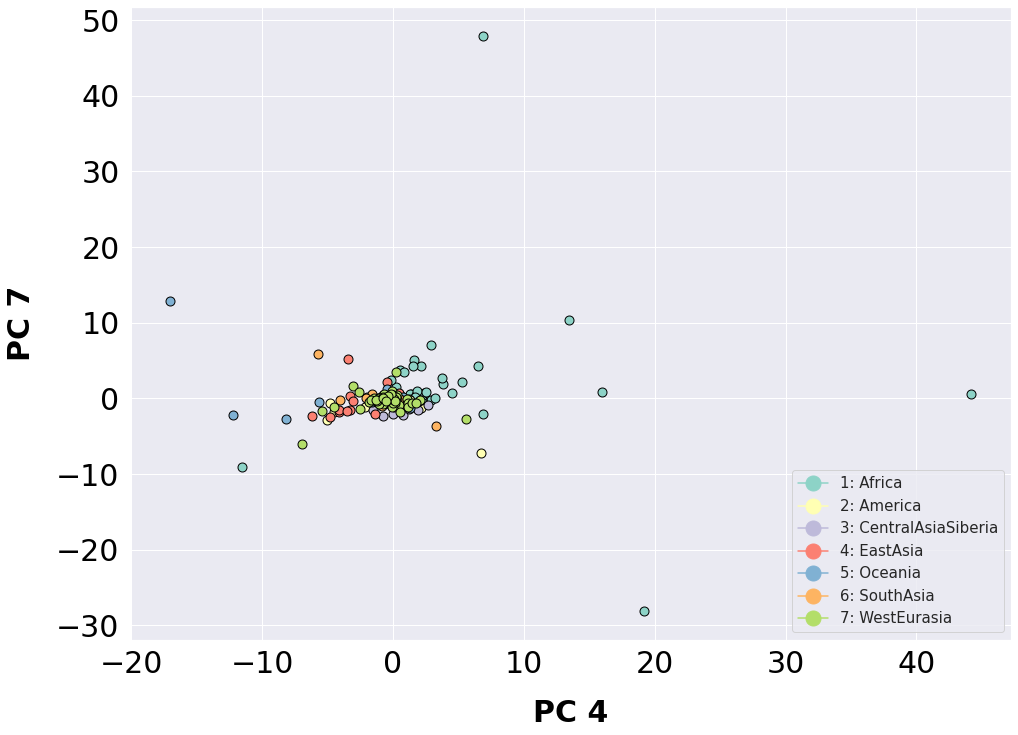

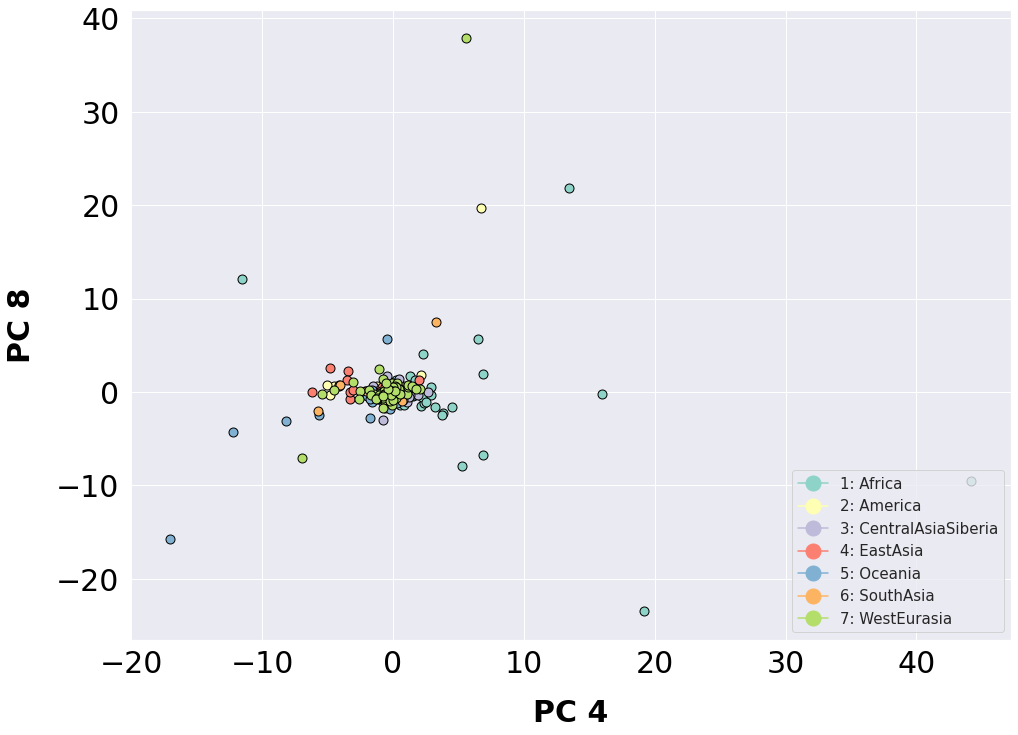

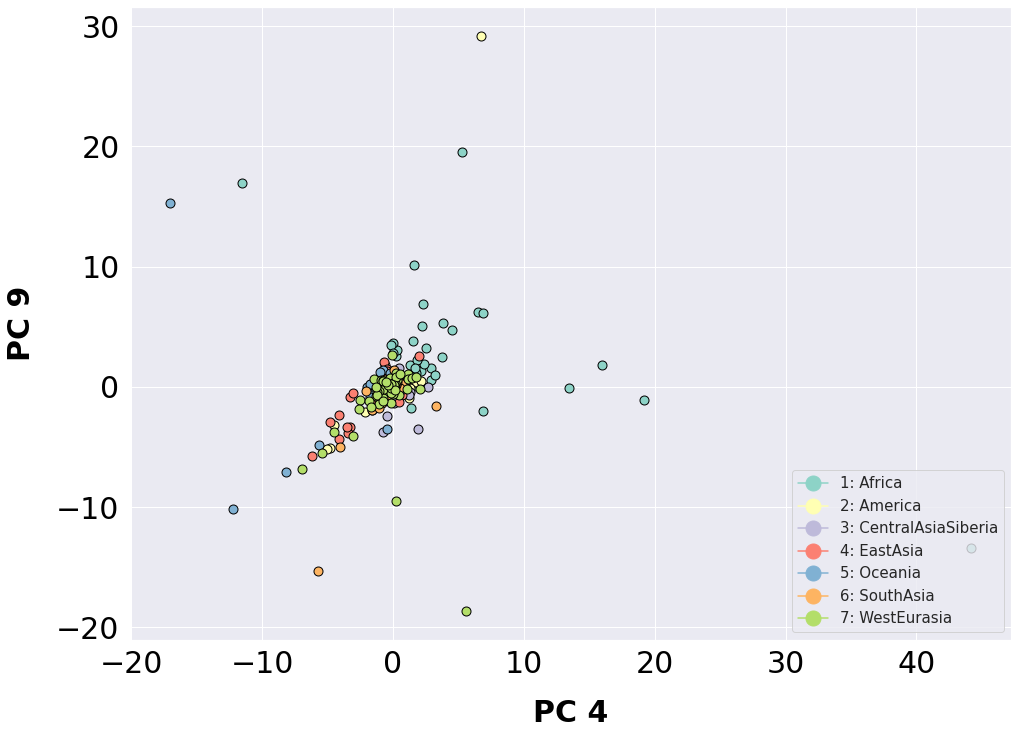

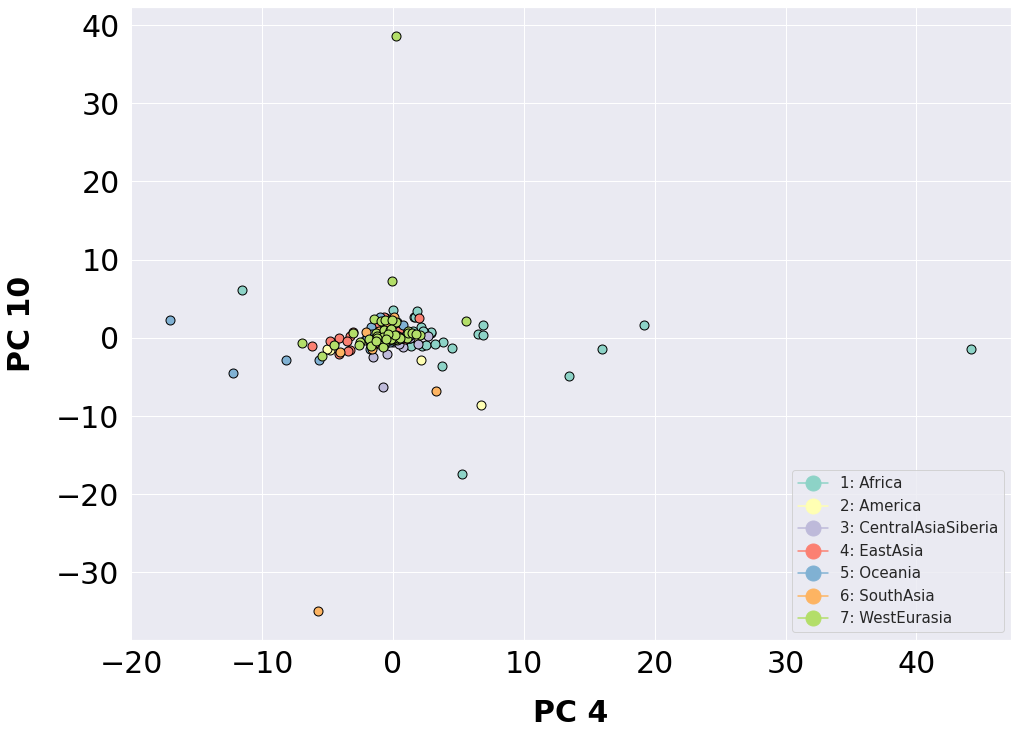

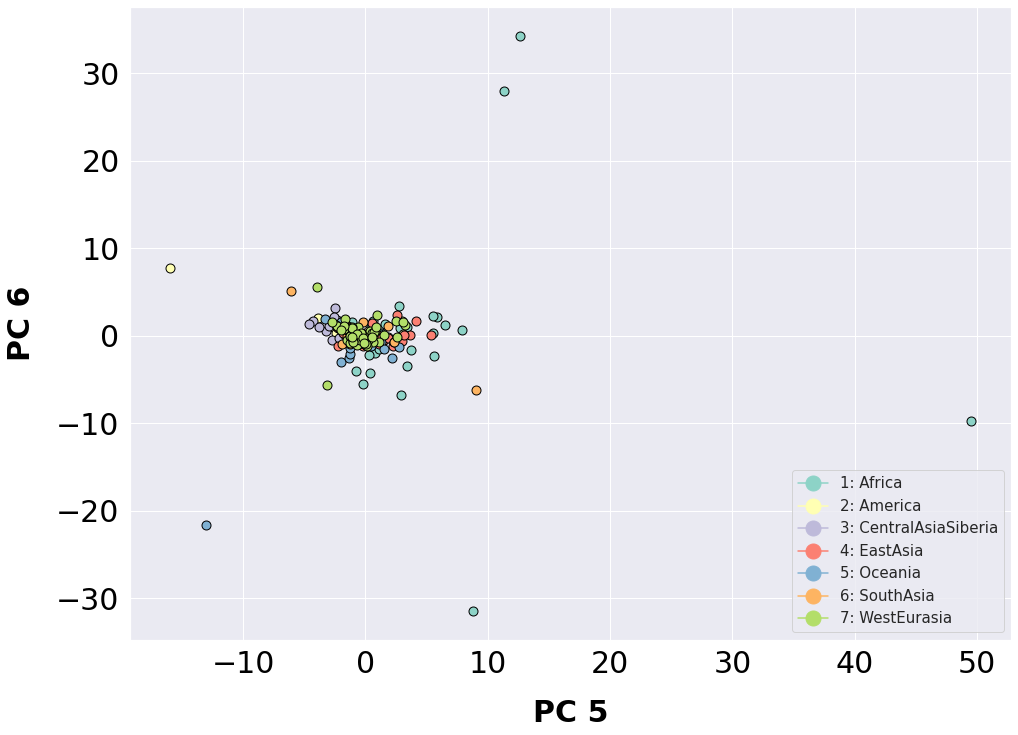

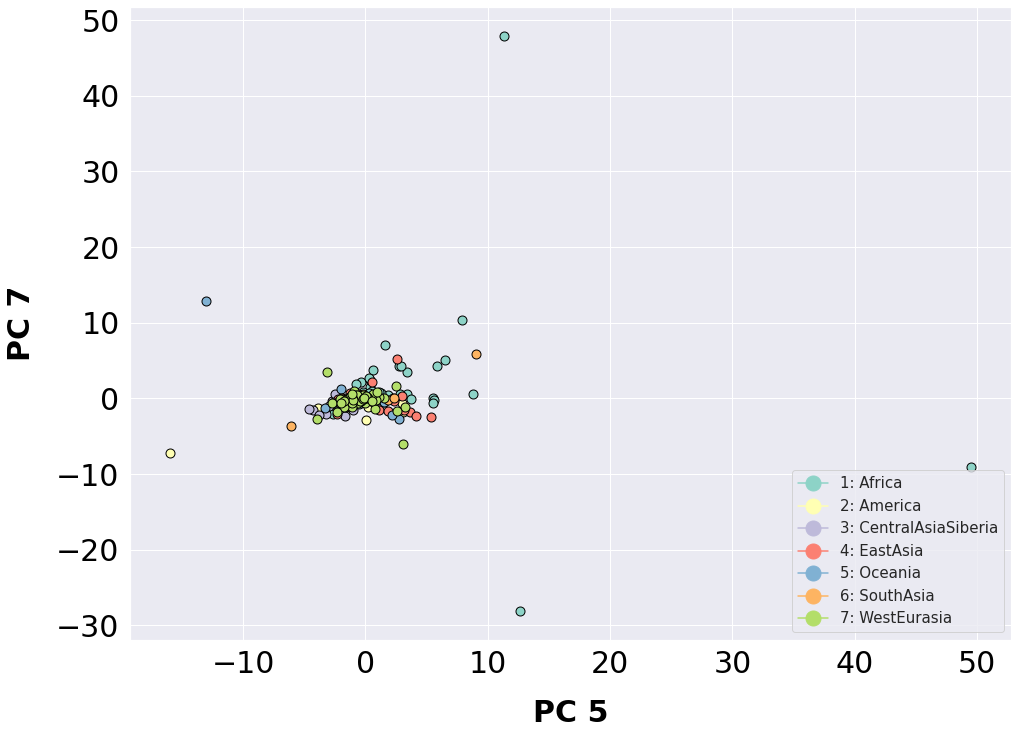

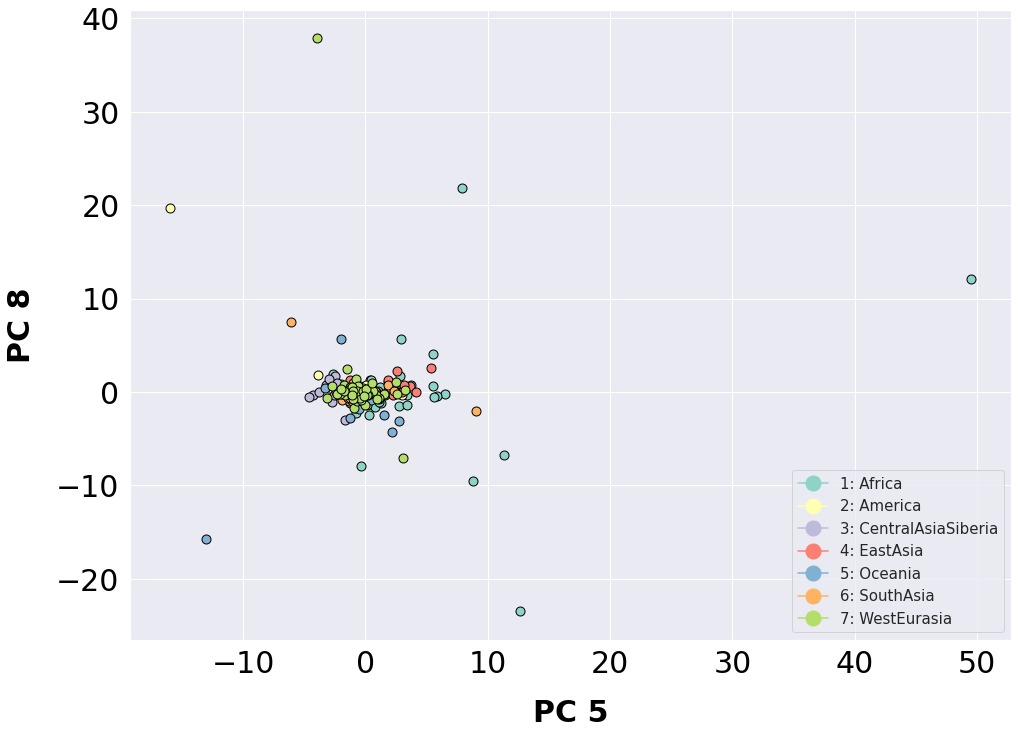

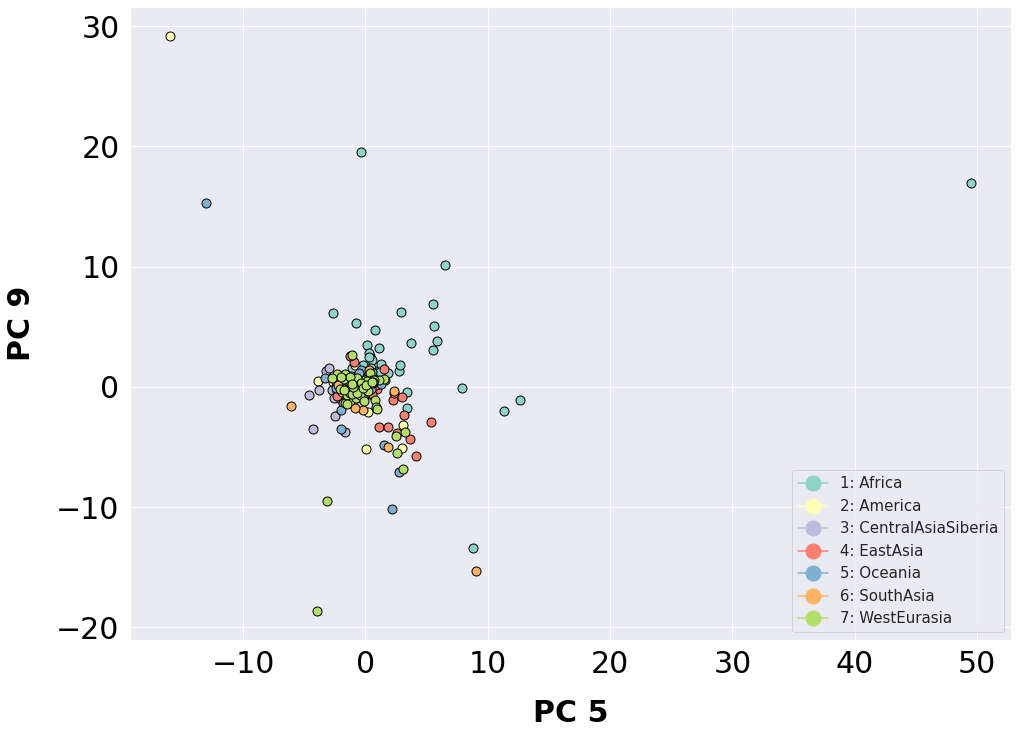

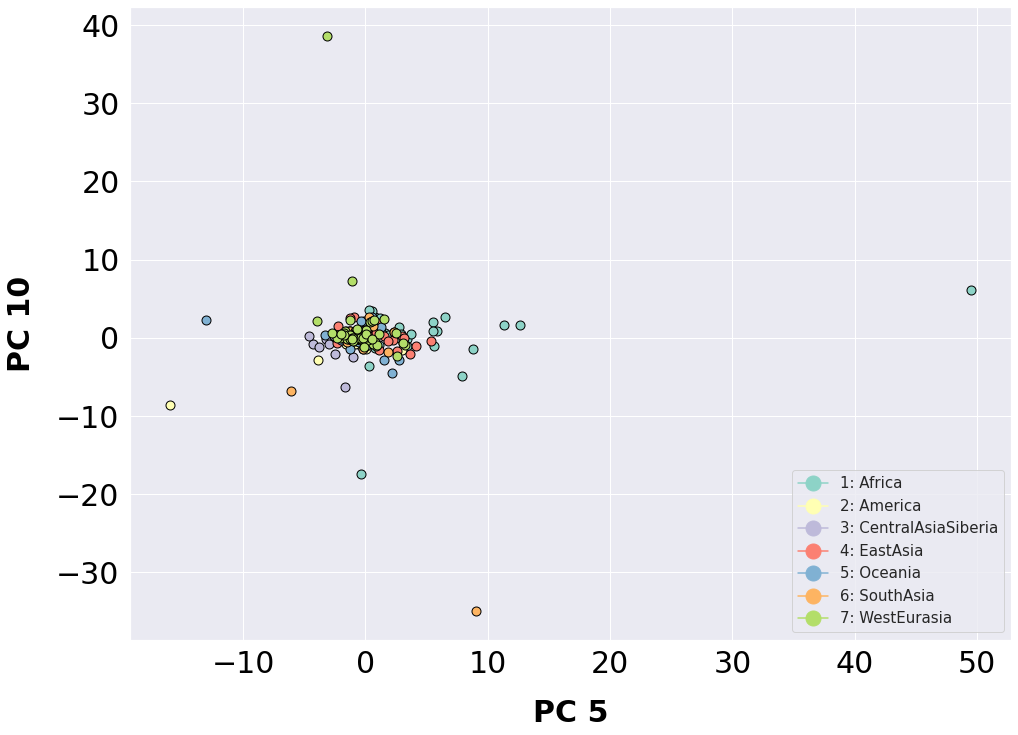

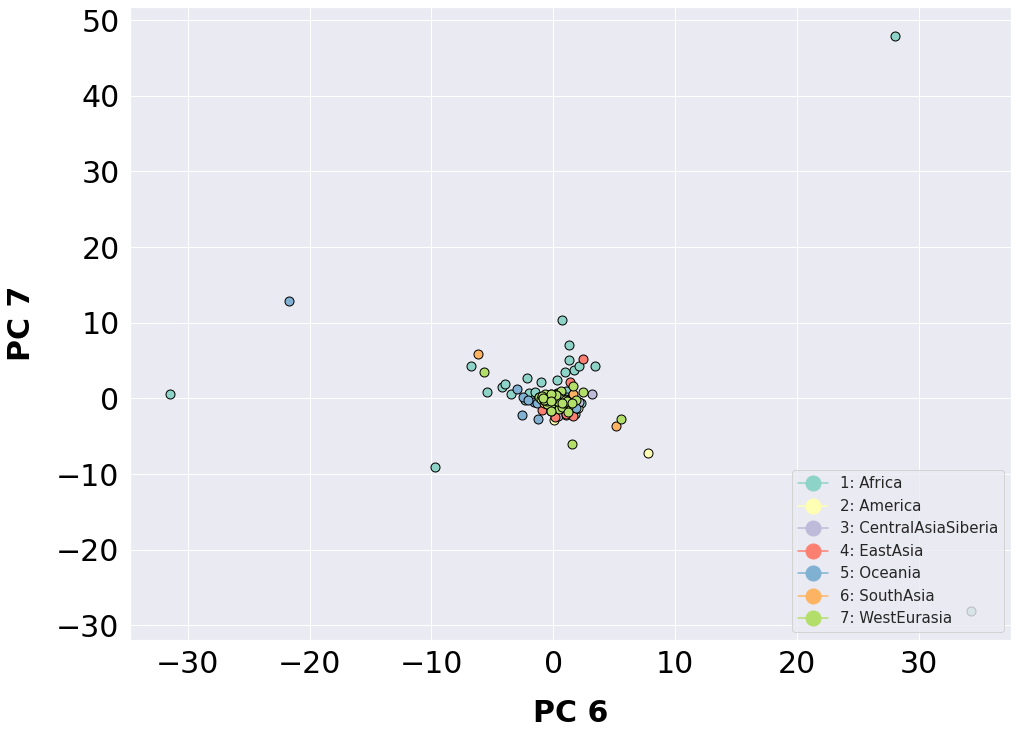

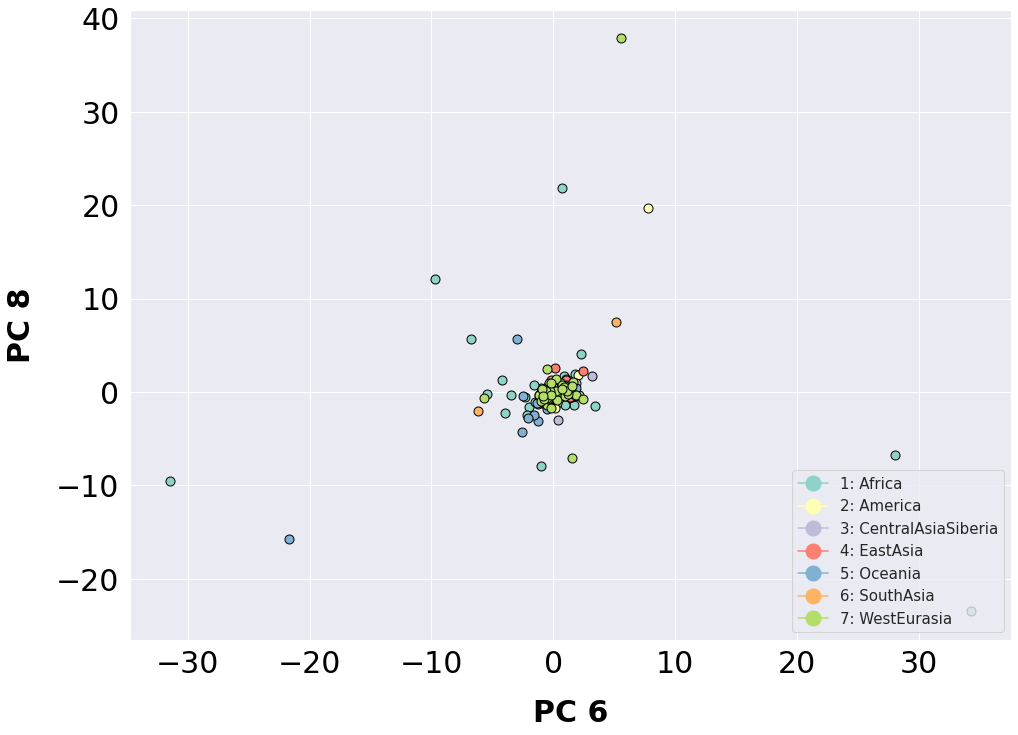

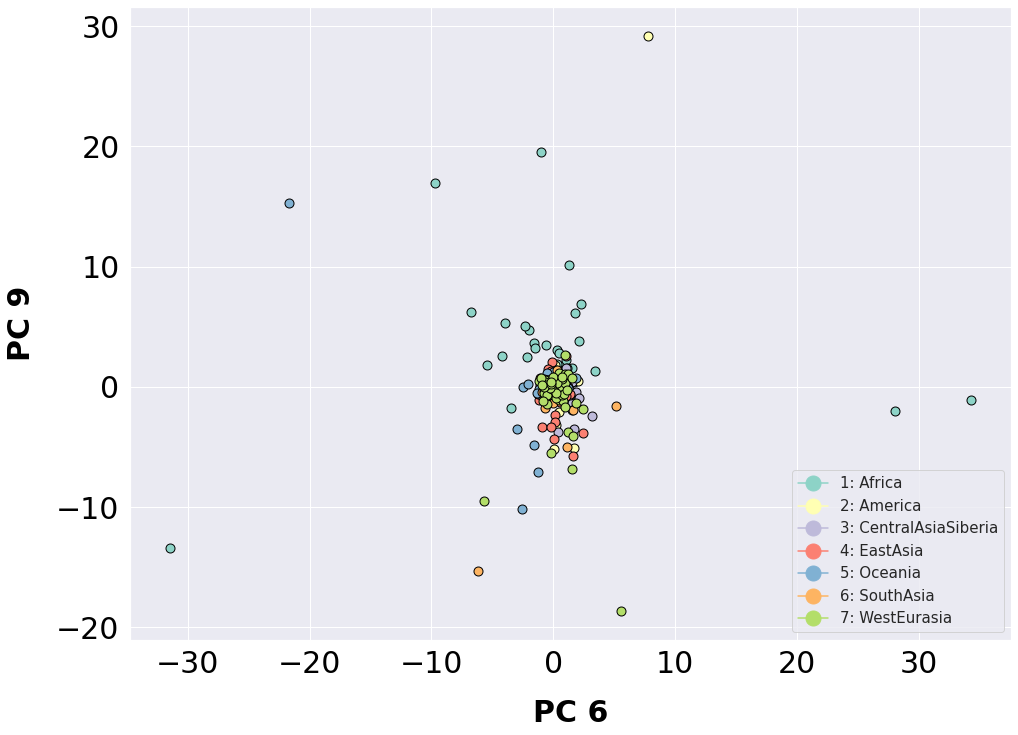

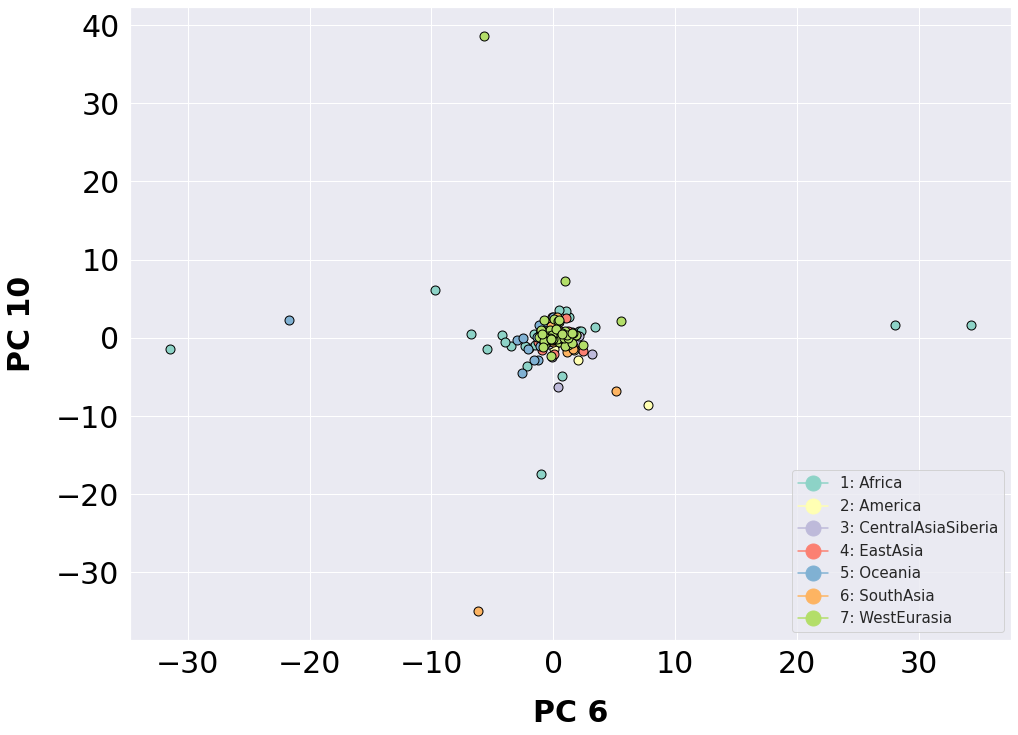

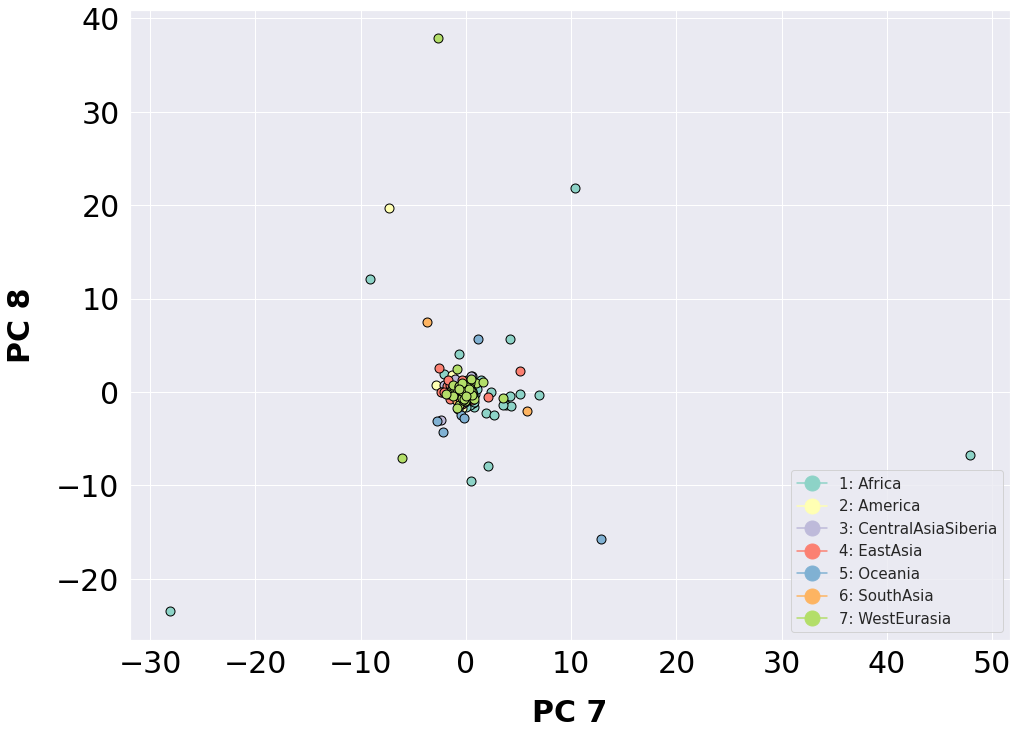

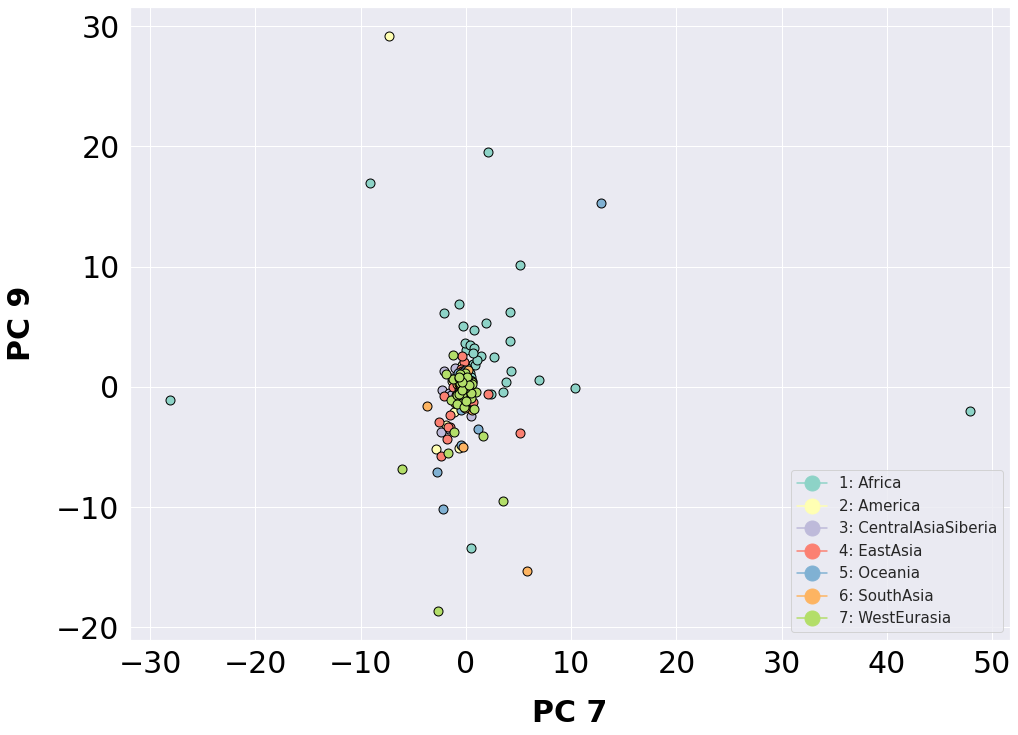

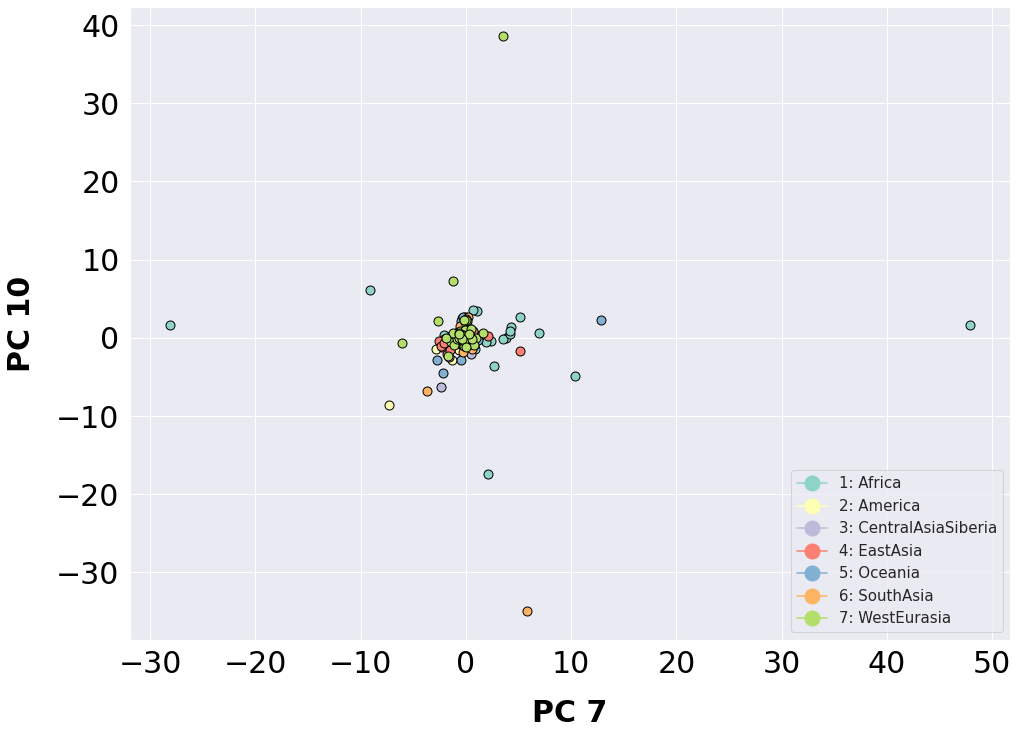

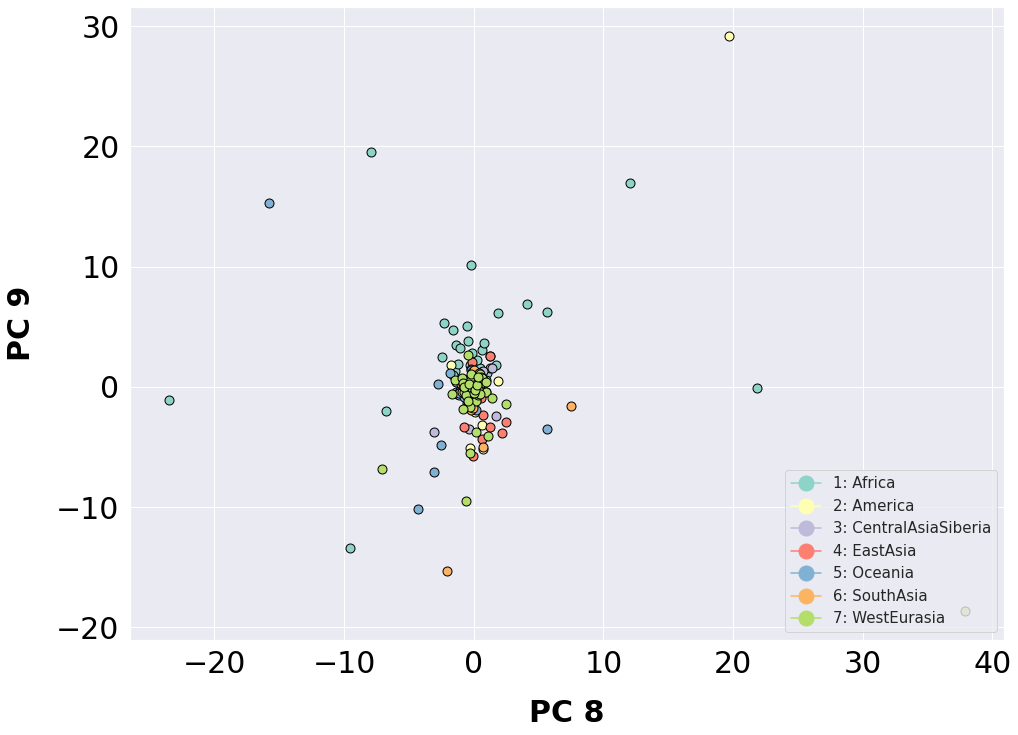

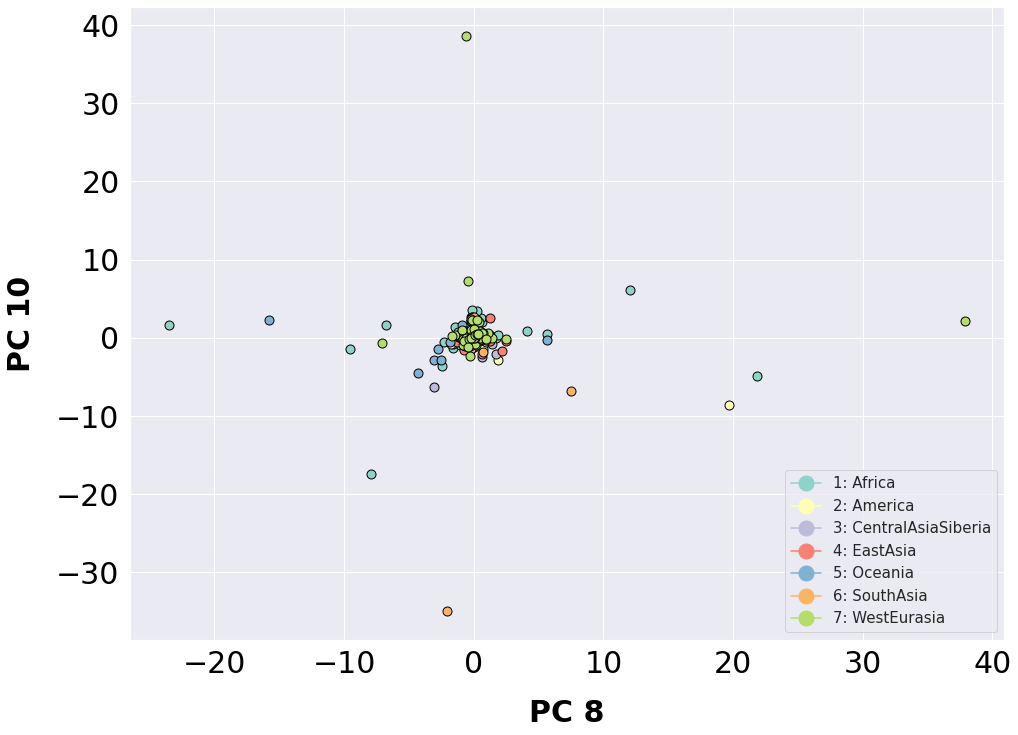

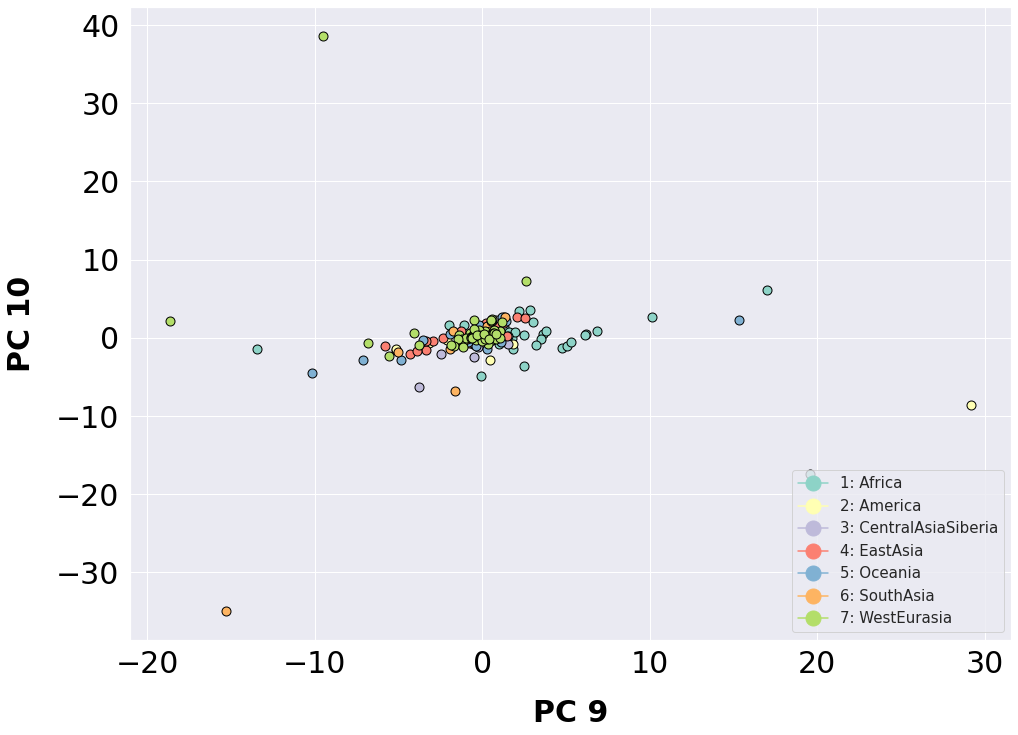

In [32]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
SouthAsia          F   Pakistan     2.409368    -8.900346    -0.217269   
America            F   Colombia    -0.317183    -5.578220    -1.284078   
...              ...        ...          ...          ...          ...   
Africa             M    Namibia    14.444032     6.758651     0.924845   
America            F       Peru     5.825893    -6.370259    -1.656353   
WestEurasia        F     France     3.753813    -2.815281    -1.276378   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
SouthAsia          F   Pakistan     2.409368    -8.900346    -0.217269   
America            F   Colombia    -0.317183    -5.578220    -1.284078   
...              ...        ...          ...          ...          ...   
Africa             M    Namibia    14.444032     6.758651     0.924845   
America            F       Peru     5.825893    -6.370259    -1.656353   
WestEurasia        F     France     3.753813    -2.815281    -1.276378   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
SouthAsia          F   Pakistan     2.409368    -8.900346    -0.217269   
America            F   Colombia    -0.317183    -5.578220    -1.284078   
...              ...        ...          ...          ...          ...   
Africa             M    Namibia    14.444032     6.758651     0.924845   
America            F       Peru     5.825893    -6.370259    -1.656353   
WestEurasia        F     France     3.753813    -2.815281    -1.276378   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   

             component_4  component_5

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
SouthAsia          F   Pakistan     2.409368    -8.900346    -0.217269   
America            F   Colombia    -0.317183    -5.578220    -1.284078   
...              ...        ...          ...          ...          ...   
Africa             M    Namibia    14.444032     6.758651     0.924845   
America            F       Peru     5.825893    -6.370259    -1.656353   
WestEurasia        F     France     3.753813    -2.815281    -1.276378   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   

             component_4  component_5

            7-Gender 11-Country  component_1  component_2  component_3  \
10-Region                                                                
EastAsia           F      China    -0.376193    -6.529474    -1.122016   
EastAsia           F    Vietnam     3.368838    -5.913963    -0.993306   
EastAsia           F      China    -0.844653    -3.956796    -0.276932   
SouthAsia          F   Pakistan     2.409368    -8.900346    -0.217269   
America            F   Colombia    -0.317183    -5.578220    -1.284078   
...              ...        ...          ...          ...          ...   
Africa             M    Namibia    14.444032     6.758651     0.924845   
America            F       Peru     5.825893    -6.370259    -1.656353   
WestEurasia        F     France     3.753813    -2.815281    -1.276378   
America            F     Mexico    -0.188785    -2.383837    -1.084652   
EastAsia           F      Japan     3.073486    -5.351326    -1.067801   

             component_4  component_5

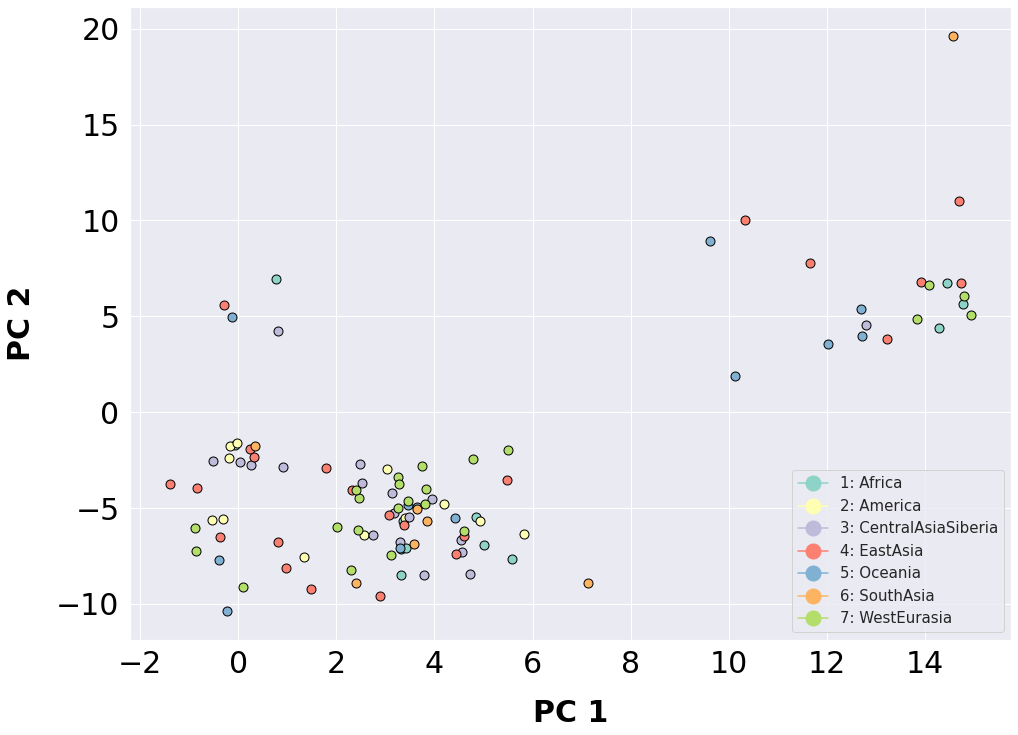

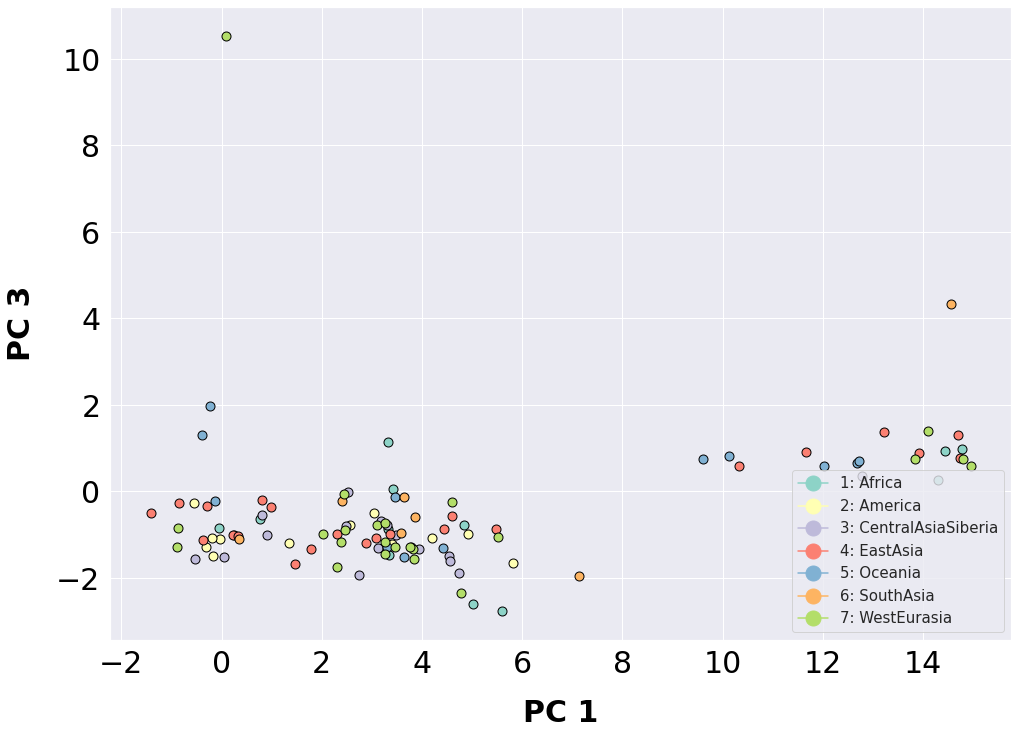

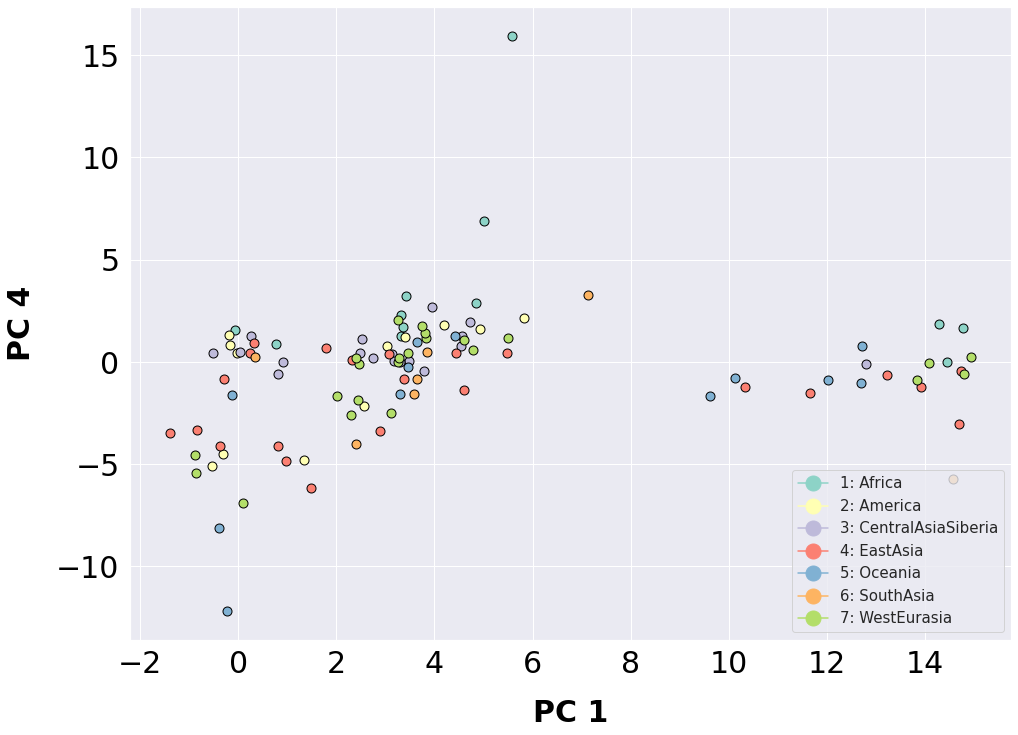

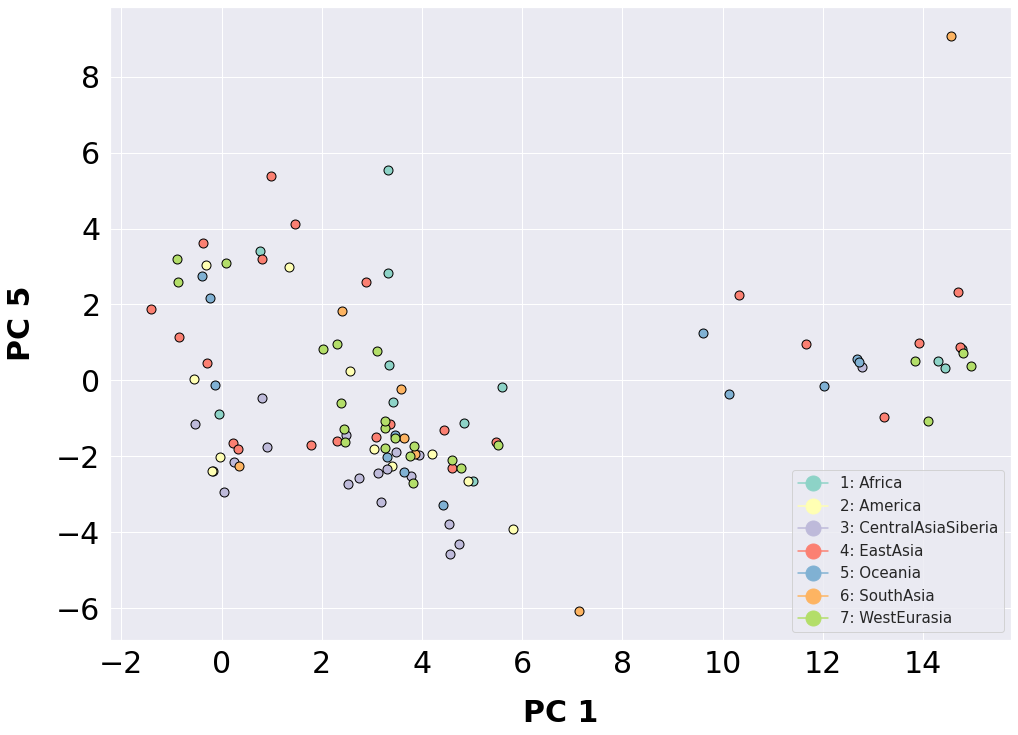

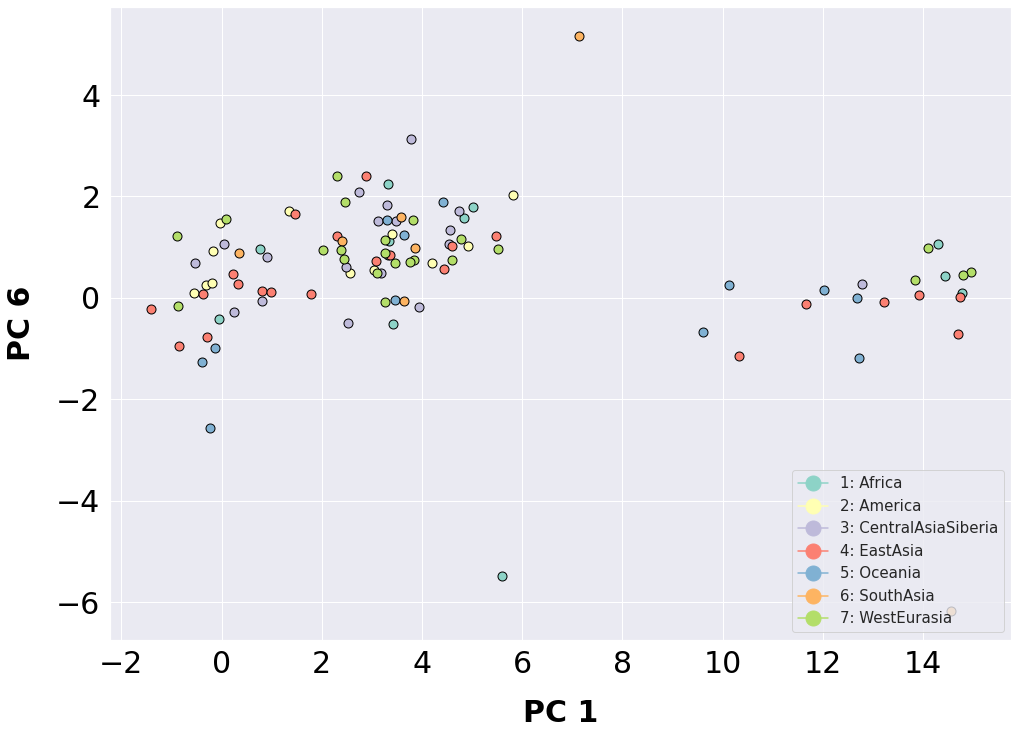

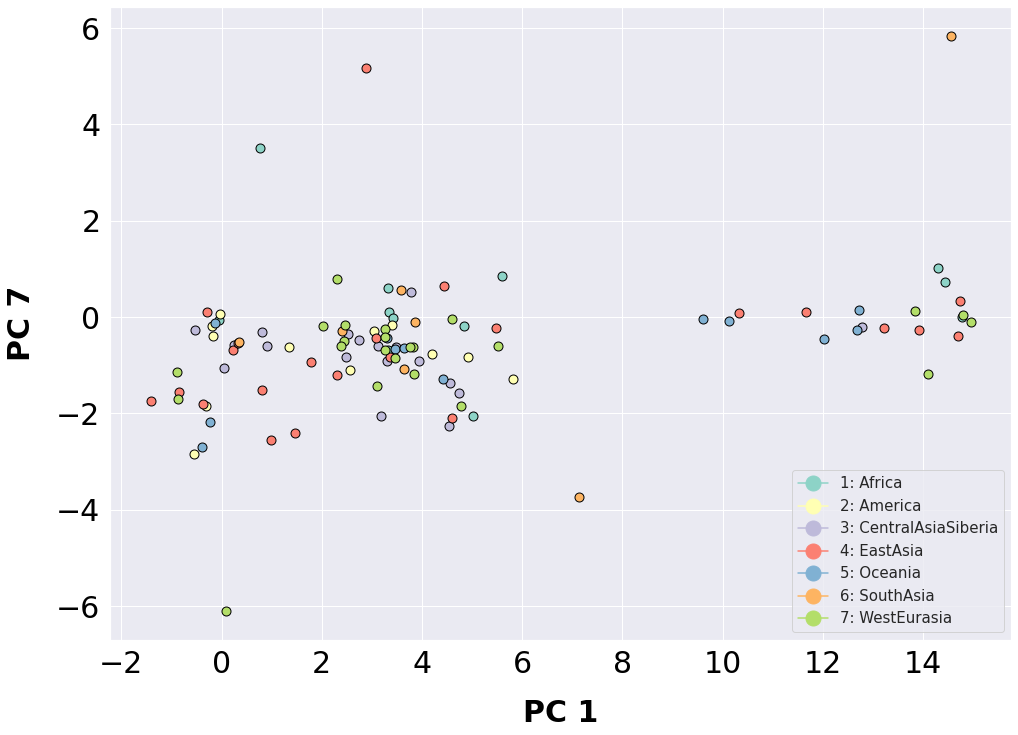

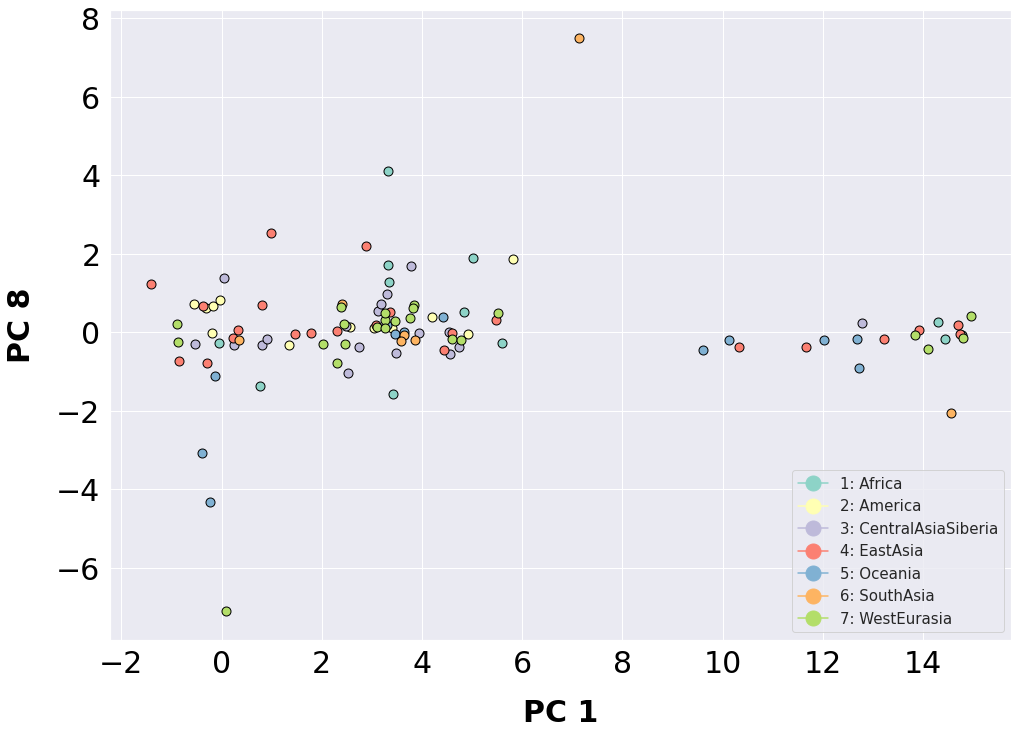

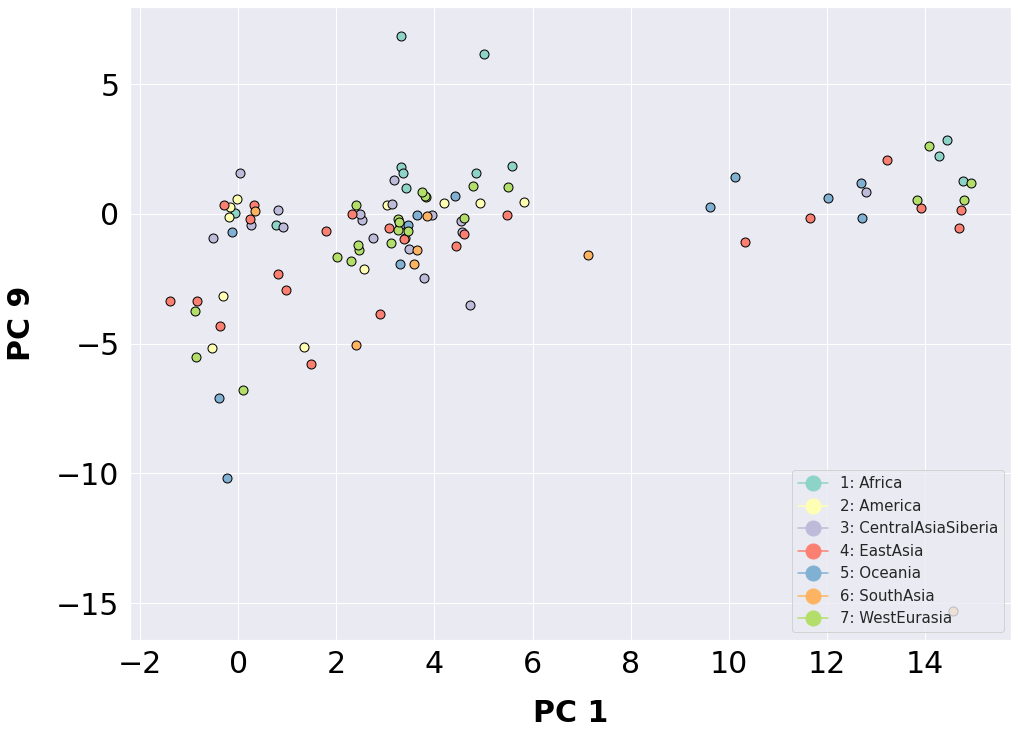

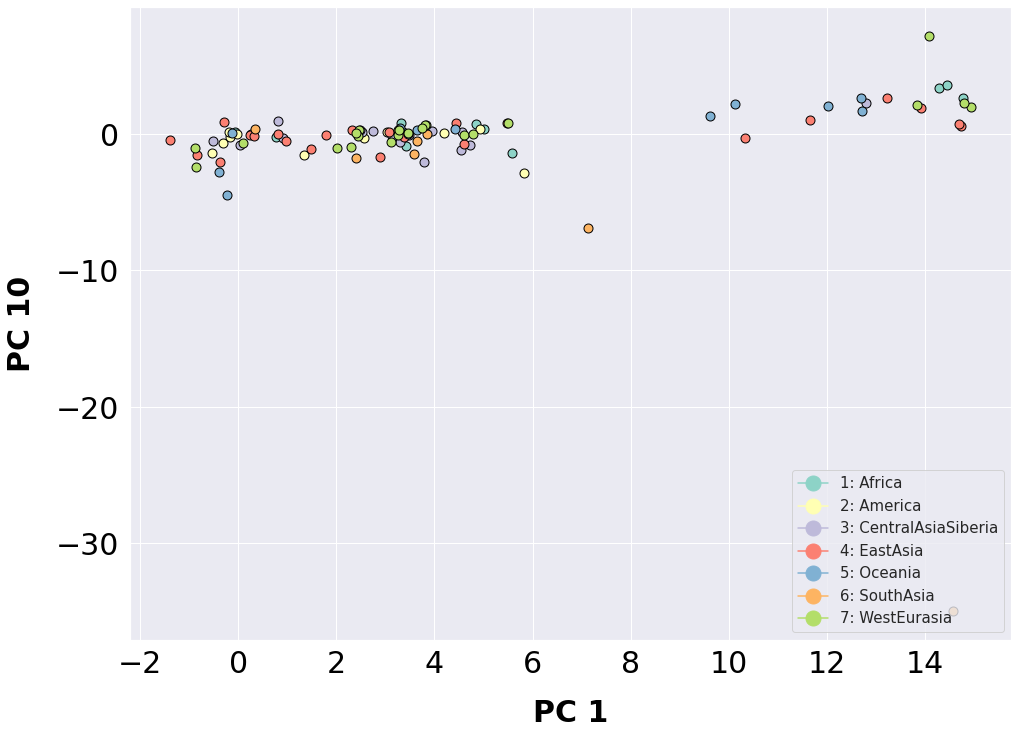

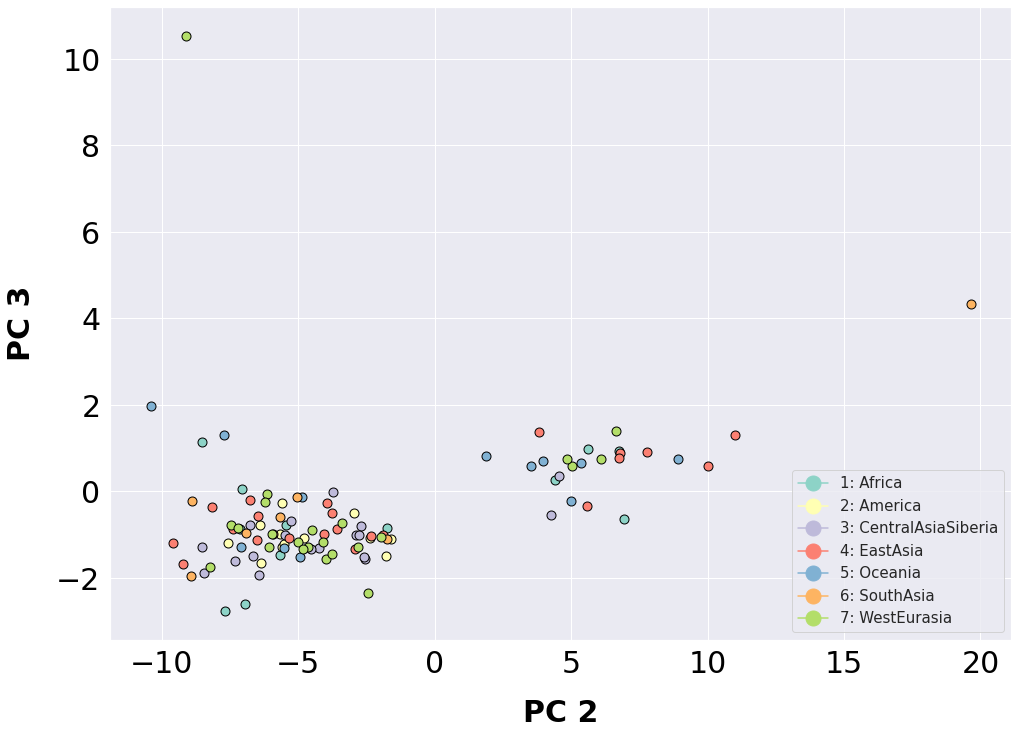

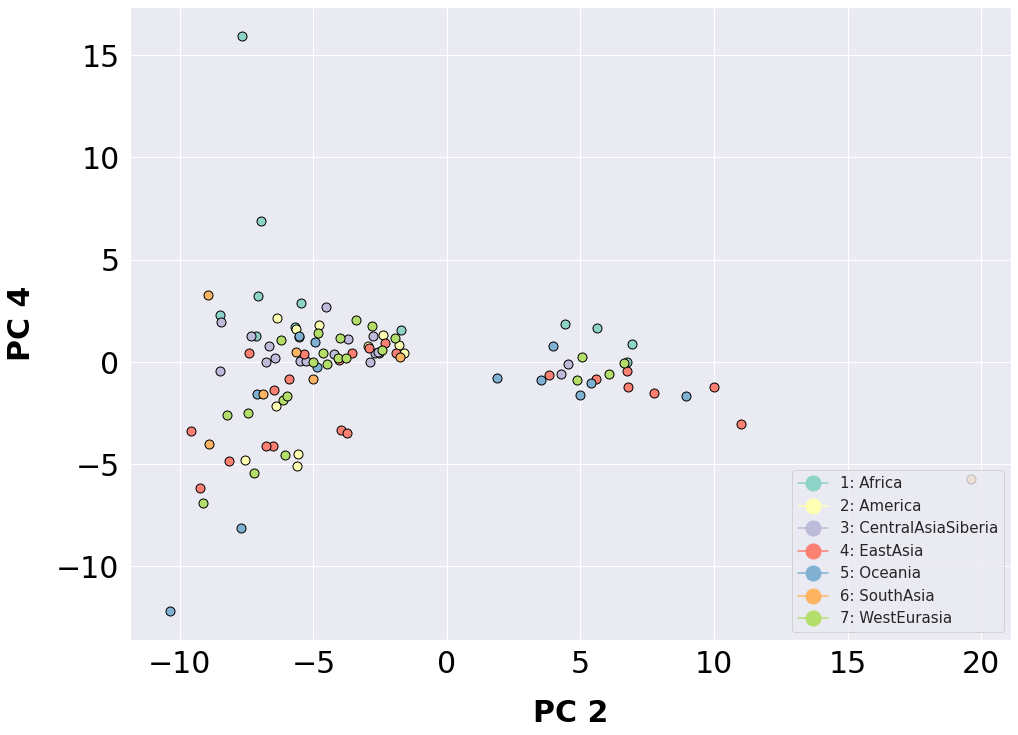

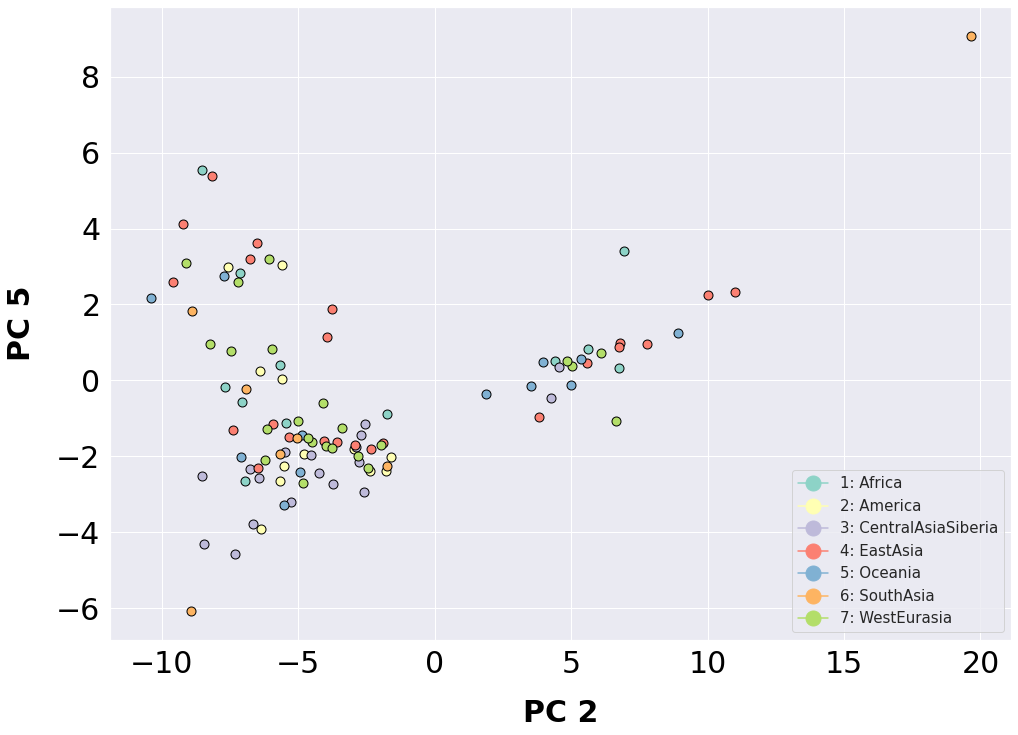

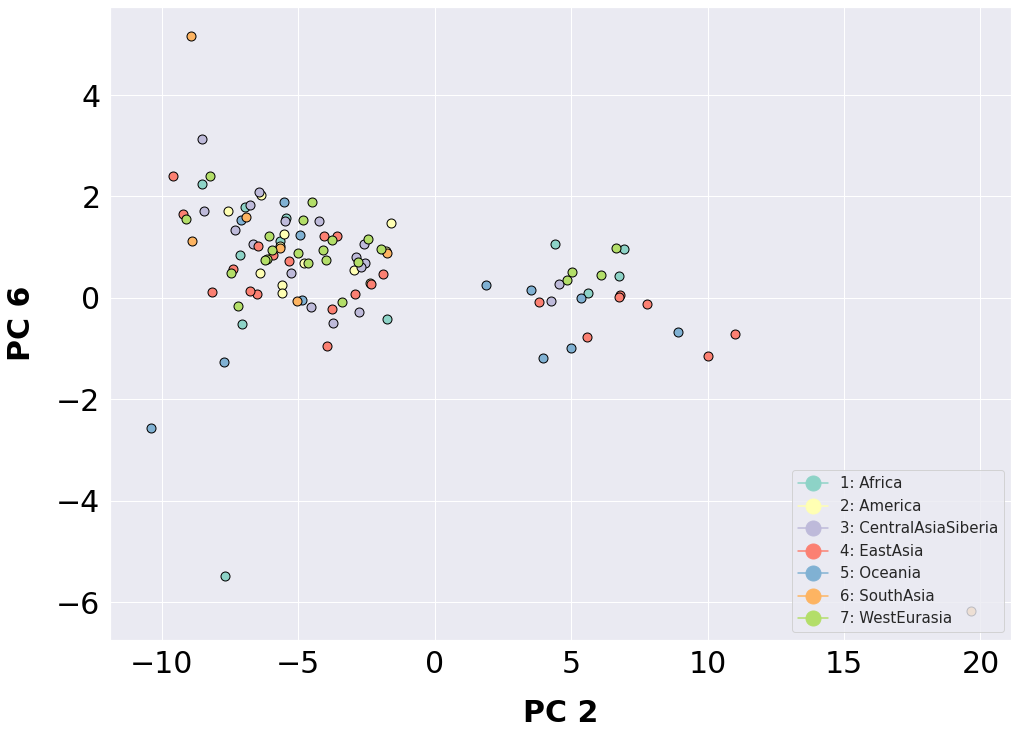

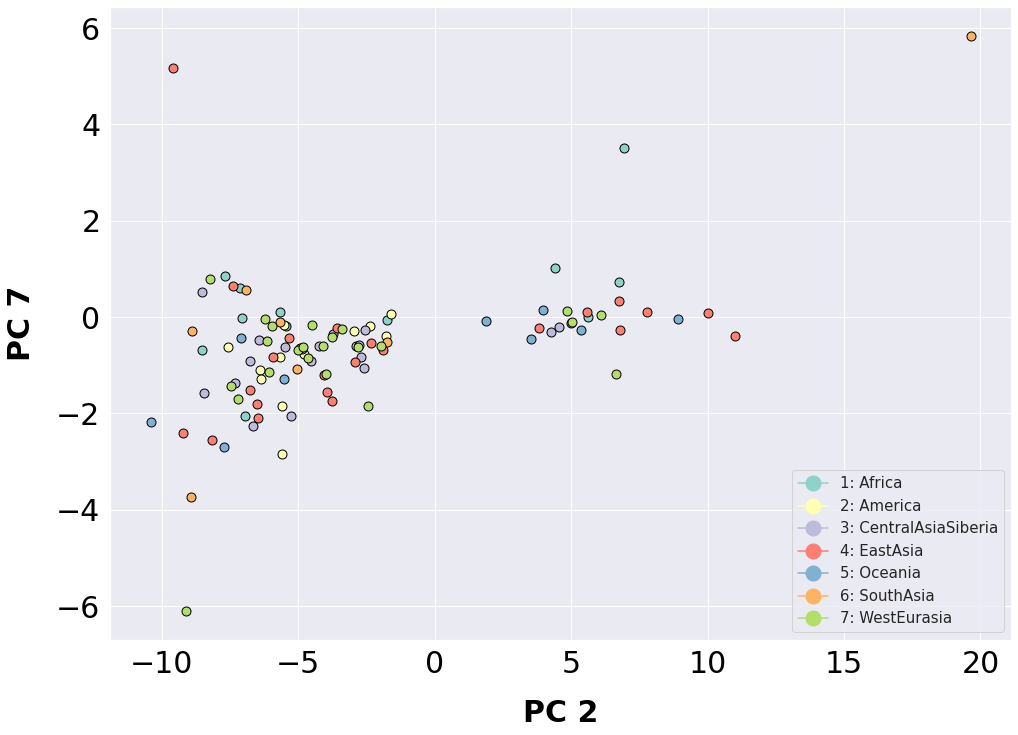

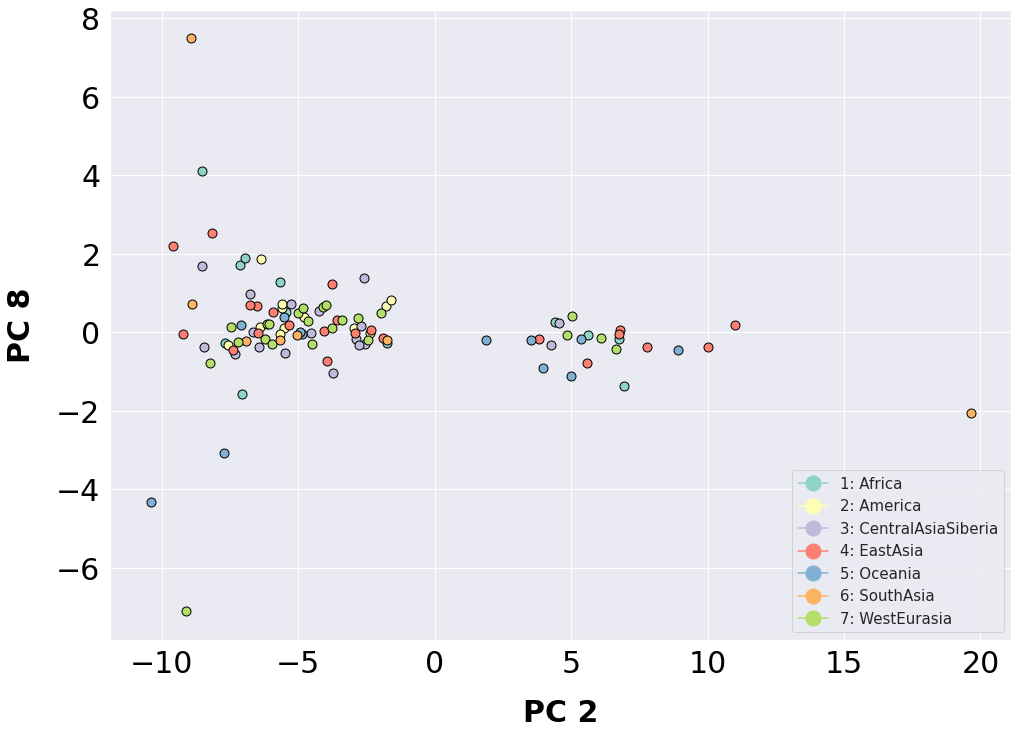

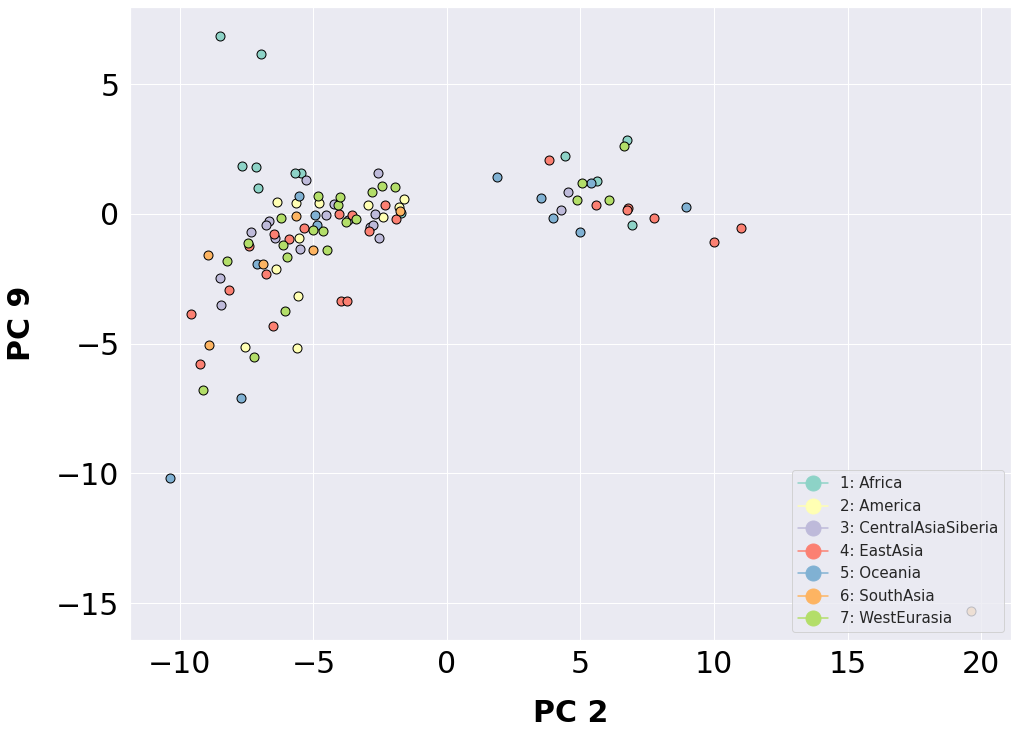

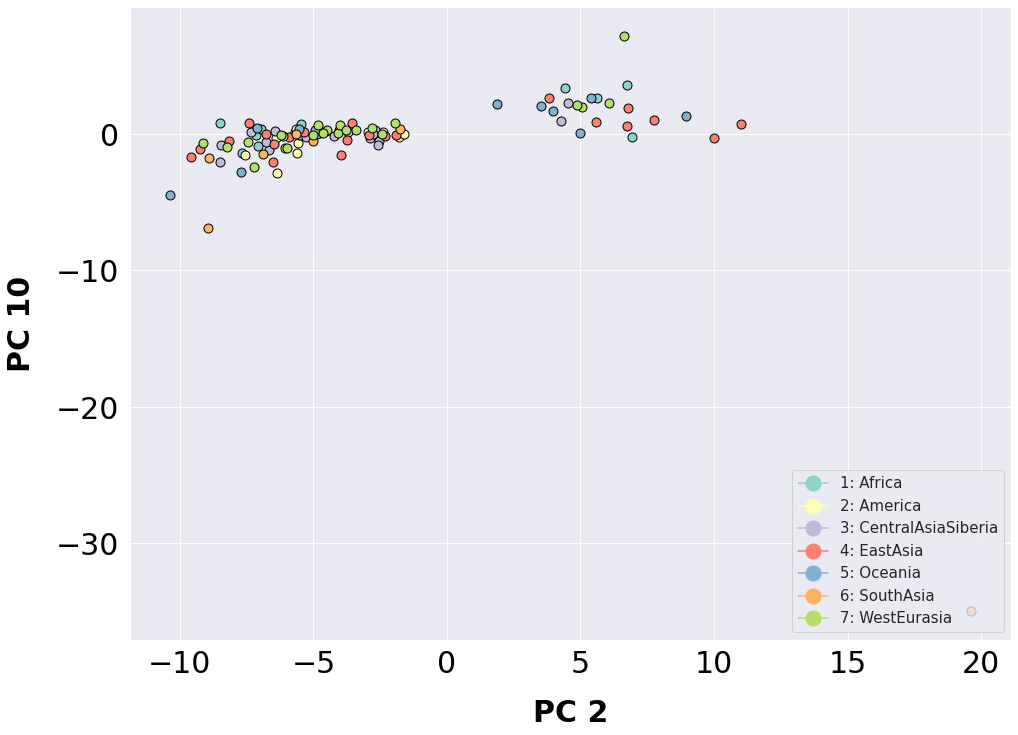

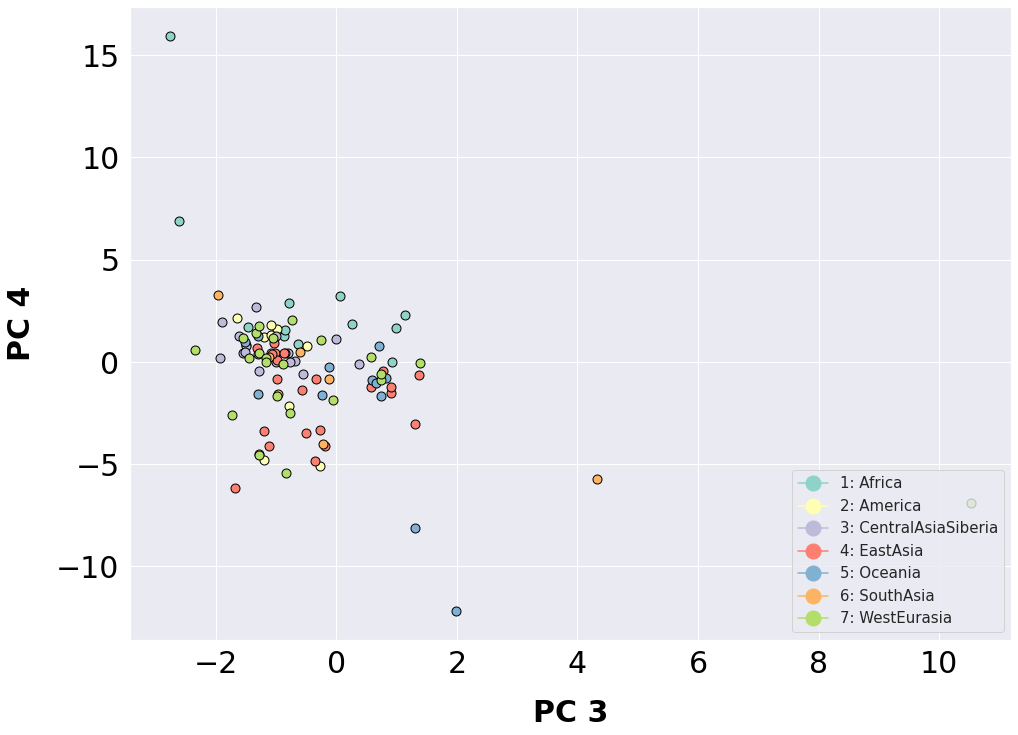

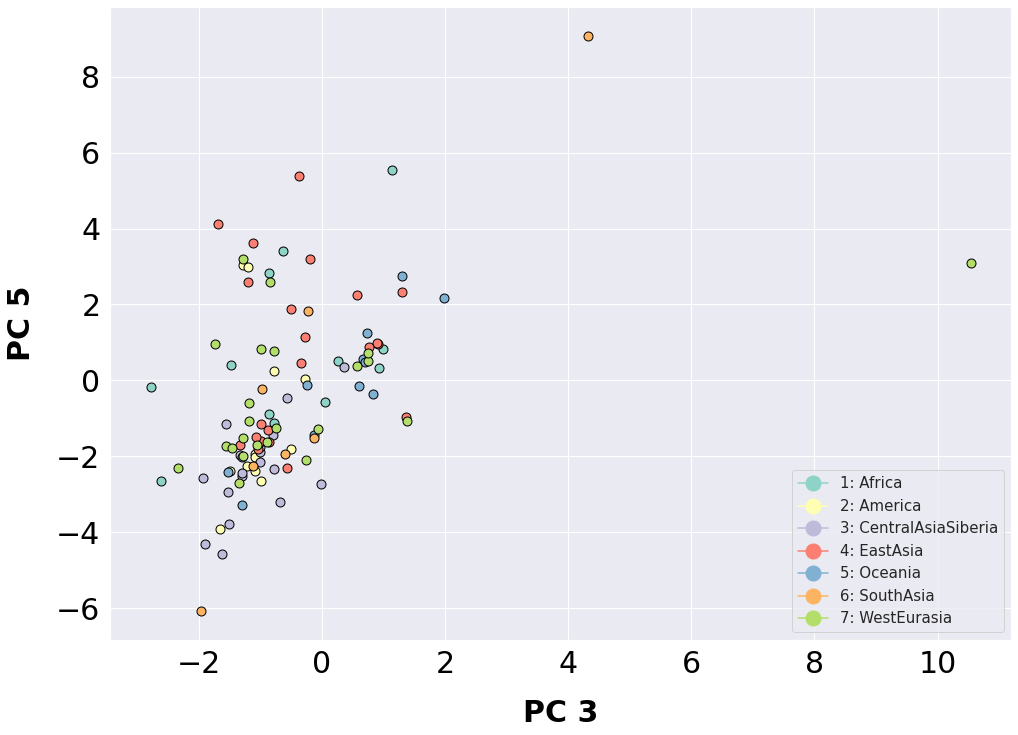

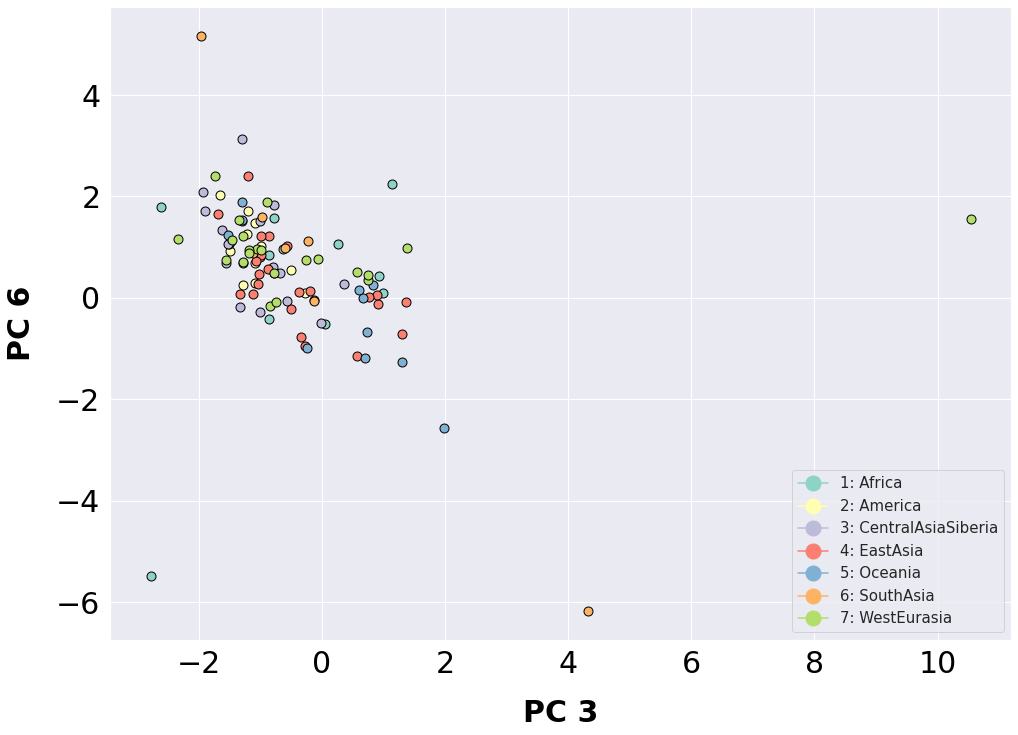

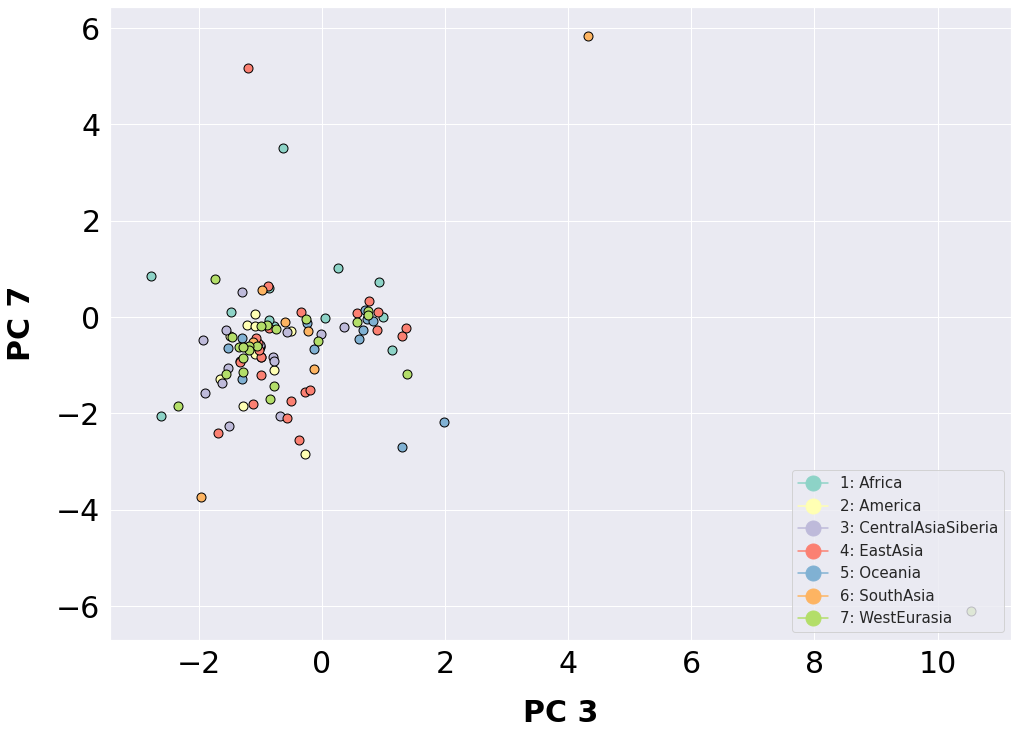

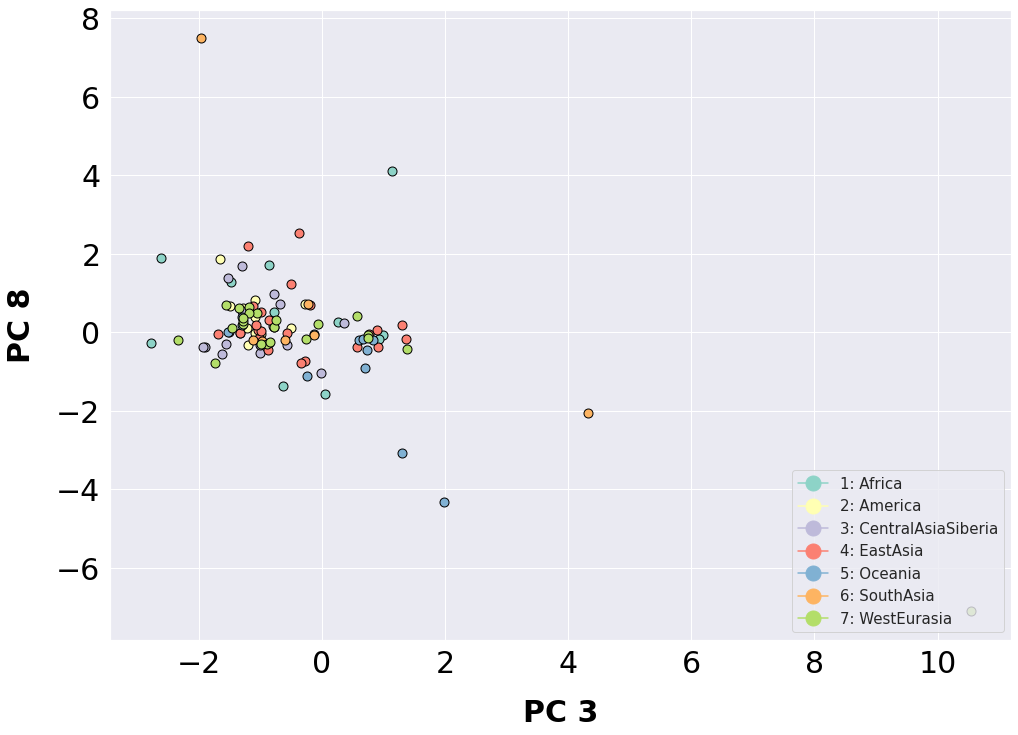

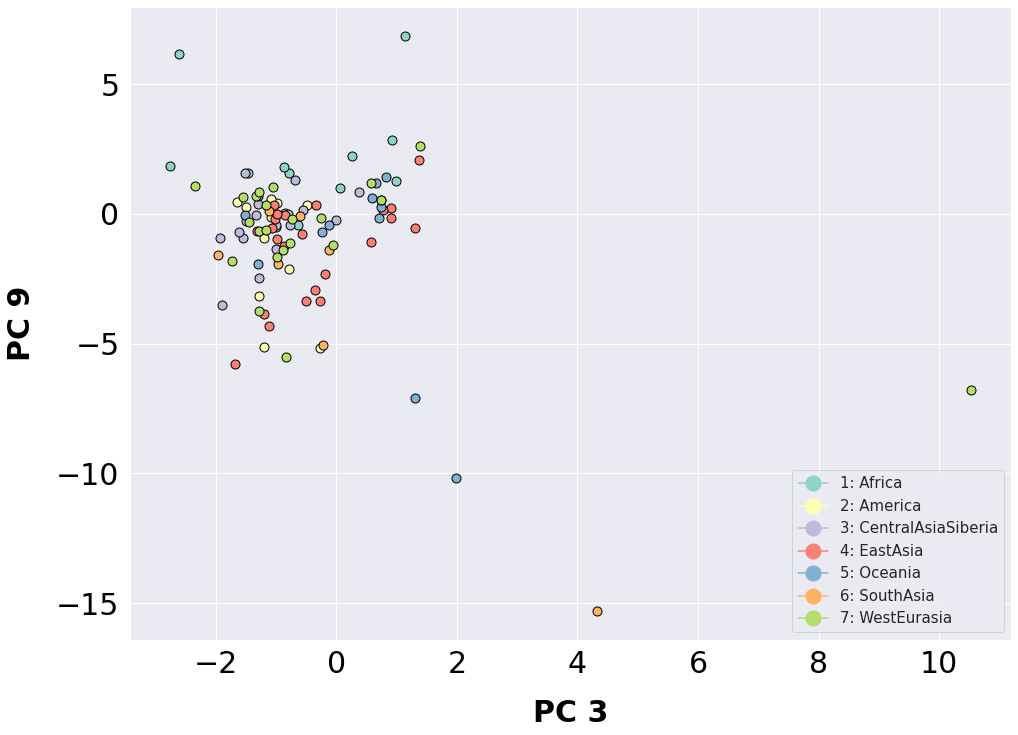

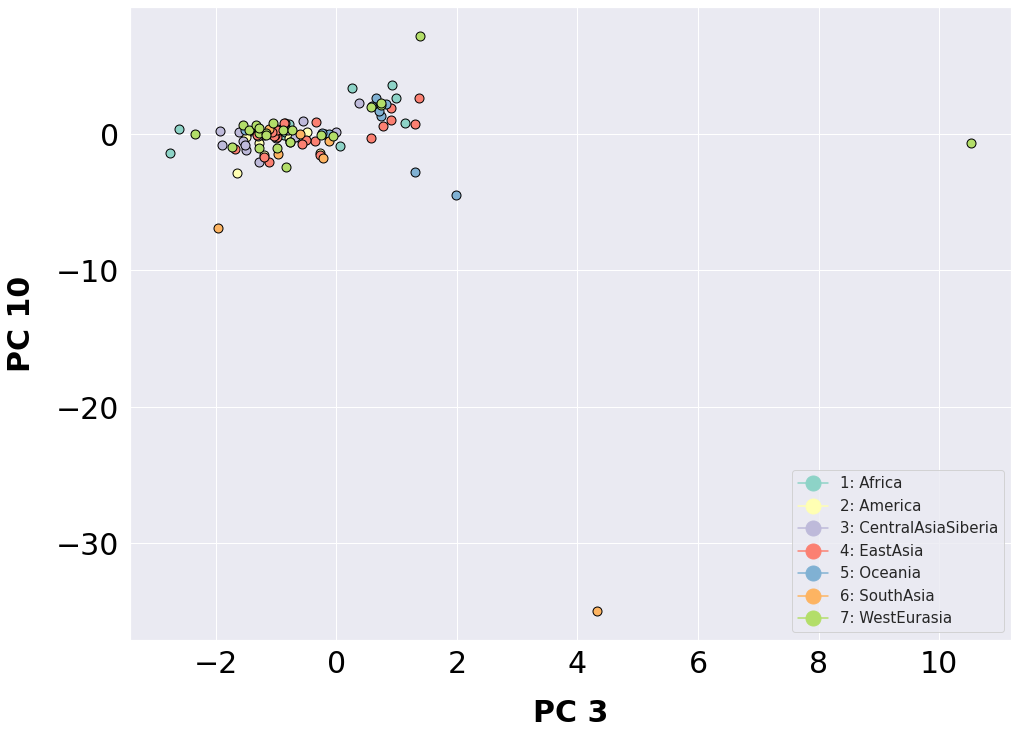

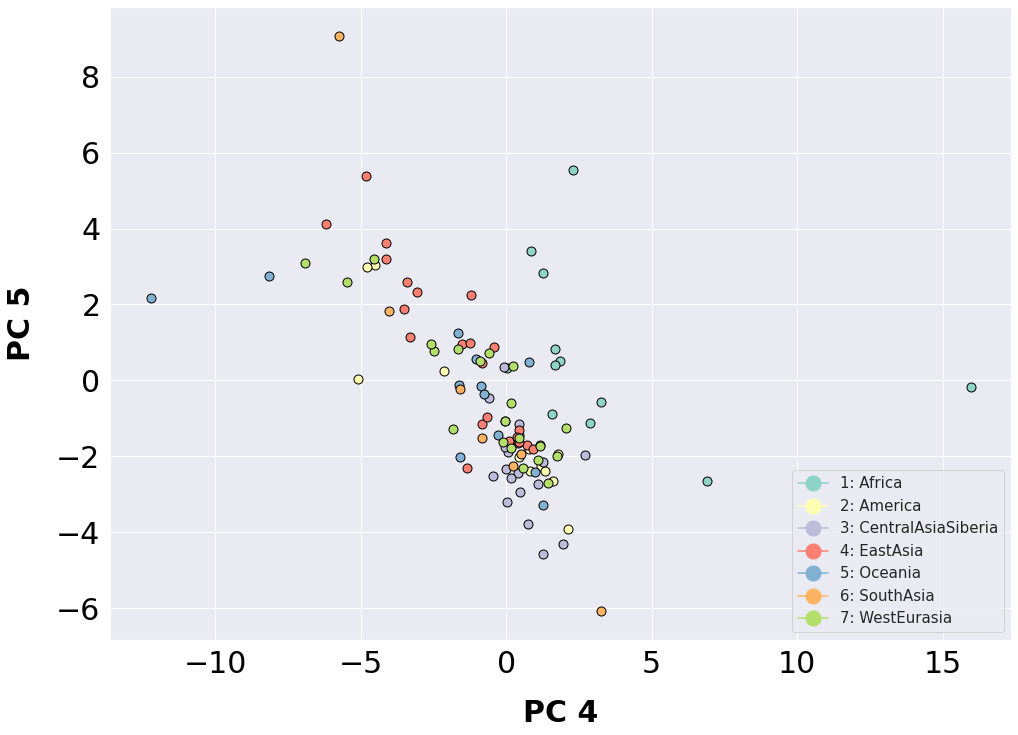

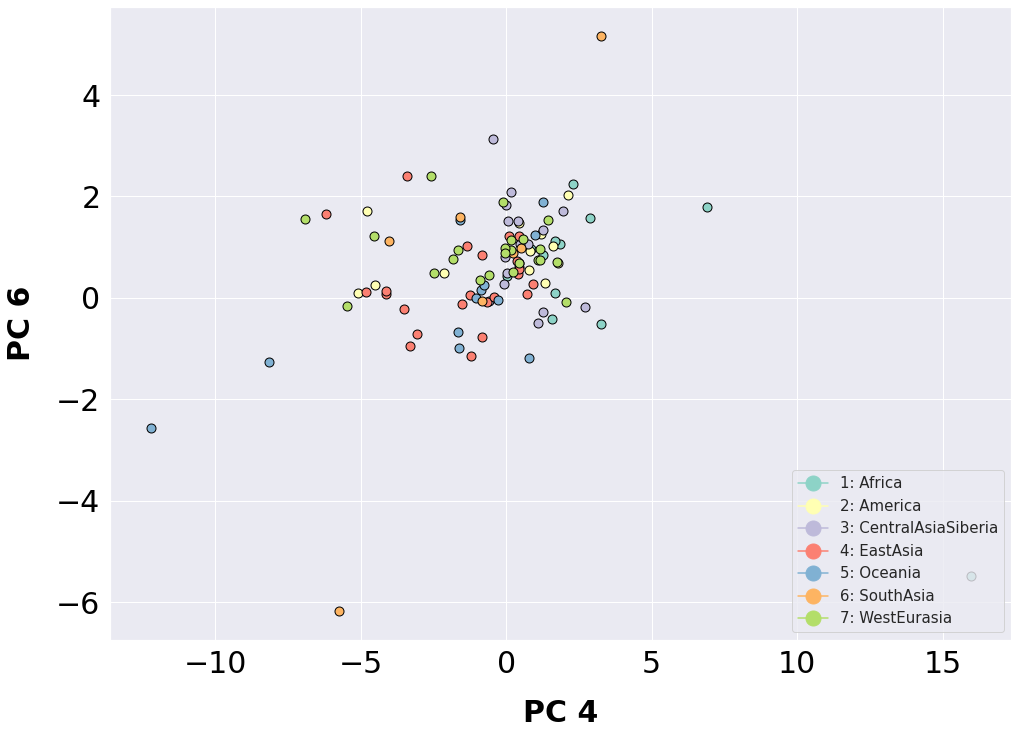

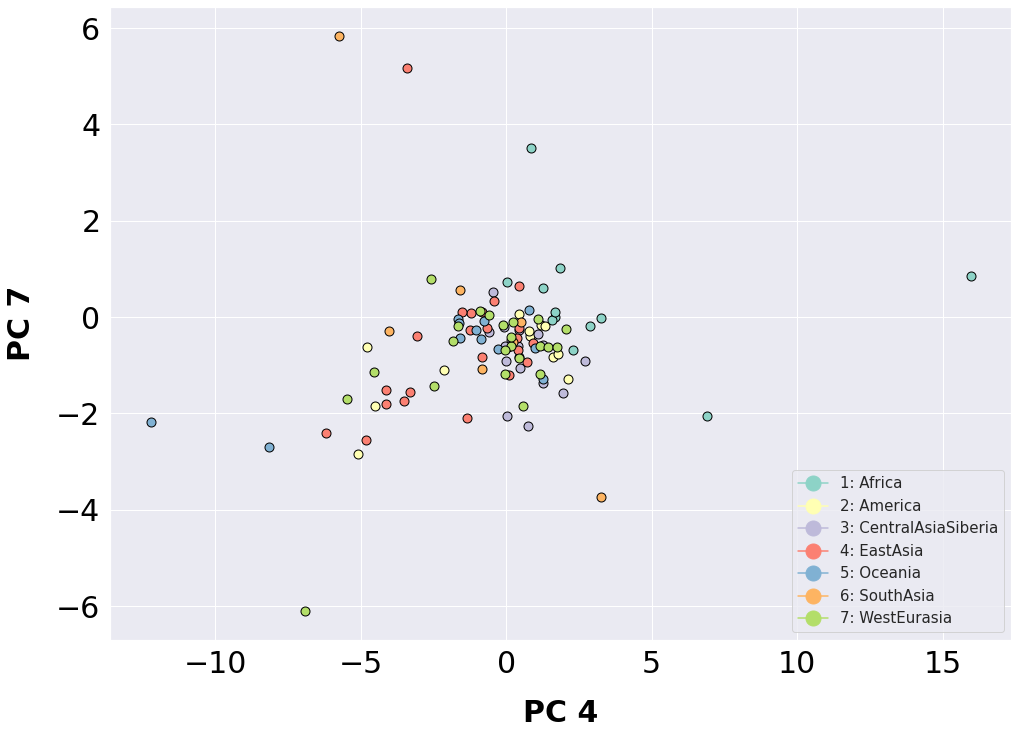

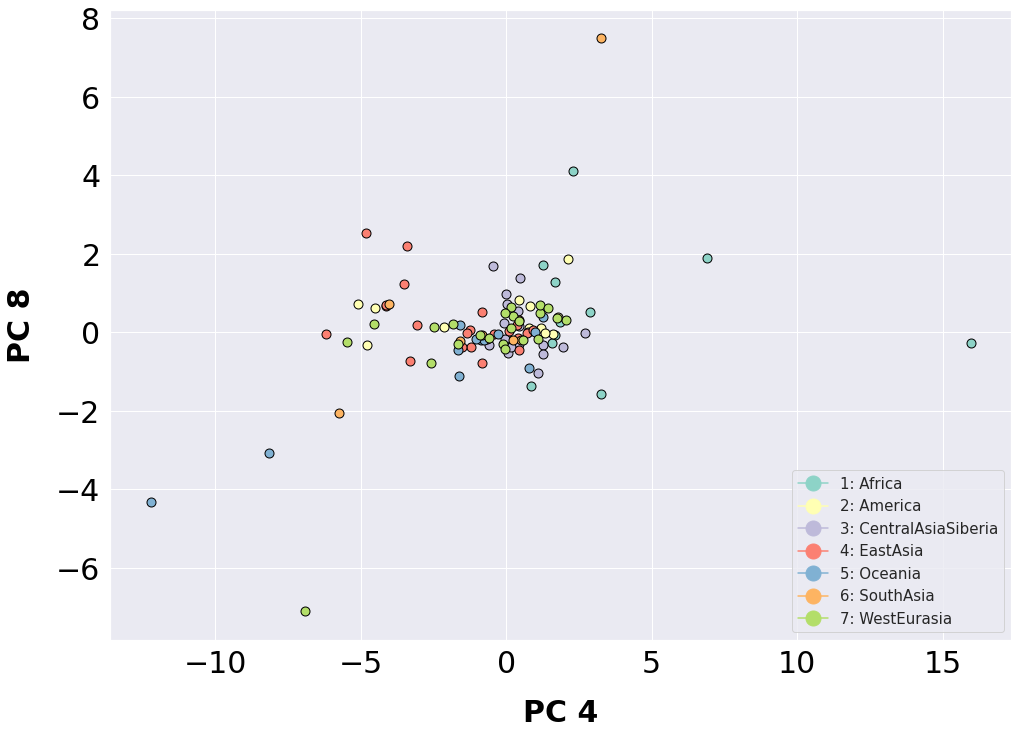

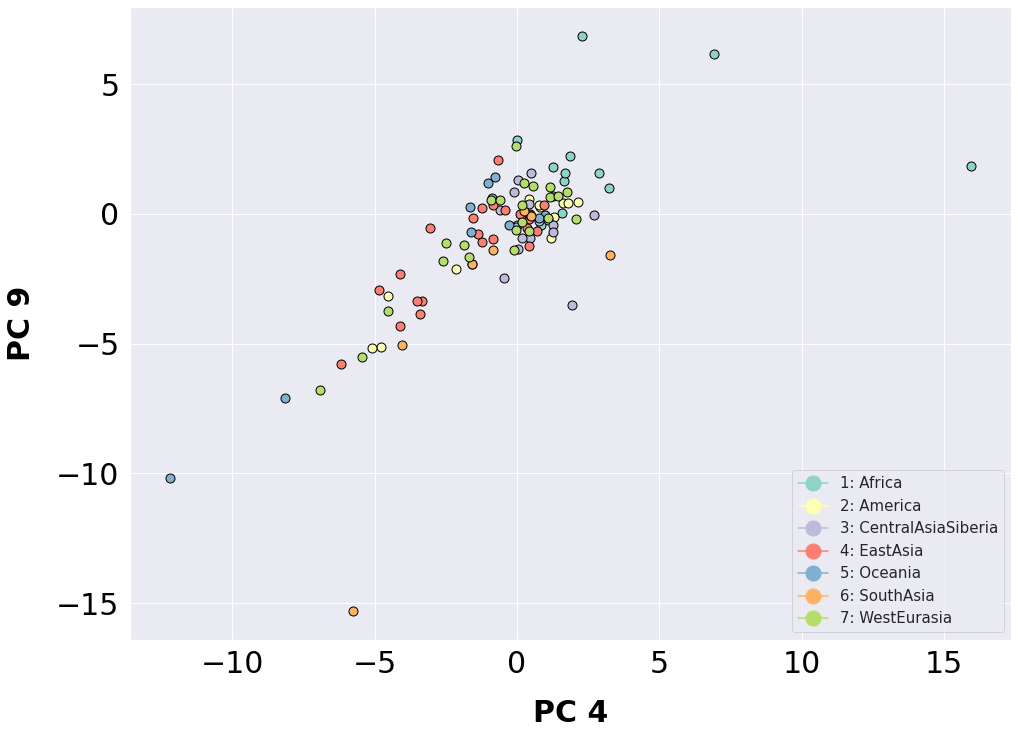

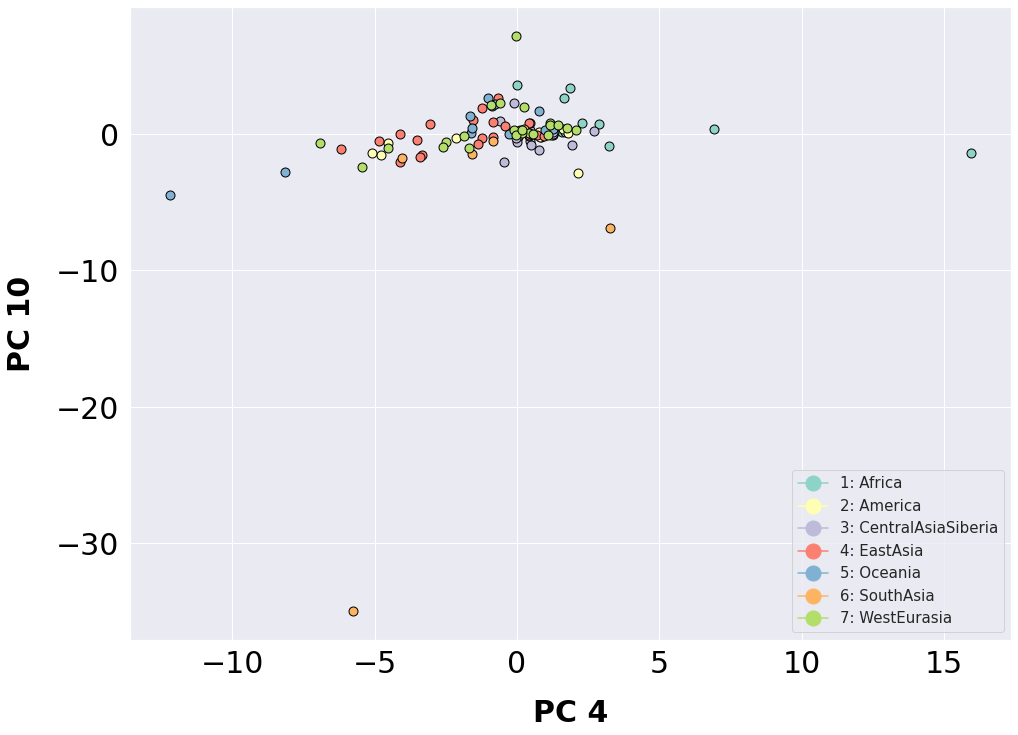

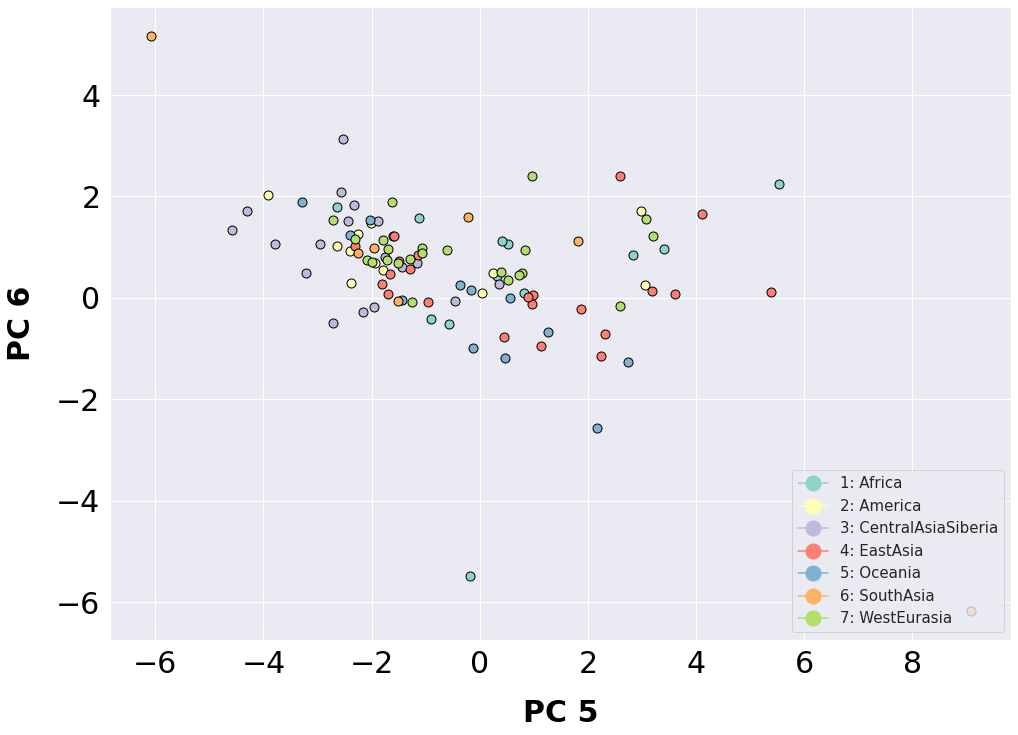

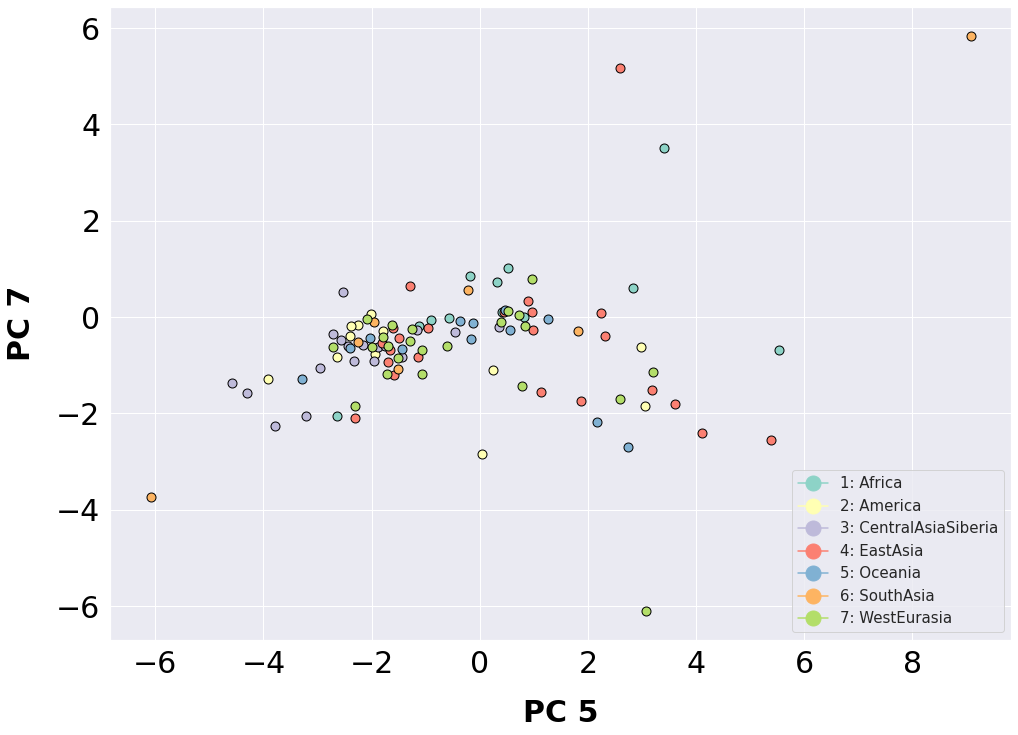

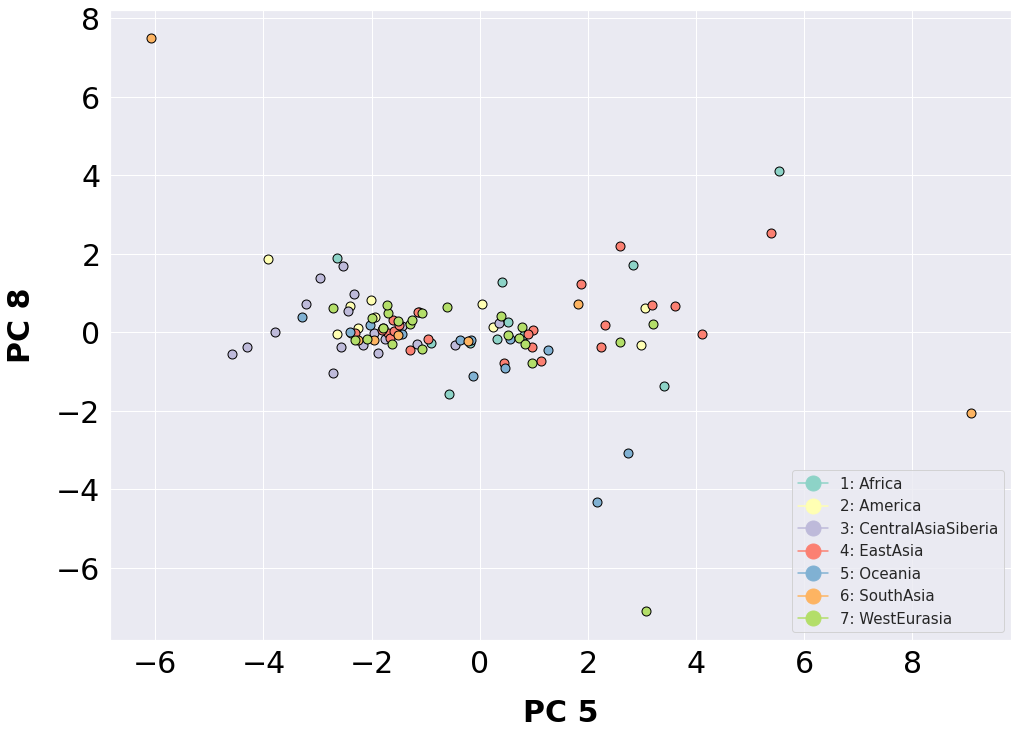

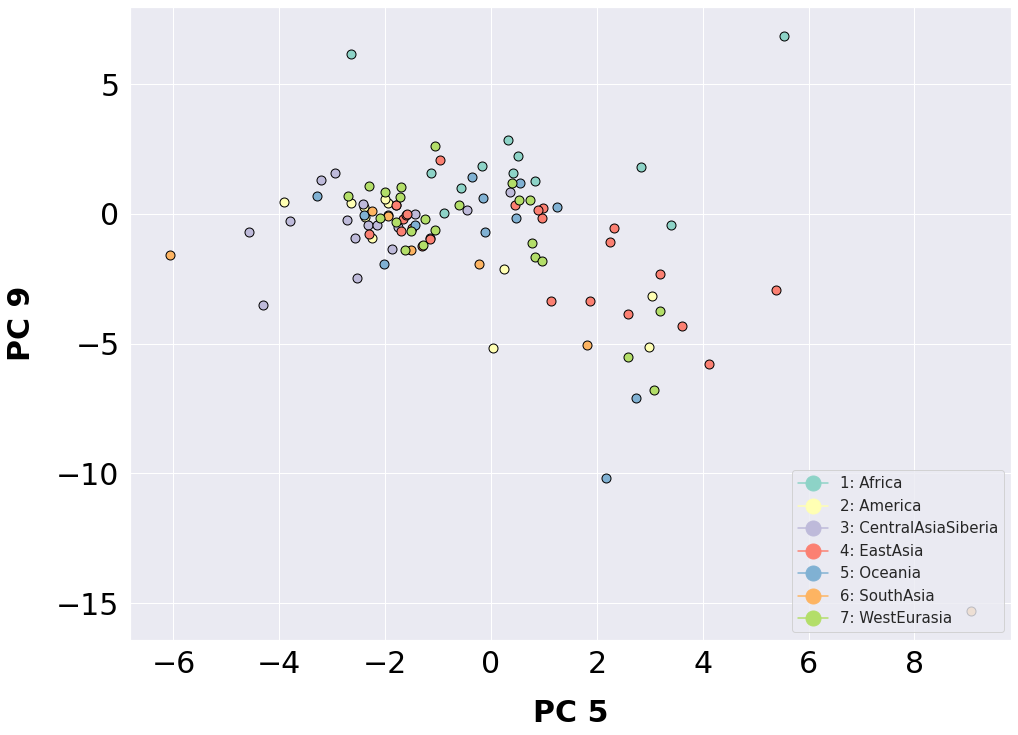

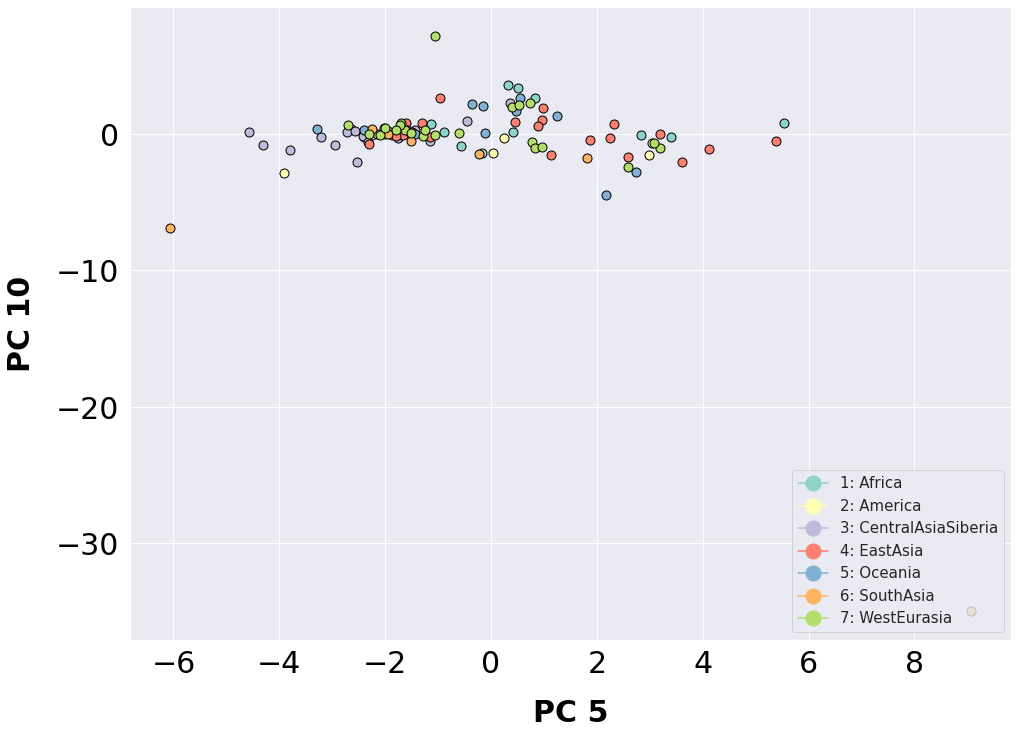

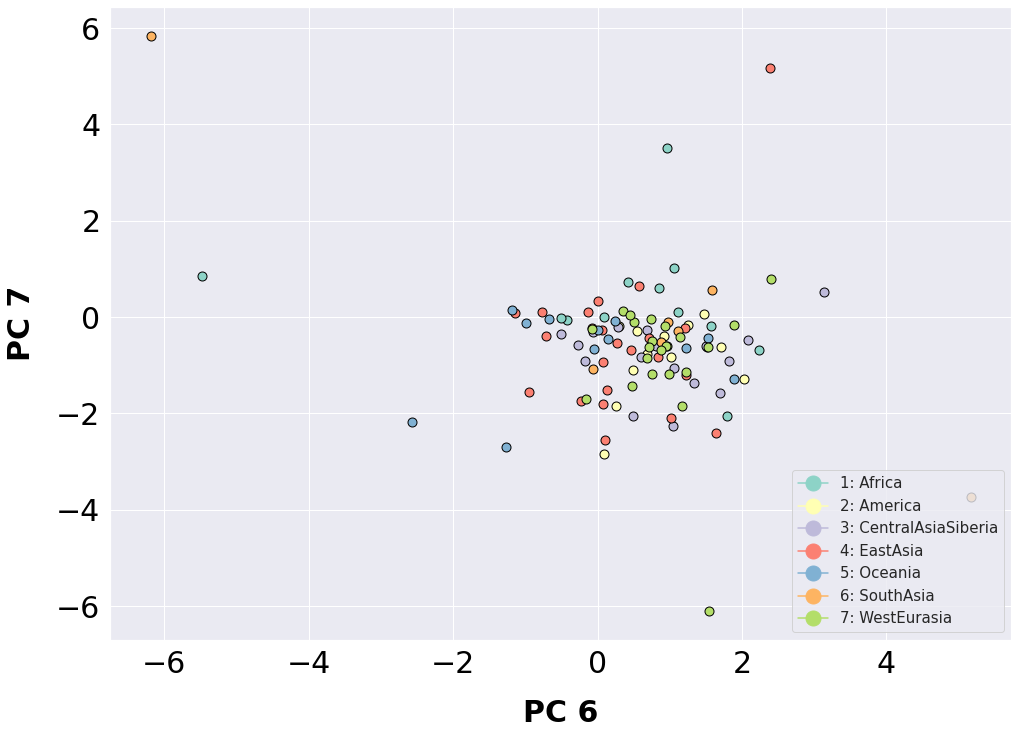

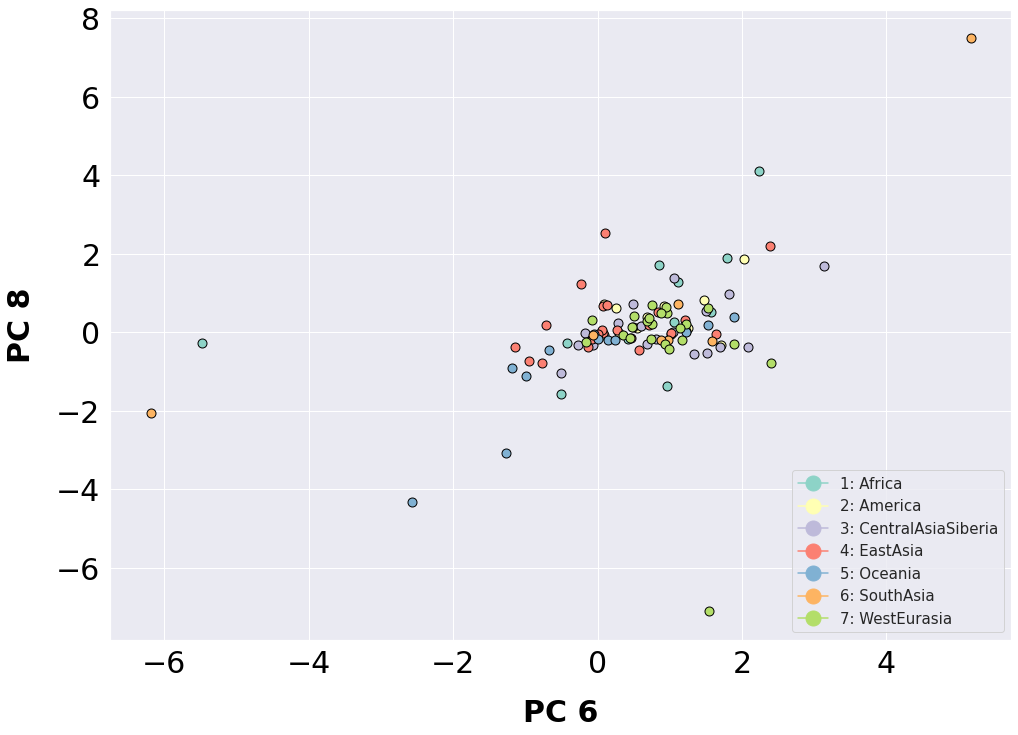

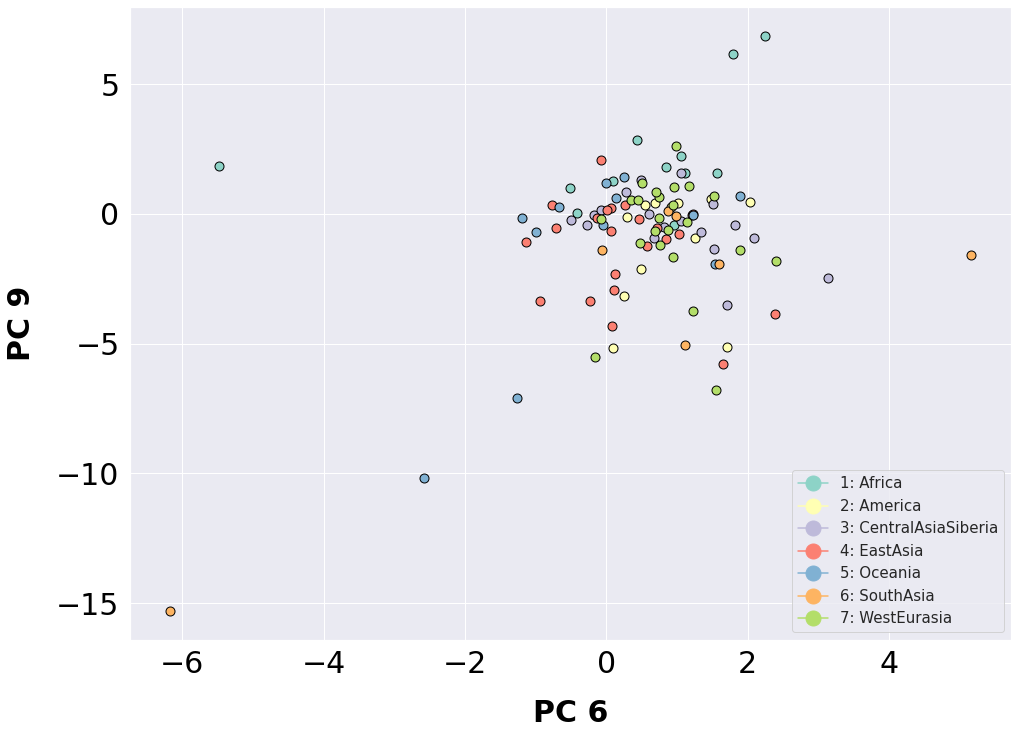

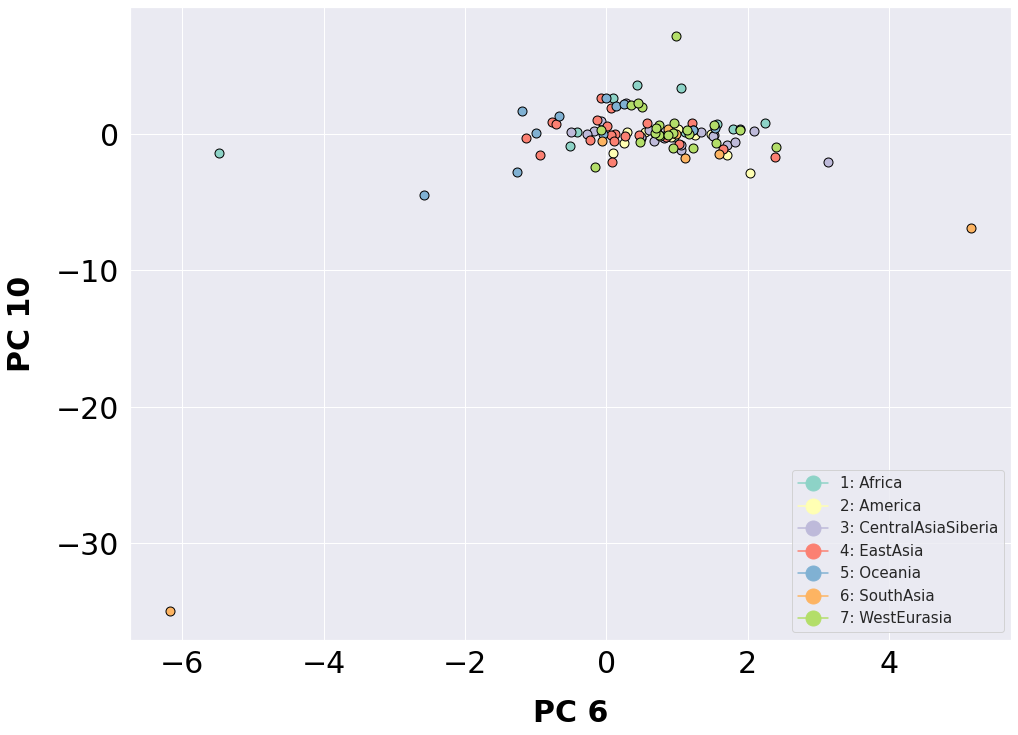

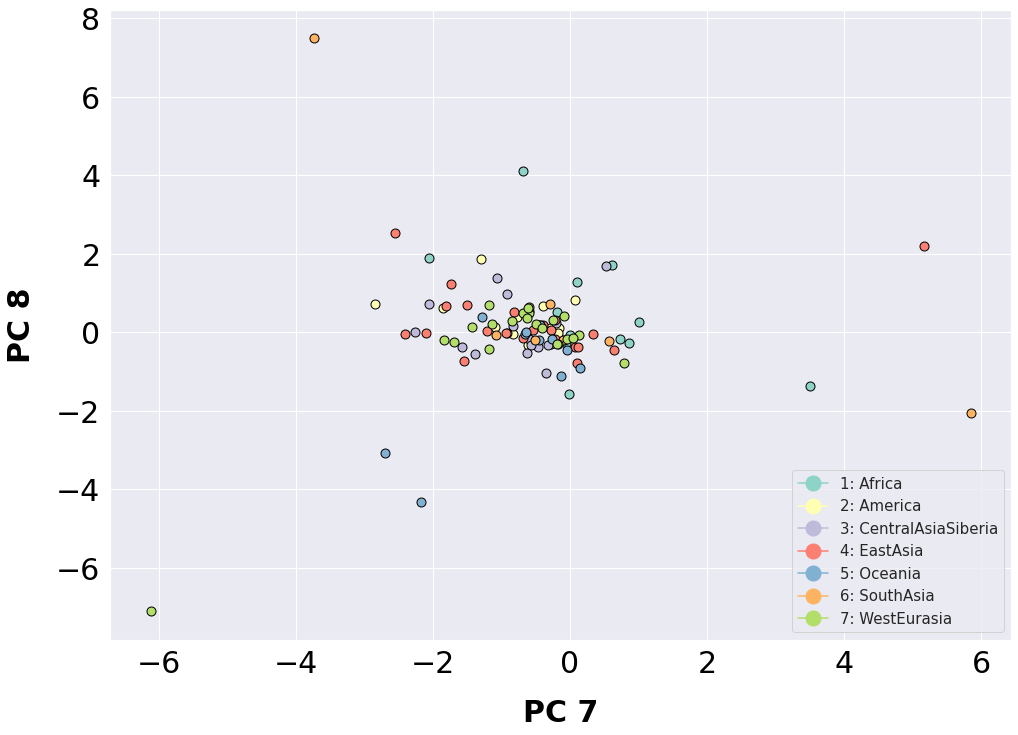

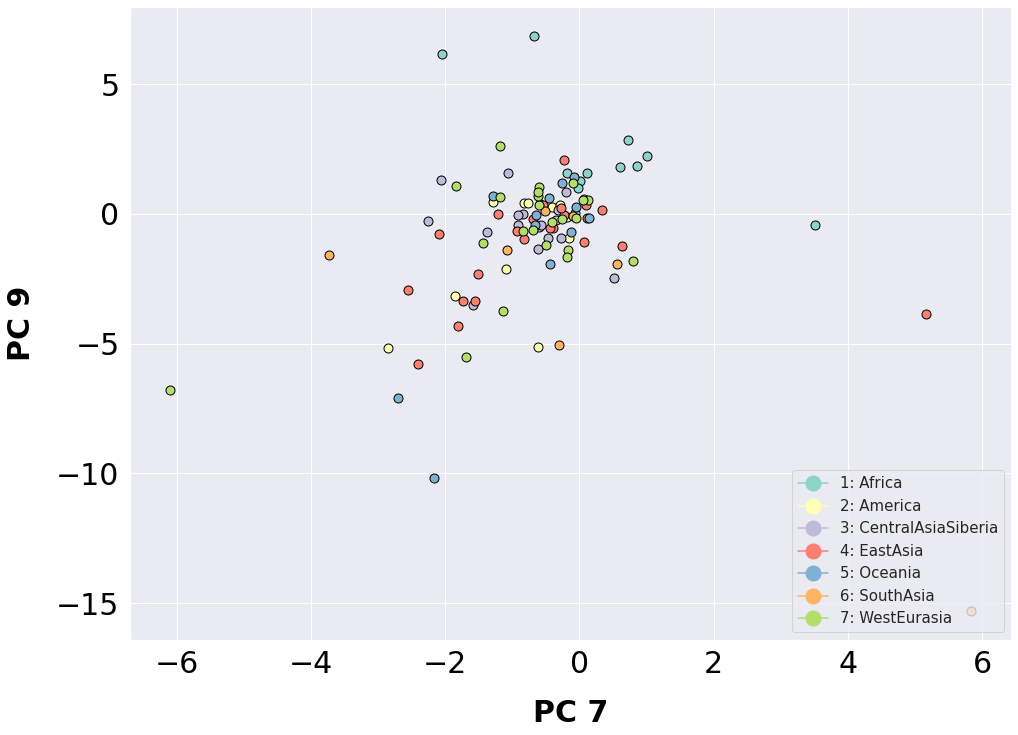

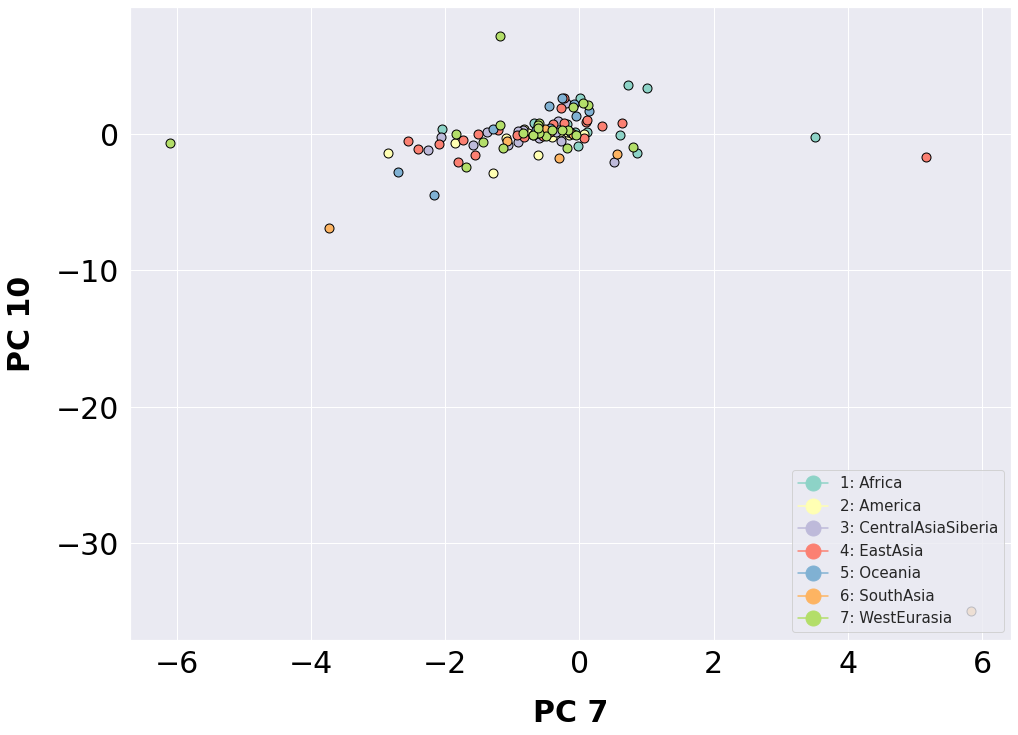

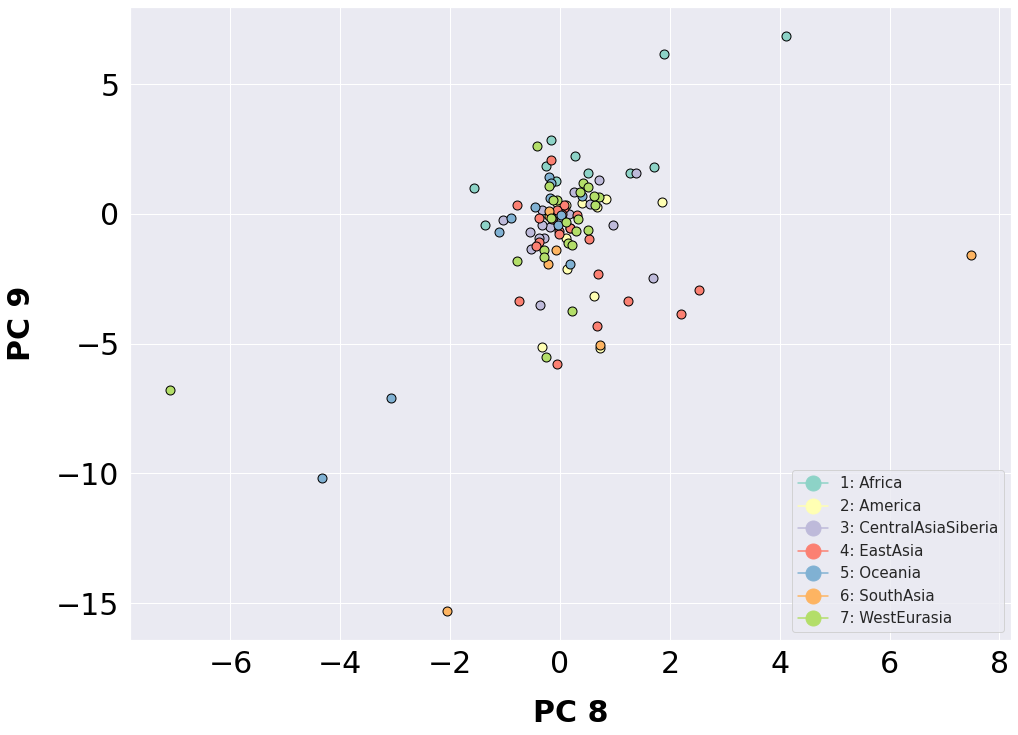

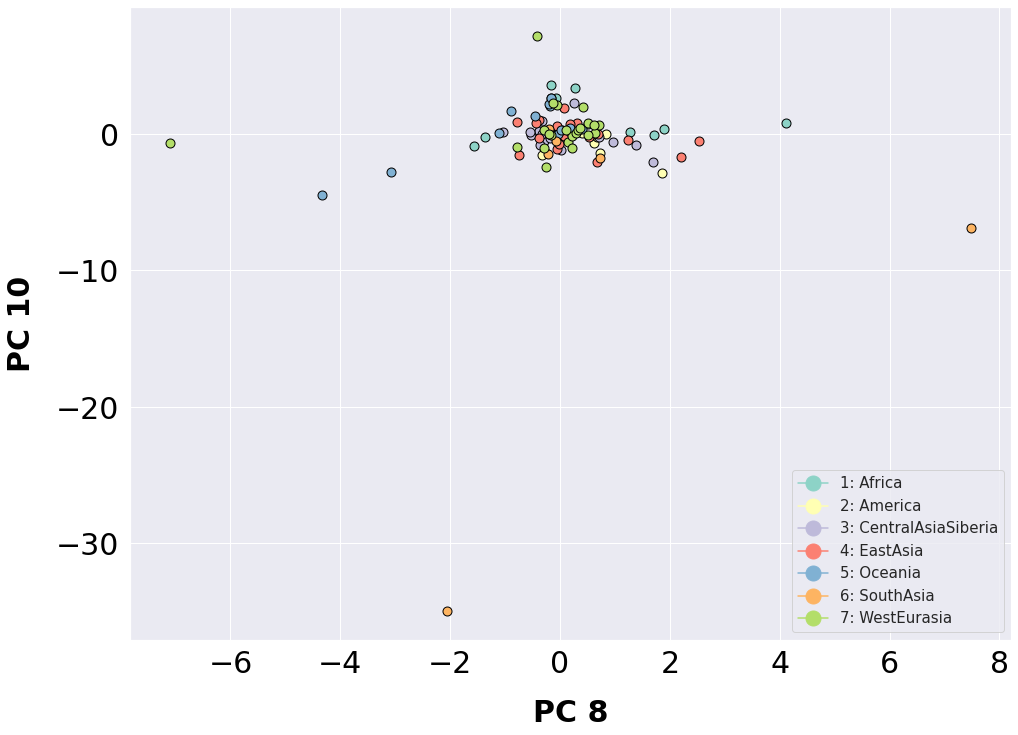

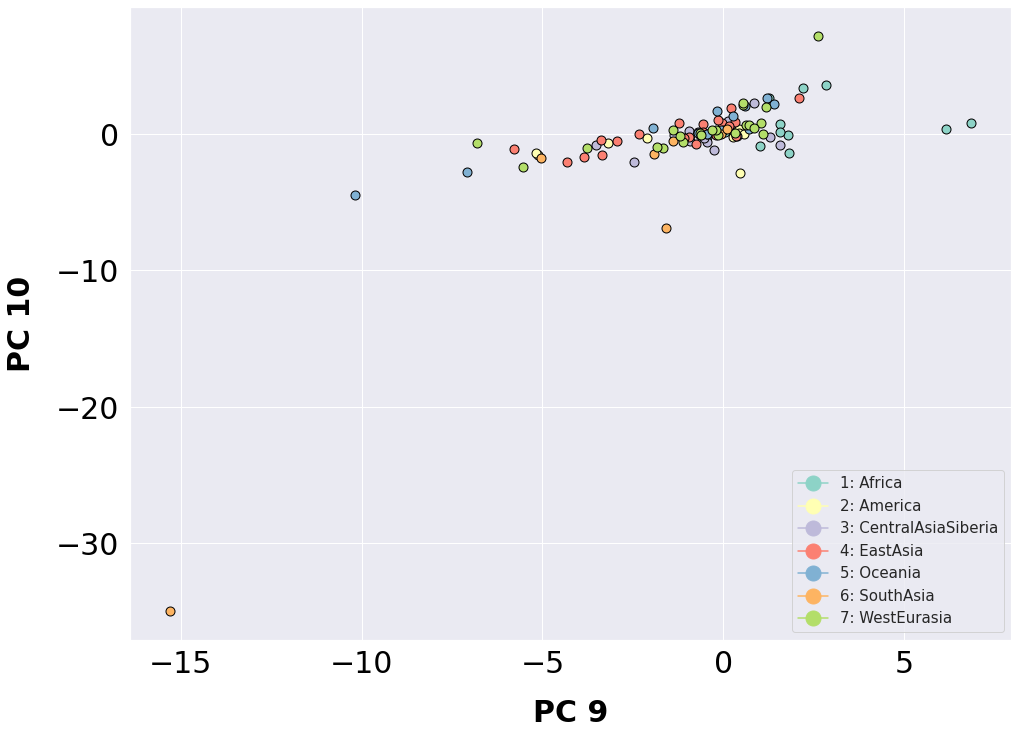

In [33]:
df_pca_outlier = df_pca[df_pca['component_1'] < 15]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_1'] > -1.5]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_2'] < 30]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_3'] < 30]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_4'] < 20]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_5'] < 20]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_6'] < 20]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_7'] < 20]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_8'] < 20]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_9'] < 20]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_10'] < 20]


outliers = pd.concat([df_pca,df_pca_outlier]).drop_duplicates(keep=False)

outlier_samples = list(outliers.index)
outlier_samples

components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca_outlier, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

                   7-Gender      11-Country  component_1  component_2  \
10-Region                                                               
SouthAsia                 M           India    15.366956     5.392459   
EastAsia                  F           China    -0.328008    -6.014012   
EastAsia                  F         Vietnam     3.346154    -5.638243   
EastAsia                  F           China    -0.809184    -3.762632   
SouthAsia                 F        Pakistan     2.765132    -8.548249   
...                     ...             ...          ...          ...   
WestEurasia               F  Italy(Bergamo)     4.764859    -2.270902   
CentralAsiaSiberia        F          Russia     0.450937    -3.232399   
Africa                    M         Namibia    15.009114     5.759147   
CentralAsiaSiberia        F          Russia     3.863644    -4.319378   
America                   F          Mexico     3.212781    -3.692137   

                    component_3  component_4  comp

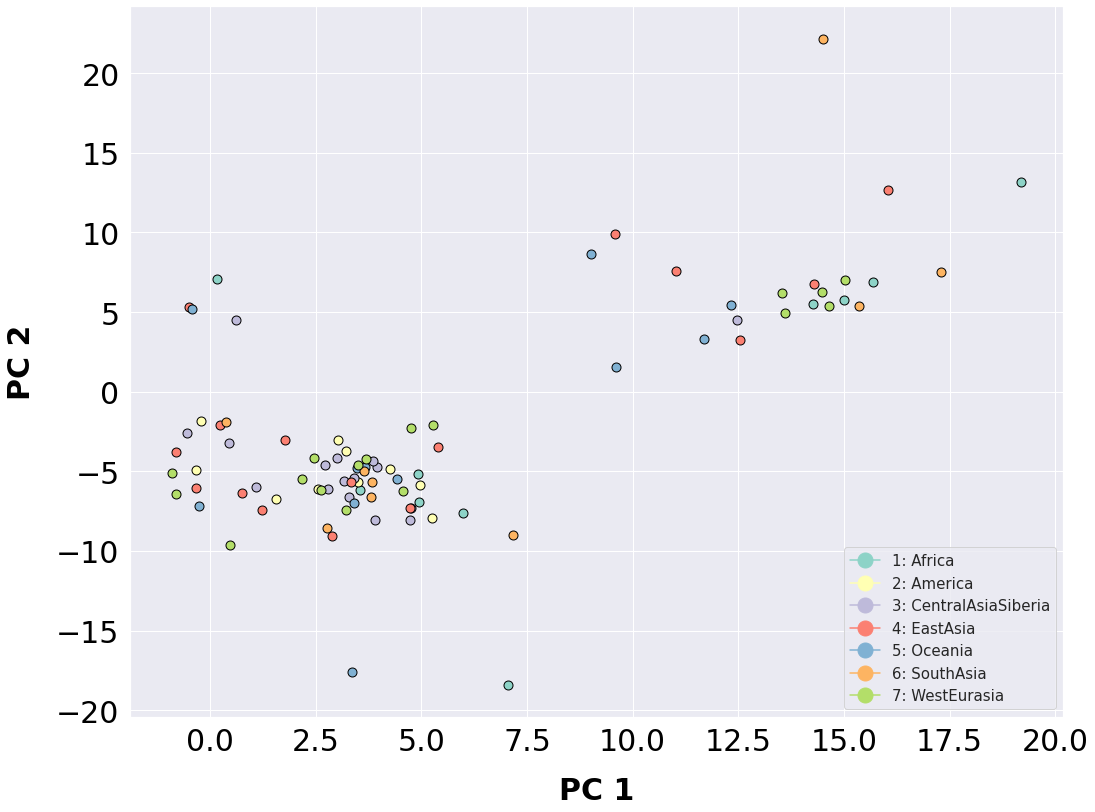

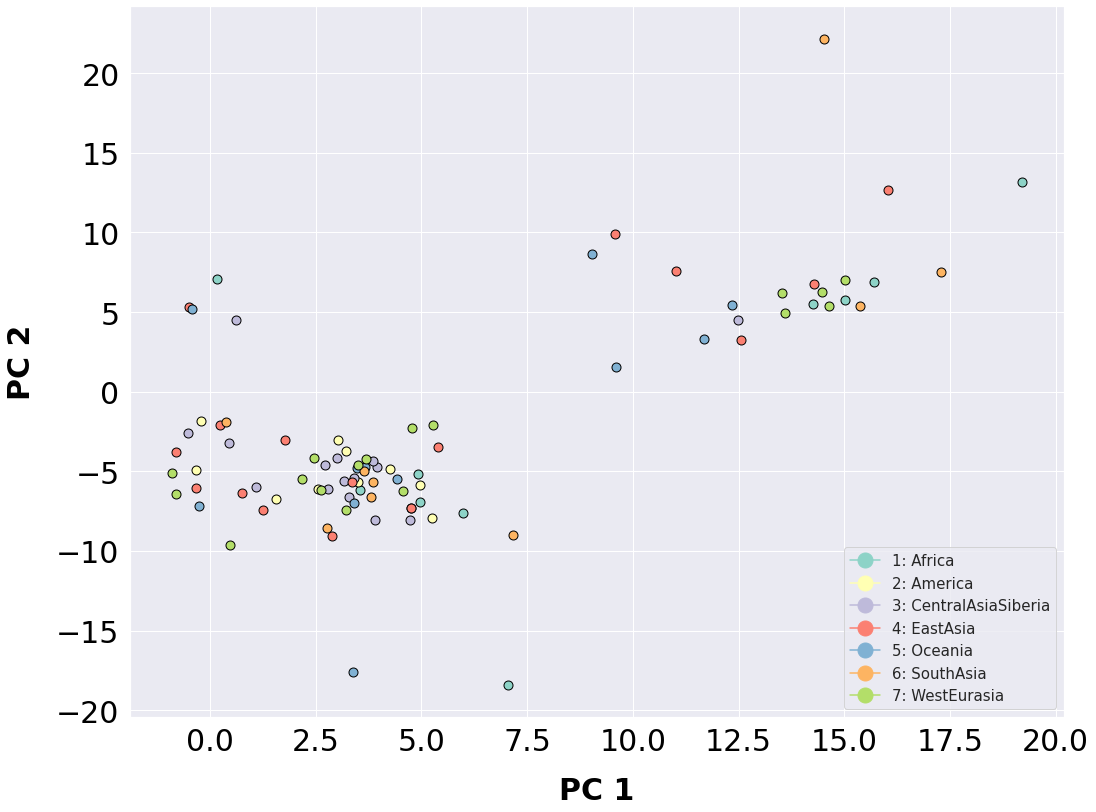

In [75]:
df_pca_outlier = df_pca[df_pca['component_1'] > -1.5]
df_pca_outlier = df_pca_outlier[df_pca_outlier['component_1'] < 20]
plot_scatter_cluster(data=df_pca_outlier, 
                     abscissa='component_1', 
                     ordinate='component_2', 
                     label_horizontal='PC 1', 
                     label_vertical='PC 2', 
                     factor='10-Region', 
                     fonts=define_font_properties(), 
                     colors=define_color_properties(), 
                     legend=True)
  

In [33]:
from Bio.Phylo.TreeConstruction import _Matrix
from Bio.Phylo.TreeConstruction import DistanceMatrix
from scipy.spatial.distance import pdist, squareform

#distance_matrix(np.array(counts))
distances = pdist(np.array(counts.T), metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix.shape
#dist_matrix = dist_matrix.tolist()
#dist_matrix =np.tril(dist_matrix)
#dist_matrix = dist_matrix.tolist()
#np.triu(np.ones_like(dist_matrix))

dist_matrix

name =  list(counts.T.index)
matrix = dist_matrix
#m = _Matrix(names, matrix)
dist_matrix.shape

(245, 245)

In [34]:
from biotite.sequence.phylo import neighbor_joining
#track features for pca & tsne
features = features.sort_index()

#names.get_indices()
labels = list(counts.T.index)
labels = list(features['10-Region'])
tree = biotite.sequence.phylo.neighbor_joining(dist_matrix)
t = print(tree.to_newick(labels=labels, include_distance=False))
t#

(((((((WestEurasia,(WestEurasia,SouthAsia)),(SouthAsia,CentralAsiaSiberia)),((((WestEurasia,WestEurasia),(EastAsia,WestEurasia)),(CentralAsiaSiberia,America)),((((America,America),America),(Oceania,(Oceania,Oceania))),(CentralAsiaSiberia,CentralAsiaSiberia)))),((((EastAsia,Africa),WestEurasia),(WestEurasia,(WestEurasia,WestEurasia))),Africa)),((((WestEurasia,WestEurasia),WestEurasia),WestEurasia),WestEurasia)),(WestEurasia,WestEurasia)),((((WestEurasia,SouthAsia),(WestEurasia,WestEurasia)),((WestEurasia,SouthAsia),WestEurasia)),(((SouthAsia,(Africa,Africa)),Africa),((SouthAsia,EastAsia),(WestEurasia,WestEurasia)))),((((SouthAsia,SouthAsia),(Africa,(WestEurasia,WestEurasia))),(EastAsia,(((WestEurasia,WestEurasia),(CentralAsiaSiberia,(SouthAsia,(WestEurasia,WestEurasia)))),(CentralAsiaSiberia,WestEurasia)))),(((((((SouthAsia,SouthAsia),SouthAsia),(EastAsia,CentralAsiaSiberia)),(EastAsia,America)),((((((((((((((((((((EastAsia,((Africa,((EastAsia,Oceania),(Oceania,America))),(SouthAsia,Wes

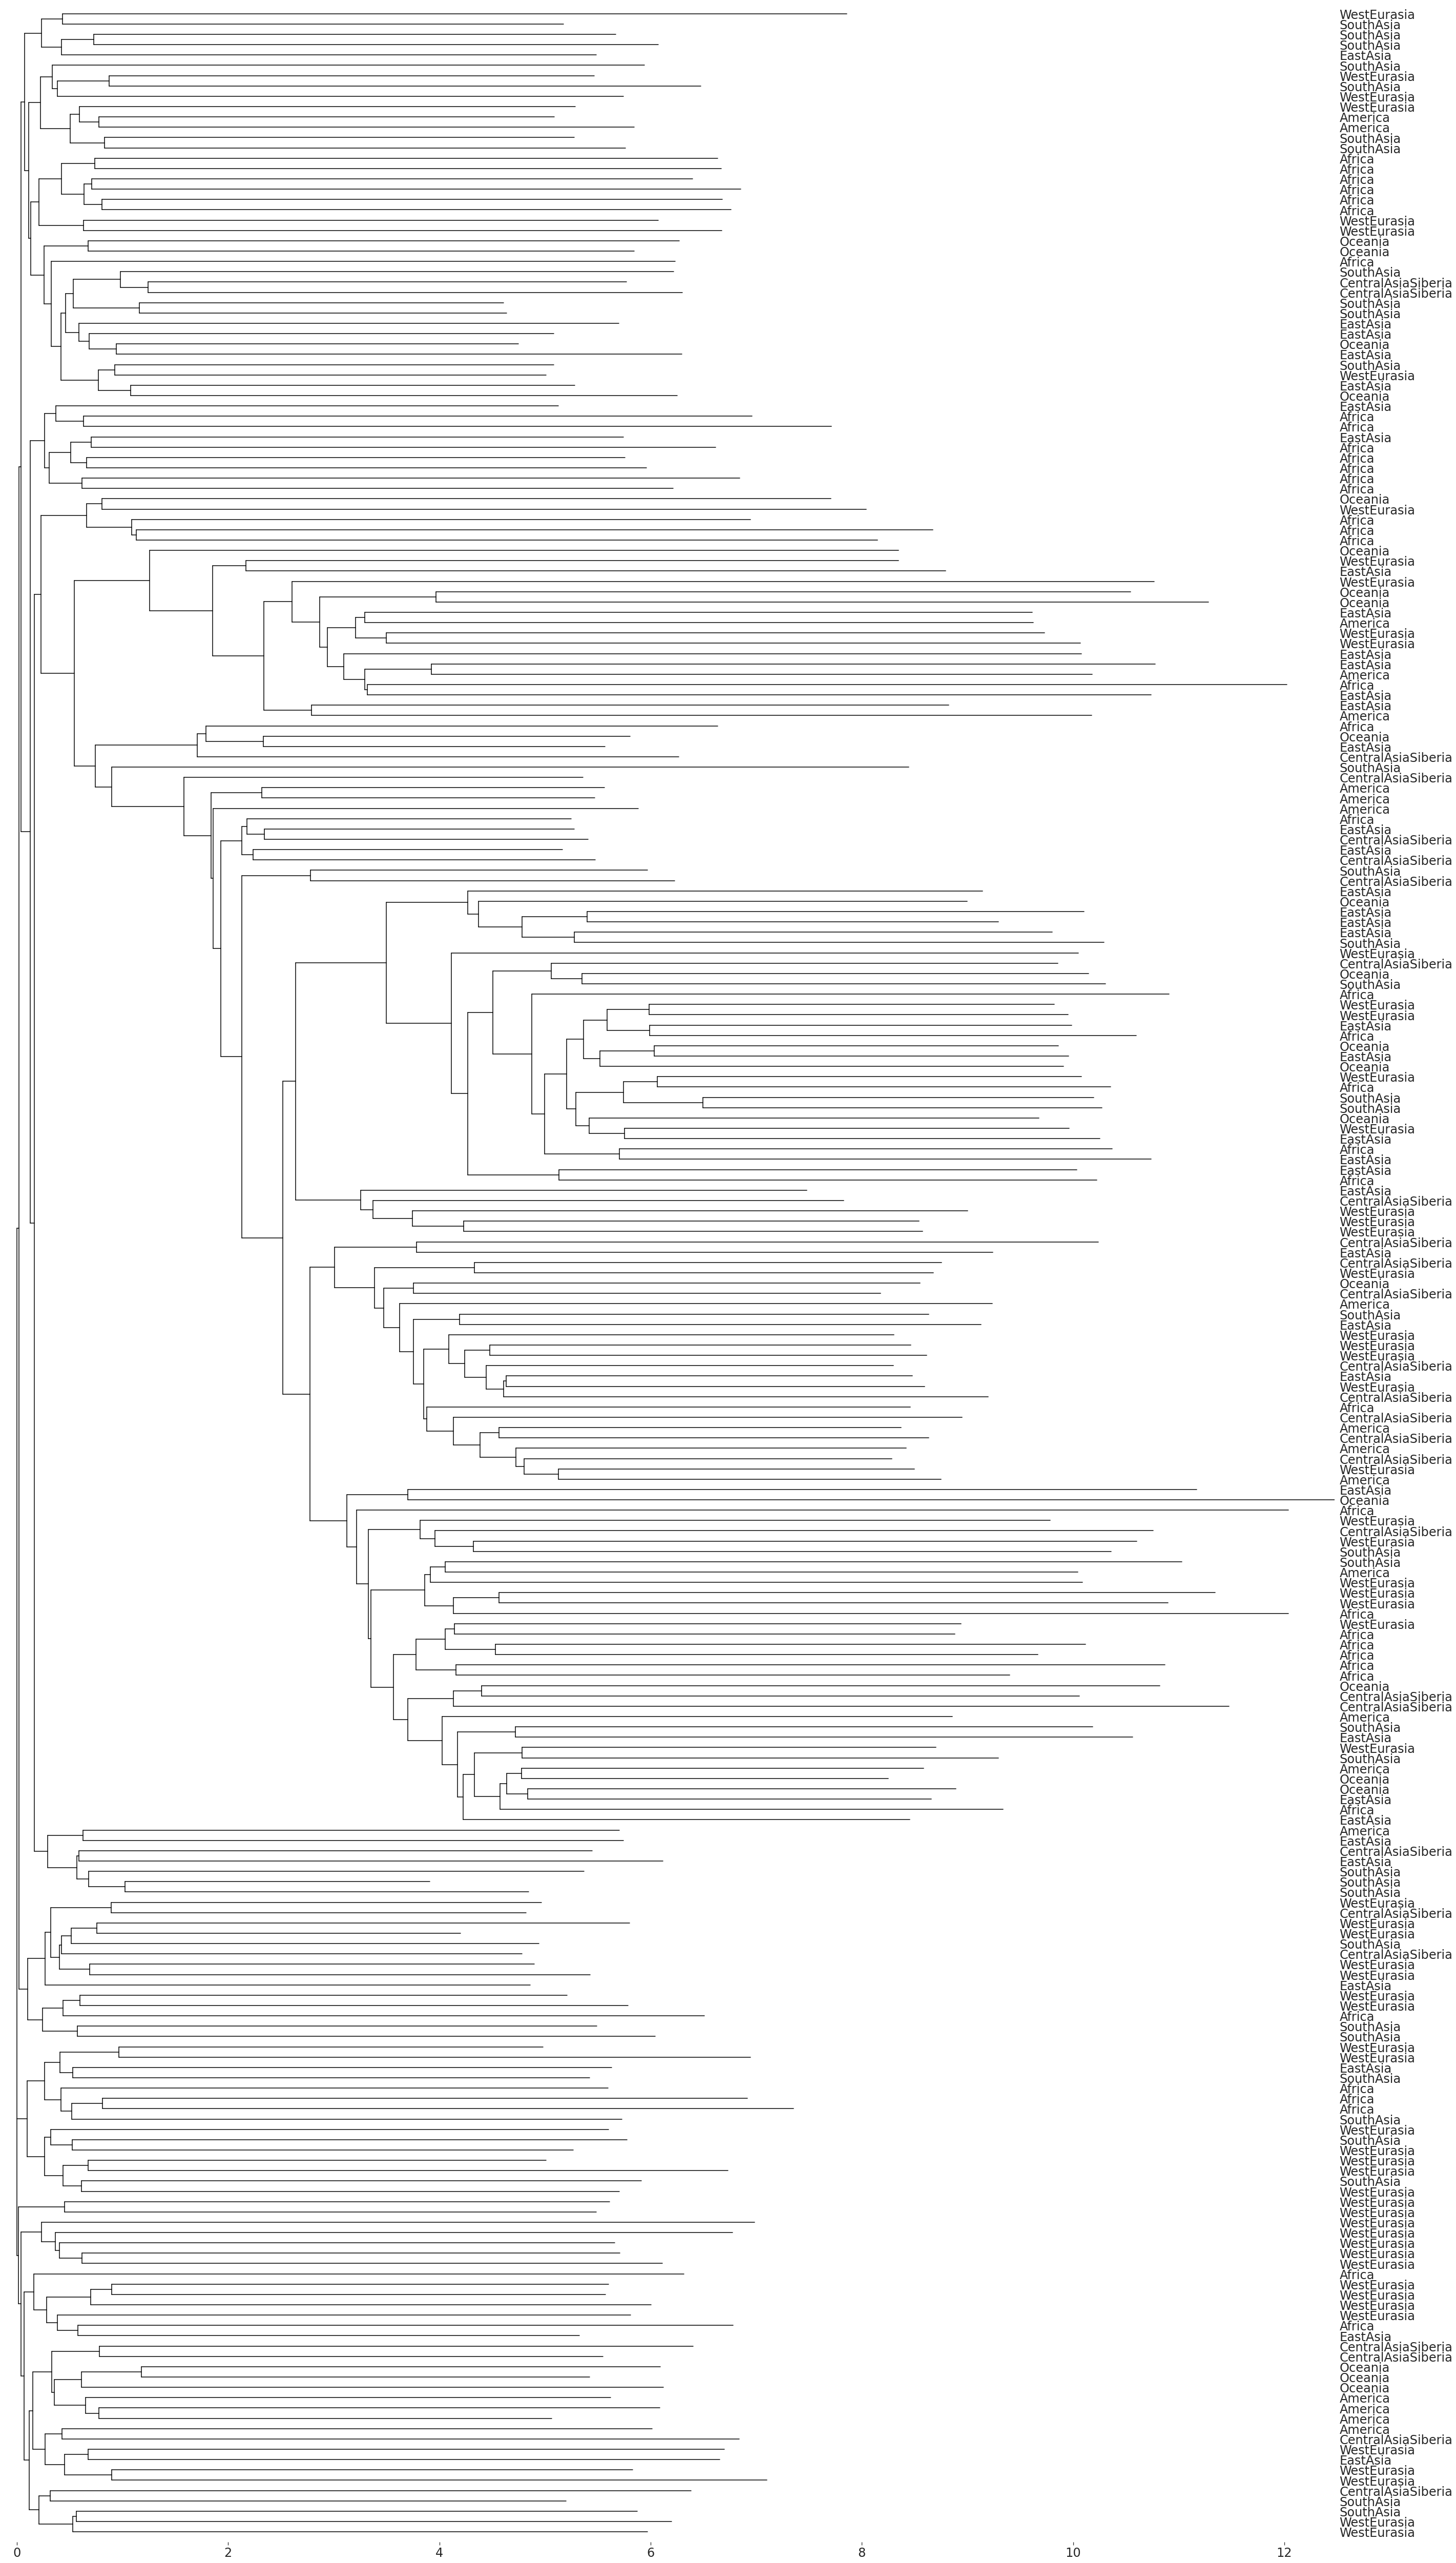

In [35]:
import biotite.sequence.graphics as graphics



row_colors = features['10-Region'].map(lut)

fig, ax = plt.subplots(figsize=(40.0, 70.0))
graphics.plot_dendrogram(ax, tree, labels=labels)
fig.tight_layout()
plt.savefig('neighbor-joining-tree.png')

In [79]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
heterozygous_deletions = qdnaseq_df[qdnaseq_df['TYPE'] == 1] 
heterozygous_deletions = heterozygous_deletions.groupby('SAMPLE').sum()
#heterozygous_deletions = heterozygous_deletions.set_index('SAMPLE')
#features = anotation.merge(count, left_index=True, right_index=True)
#features = features.loc[:,["7-Gender","10-Region", "11-Country"]]
#features = features.sort_index()
#features
heterozygous_deletions = features.merge(heterozygous_deletions, left_index=True, right_index=True)
heterozygous_deletions = heterozygous_deletions.reset_index()

#heterozygous_deletions.value_counts('SAMPLE').sort_index()
heterozygous_deletions

index 7-Gender           10-Region      11-Country       START  \
0   SAMEA3302610        M           SouthAsia           India  2364825032   
1   SAMEA3302613        F            EastAsia         Vietnam  2383165027   
2   SAMEA3302624        M         WestEurasia         Armenia  1957505028   
3   SAMEA3302626        M             Oceania  PapuaNewGuinea  1714980037   
4   SAMEA3302627        F             America          Mexico  4937995059   
..           ...      ...                 ...             ...         ...   
60  SAMEA3302840        F            EastAsia           China  2777130035   
61  SAMEA3302846        M            EastAsia           China  1833205028   
62  SAMEA3302855        F         WestEurasia  Italy(Bergamo)  2065940036   
63  SAMEA3302856        F  CentralAsiaSiberia          Russia  4916975056   
64  SAMEA3302858        M              Africa         Namibia  1677400025   

           END     SIZE     LOG2  TYPE  
0   2372370000  7545000   -55.74    32  
1   2391460000  8295000   -33.68    27  
2   1962390000  4885000   -51.14    28  
3   1722575000  7595000 -1086.38    37  
4   4944880000  6885000 -3288.57    59  
..         ...      ...      ...   ...  
60  2784325000  7195000   -55.02    35  
61  1837950000  4745000   -42.41    28  
62  2073030000  7090000   -49.94    36  
63  4922960000  5985000 -2220.39    56  
64  1681570000  4170000   -36.40    25  

[65 rows x 9 columns]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

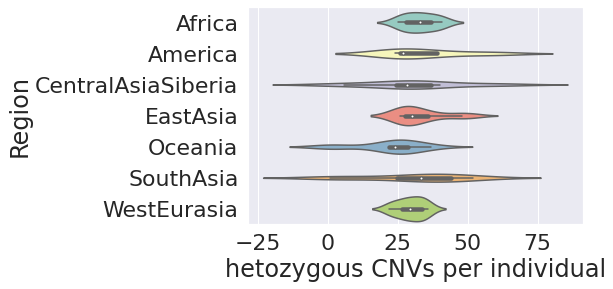

In [80]:
ax = sns.violinplot(x="TYPE", y="10-Region", data=heterozygous_deletions, palette='Set3', order=[ "Africa","America", "CentralAsiaSiberia","EastAsia", "Oceania", "SouthAsia", "WestEurasia"])

ax.set_xlabel("hetozygous CNVs per individual")
ax.set_ylabel("Region")
plt.show()

In [81]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
biallelic_deletions = qdnaseq_df[qdnaseq_df['TYPE'] < 2 ] 
biallelic_deletions = biallelic_deletions.groupby('SAMPLE').size()

biallelic_deletions = pd.DataFrame(biallelic_deletions)
#biallelic_deletions = biallelic_deletions.set_index('SAMPLE')

biallelic_deletions = features.merge(biallelic_deletions, left_index=True, right_index=True)
#biallelic_deletions = biallelic_deletions.reset_index()

#heterozygous_deletions.value_counts('SAMPLE').sort_index()
biallelic_deletions.columns = ['7-Gender', '10-Region', '11-Country', 'TYPE']
biallelic_deletions

7-Gender           10-Region 11-Country  TYPE
SAMEA3302610        M           SouthAsia      India    72
SAMEA3302611        F            EastAsia      China    47
SAMEA3302612        M         WestEurasia       Iran    17
SAMEA3302613        F            EastAsia    Vietnam    54
SAMEA3302614        F            EastAsia      China    39
...               ...                 ...        ...   ...
SAMEA3302856        F  CentralAsiaSiberia     Russia    60
SAMEA3302858        M              Africa    Namibia    70
SAMEA3302862        F  CentralAsiaSiberia     Russia    41
SAMEA3302863        M         WestEurasia     Israel    34
SAMEA3302866        F             America     Mexico    41

[181 rows x 4 columns]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

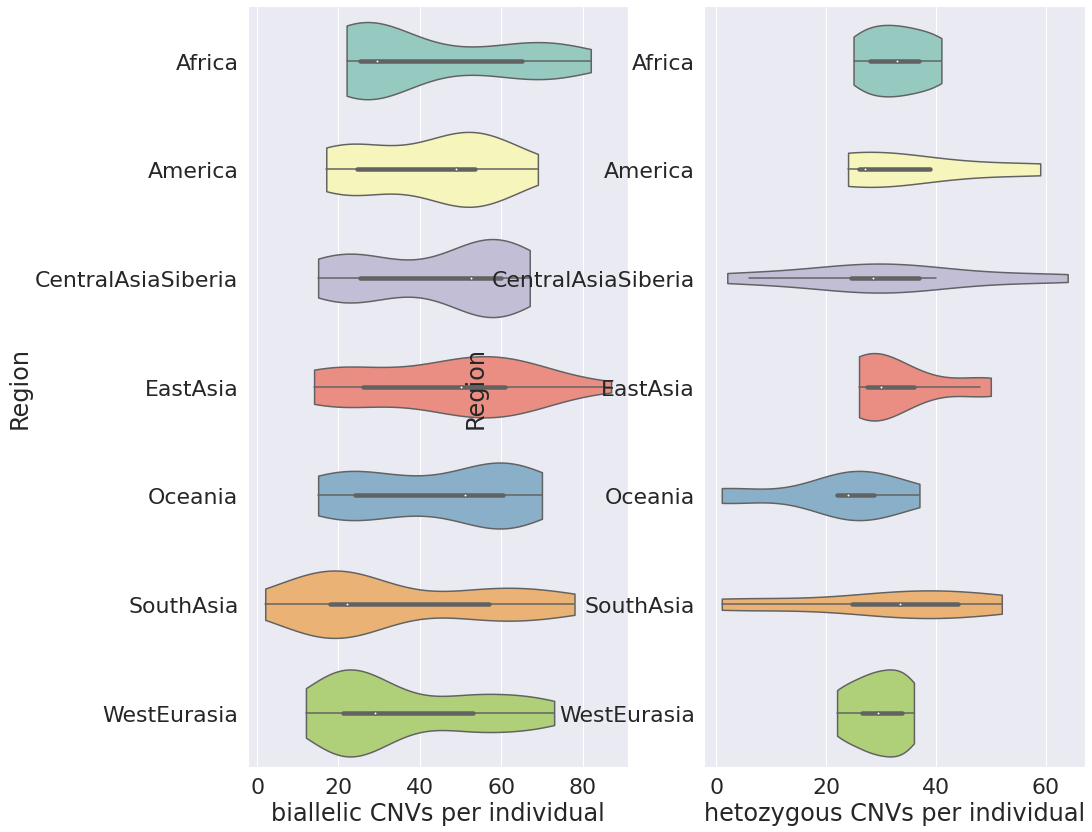

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(15, 14))

ax = sns.violinplot(x="TYPE", y="10-Region", data=biallelic_deletions, palette='Set3', order=[ "Africa","America", "CentralAsiaSiberia","EastAsia", "Oceania", "SouthAsia", "WestEurasia"], ax=axs[0], cut=0)

ax.set_xlabel("biallelic CNVs per individual")
ax.set_ylabel("Region")

ax = sns.violinplot(x="TYPE", y="10-Region", data=heterozygous_deletions, palette='Set3', order=[ "Africa","America", "CentralAsiaSiberia","EastAsia", "Oceania", "SouthAsia", "WestEurasia"], ax=axs[1], cut=0)

ax.set_xlabel("hetozygous CNVs per individual")
ax.set_ylabel("Region")
plt.show()

In [31]:
def plot_scatter_cluster(
data=None,
abscissa=None,
ordinate=None,
label_horizontal=None,
label_vertical=None,
factor=None,
fonts=None,
colors=None,
legend=None,
):
    """
    Creates a figure of a chart of type histogram to represent the frequency
    distribution of a single series of values.
    arguments:
        data (object): Pandas data frame of groups, series, and values
        abscissa (str): name of data column with independent variable
        ordinate (str): name of data column with dependent variable
        label_horizontal (str): label for horizontal axis
        label_vertical (str): label for vertical axis
        factor (str): name of data column with groups or factors of samples
        fonts (dict<object>): references to definitions of font properties
        colors (dict<tuple>): references to definitions of color properties
        legend (bool): whether to include a legend for series on the chart
    raises:
    returns:
        (object): figure object
    """
##########
# Organize data.
# Separate points by groups.
# Define groups.
    data = data.copy(deep=True)
    data.set_index(
        factor,
append=False,
drop=True,
inplace=True
    )
    print(data)
    groups = data.groupby(level=[factor])
    print("Count of groups by factor: " + str(len(groups)))
    colors_series = list(seaborn.color_palette("Set3", n_colors=len(groups)))
##########
# Create figure.
    figure = matplotlib.pyplot.figure(
    figsize=(15.748, 11.811),
    tight_layout=True
    )
# Create axes.
    axes = matplotlib.pyplot.axes()
    axes.set_xlabel(
    xlabel=label_horizontal,
labelpad=20,
alpha=1.0,
backgroundcolor=colors["white"],
color=colors["black"],
fontproperties=fonts["properties"]["one"]
    )
    axes.set_ylabel(
        ylabel=label_vertical,
        labelpad=20,
        alpha=1.0,
        backgroundcolor=colors["white"],
        color=colors["black"],
        fontproperties=fonts["properties"]["one"]
    )
    axes.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=5.0,
        width=3.0,
        color=colors["black"],
        pad=5,
        labelsize=fonts["values"]["one"]["size"],
        labelcolor=colors["black"]
    )
# Plot points for values from each group.
    index = 0
    for name, group in groups:
        values_x = group[abscissa].to_list()
        values_y = group[ordinate].to_list()
        handle = axes.plot(
            values_x,
            values_y,
linestyle="",
marker="o",
markersize=9,
markeredgecolor=colors["black"],#colors_series[index],
markerfacecolor=colors_series[index]
        )
        index += 1
        pass
# Plot labels for each group.
    labels = []
    index = 0
    for name, group in groups:
        values_x = group[abscissa].to_list()
        mean_x = statistics.median(values_x)
        values_y = group[ordinate].to_list()
        mean_y = statistics.median(values_y)
#        axes.text(
#            mean_x,
#            mean_y,
#str(index+1),
#backgroundcolor=colors["white_faint"],
#color=colors["black"],
#fontproperties=fonts["properties"]["three"],
#horizontalalignment="center",
#verticalalignment="center"
#        )
        label = str(index+1) + ": " + name
        labels.append(label)
        index += 1
        pass
# Create legend.
# Create custome elements for the legend
    elements = create_legend_elements(
colors=colors_series,
labels=labels
    )
    axes.legend(
handles=elements,
loc="lower right",
prop=fonts["properties"]["four"],
    )
    return figure


def define_font_properties():
    """
    Defines font properties.
    arguments:
    raises:
    returns:
        (dict<object>): references to definitions of font properties
    """
# Define font values.
    values_one = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 1000,
"weight": 1000,
"size": 30
    }
    values_two = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 500,
"weight": 1000,
"size": 25
    }
    values_three = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 500,
"weight": 1000,
"size": 20
    }
    values_four = {
"family": "sans-serif",
"style": "normal",
"variant": "normal",
"stretch": 500,
"weight": 500,
"size": 15
    }
# Define font properties.
    properties_one = matplotlib.font_manager.FontProperties(
family=values_one["family"],
style=values_one["style"],
variant=values_one["variant"],
stretch=values_one["stretch"],
weight=values_one["weight"],
size=values_one["size"]
    )
    properties_two = matplotlib.font_manager.FontProperties(
family=values_two["family"],
style=values_two["style"],
variant=values_two["variant"],
stretch=values_two["stretch"],
weight=values_two["weight"],
size=values_two["size"]
    )
    properties_three = matplotlib.font_manager.FontProperties(
family=values_three["family"],
style=values_three["style"],
variant=values_three["variant"],
stretch=values_three["stretch"],
weight=values_three["weight"],
size=values_three["size"]
    )
    properties_four = matplotlib.font_manager.FontProperties(
family=values_four["family"],
style=values_four["style"],
variant=values_four["variant"],
stretch=values_four["stretch"],
weight=values_four["weight"],
size=values_four["size"]
    )
# Compile and return references.
    return {
"values": {
"one": values_one,
"two": values_two,
"three": values_three,
"four": values_four
        },
"properties": {
"one": properties_one,
"two": properties_two,
"three": properties_three,
"four": properties_four
        }
    }



def define_color_properties():
    """
    Defines color properties.
    arguments:
    raises:
    returns:
        (dict<tuple>): references to definitions of color properties
    """
# Black.
    black = (0.0, 0.0, 0.0, 1.0)
# White.
    white = (1.0, 1.0, 1.0, 1.0)
    white_faint = (1.0, 1.0, 1.0, 0.75)
# Blue.
    blue = (0.0, 0.2, 0.5, 1.0)
    blue_faint = (0.0, 0.2, 0.5, 0.75)
# Orange.
    orange = (1.0, 0.6, 0.2, 1.0)
    orange_faint = (1.0, 0.6, 0.2, 0.75)
# Compile and return references.
    return {
"black": black,
"white": white,
"white_faint": white_faint,
"blue": blue,
"blue_faint": blue_faint,
"orange": orange,
"orange_faint": orange_faint
    }


def create_legend_elements(
colors=None,
labels=None,
):
    """
    Creates custom elements for legend.
    arguments:
        colors (list<dict>): colors
        labels (str): name of data column with independent variable
    raises:
    returns:
        (list<object>): elements for legend
    """
    elements = []
    for index in range(len(labels)):
        element = matplotlib.lines.Line2D(
            [0],
            [0],
            marker="o",
            color=colors[index],
            label=labels[index],
            markerfacecolor=colors[index],
            markersize=15,
        )
        elements.append(element)
    return elements